In [1]:
import catalyst
import torch
import pretrainedmodels

from torch import nn


In [2]:
import matplotlib.pyplot as plt
import cv2


def _read_image_if_need(*args):
    """
    for each item read image if it is path

    :param args: list: images or image paths
    :return: list: images
    """
    images = []
    for image in args:
        if type(image) == str:
            image = cv2.imread(image)
        images.append(image)
    return images


def show_image(image, figsize=(20, 20), title=None, cmap=None, axis=False):
    """
    show single image
    :param image: np.array: image
    :param figsize: (int, int): figure size
    :param title: str: image title
    :param cmap: str: colormap name, for example "Greys_r"
    :param axis: bool: draw axis or not
    :return: None
    """
    image = _read_image_if_need(image)[0]
    plt.figure(figsize=figsize)
    plt.title(title)
    if not axis:
        plt.axis('off')
    plt.imshow(image, cmap)
    plt.show()

In [3]:
class GlobalAttnPool1d(nn.Module):
    def __init__(self, in_features):
        super().__init__()

        activation_fn = torch.nn.Sigmoid()
        self.attn = nn.Sequential(
            nn.Conv1d(in_features, 1, kernel_size=1, stride=1, padding=0, bias=False),
            torch.nn.Sigmoid(),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward call."""
        x_a = self.attn(x)
        x = x * x_a
        x = torch.sum(x, dim=[-1], keepdim=True)
        return x

In [4]:
from catalyst.contrib.nn import GlobalMaxAttnPool2d

class TransformerResNet(nn.Module):
    def __init__(self, model_name: str = "resnet18",
                 n_classes=10, d_model=512, nhead=8, num_layers=1, dropout=0.1):
        super(TransformerResNet, self).__init__()
        self.backbone = getattr(pretrainedmodels.models, model_name)()
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.pooling = GlobalAttnPool1d(512)
        self.dropout = nn.Dropout(p=dropout)
        self.linear = nn.Linear(512, n_classes)
    
    def forward(self, x):
        x = self.backbone.features(x)
        x = x.flatten(start_dim=2)
        x = x.transpose(1, 2)
        x = self.transformer_encoder(x)
        x = self.pooling(x.transpose(1, 2))[:, :, 0]
        x = self.dropout(x)
        logits = self.linear(x)
        return logits

In [54]:
model = TransformerResNet(num_layers=1, nhead=2, d_model=512)

In [55]:
dummy_input = torch.randn(1, 3, 224, 224, dtype=torch.float)

In [56]:
model(dummy_input)

tensor([[-1.0479,  1.9294, -3.2768,  1.2499, -3.6804, -2.7139, -0.4660,  1.5518,
          3.1764,  6.8574]], grad_fn=<AddmmBackward>)

## Dataset

In [5]:
from catalyst.contrib.datasets import Imagenette

In [6]:
train_dataset = Imagenette('./datasets/', train=True, download=False)

In [7]:
from glob import glob

In [8]:
label_directories = sorted(glob('./datasets/imagenette2/train/*/'))
image_paths = []
labels = []
for idx, directory in enumerate(label_directories):
    label_paths = glob(f'{directory}/*')
    image_paths.extend(label_paths)
    labels.extend([idx] * len(label_paths))

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
train_image_paths, valid_image_paths, train_labels, valid_labels = train_test_split(image_paths,
                                                                                    labels,
                                                                                    test_size=0.2,
                                                                                    random_state=42,
                                                                                    stratify=labels)

In [11]:
from torch.utils.data import Dataset
from typing import Callable, Dict, Any, List

In [12]:
class ImagenetteDataset(Dataset):
    def __init__(self,
                 image_paths: List[str],
                 labels: List[int],
                 transforms: Callable,
                 num_classes: int = 10):
        self.image_paths = image_paths
        self.labels = labels
        self.transforms = transforms
        self.num_classes = num_classes
        
    def __len__(self) -> int:
        return len(self.image_paths)

    def __getitem__(self, idx: int) -> Dict[str, Any]:
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        label = self.labels[idx]
        result = {"image": image, }

        if self.transforms is not None:
            result = self.transforms(**result)
        result['targets'] = label
        target_one_hot = [0] * self.num_classes
        target_one_hot[label] = 1
        result['targets_one_hot'] = torch.Tensor(target_one_hot)
        return result

## Augmentations

In [13]:
import albumentations as albu
from albumentations.pytorch import ToTensor

BORDER_CONSTANT = 0
BORDER_REFLECT = 2

def pre_transforms(image_size=224):
    # Convert the image to a square of size image_size x image_size
    # (keeping aspect ratio)
    result = [
        albu.LongestMaxSize(max_size=image_size),
        albu.PadIfNeeded(image_size, image_size, border_mode=BORDER_CONSTANT)
    ]
    
    return result

def hard_transforms():
    result = [
        # Random shifts, stretches and turns with a 50% probability
        albu.ShiftScaleRotate( 
            shift_limit=0.1,
            scale_limit=0.1,
            rotate_limit=15,
            border_mode=BORDER_REFLECT,
            p=0.5
        ),
        albu.IAAPerspective(scale=(0.02, 0.05), p=0.3),
        # Random brightness / contrast with a 30% probability
        albu.RandomBrightnessContrast(
            brightness_limit=0.2, contrast_limit=0.2, p=0.3
        ),
        # Random gamma changes with a 30% probability
        albu.RandomGamma(gamma_limit=(85, 115), p=0.3),
        # Randomly changes the hue, saturation, and color value of the input image
        albu.HueSaturationValue(p=0.3),
        albu.JpegCompression(quality_lower=80),
    ]
    
    return result

def post_transforms():
    # we use ImageNet image normalization
    # and convert it to torch.Tensor
    return [albu.Normalize(), ToTensor()]

def compose(transforms_to_compose):
    # combine all augmentations into one single pipeline
    result = albu.Compose([
      item for sublist in transforms_to_compose for item in sublist
    ])
    return result

In [14]:
train_transforms = compose([
    pre_transforms(), 
    hard_transforms(), 
    post_transforms()
])
valid_transforms = compose([pre_transforms(), post_transforms()])

show_transforms = compose([pre_transforms(), hard_transforms()])

## Create Loaders 

In [15]:
import collections

from torch.utils.data import DataLoader

In [16]:
train_dataset = ImagenetteDataset(train_image_paths, train_labels, train_transforms)
valid_dataset = ImagenetteDataset(valid_image_paths, valid_labels, valid_transforms)

batch_size = 64

In [17]:
loaders = collections.OrderedDict()
loaders["train"] = DataLoader(train_dataset, batch_size=batch_size)
loaders["valid"] = DataLoader(valid_dataset, batch_size=batch_size)

## Train!

In [18]:
from torch import optim

from catalyst.contrib.nn import RAdam, Lookahead
from ptflops import get_model_complexity_info

# as we are working on classification task
from catalyst import dl
from catalyst.dl import AccuracyCallback
from catalyst.dl import AUCCallback
# from ca#, AUCCallback, 
from catalyst.dl import SupervisedRunner
import torch

# as we are working on classification task
from catalyst import dl
from catalyst.dl import AccuracyCallback, AUCCallback

from catalyst.metrics import MulticlassPrecisionRecallF1SupportMetric
from catalyst.metrics import AccuracyMetric

In [19]:
num_layers_list = [0, 1, 2, 3, 4]
nhead_list = [1, 4, 8]

In [25]:
RESULT = []
for nhead in nhead_list:
    for num_layers in num_layers_list:
        RESULT_EXP = {'nhead': nhead, 'num_layers': num_layers}
        model = TransformerResNet(num_layers=num_layers, nhead=nhead)
        with torch.cuda.device(0):
            macs, params = get_model_complexity_info(model, (3, 224, 224), as_strings=True,
                                                     print_per_layer_stat=False, verbose=False)
        RESULT_EXP['macs'] = macs
        RESULT_EXP['params'] = params

        # as we are working on basic classification problem (no multiclass/multilabel)
        # let's use standard CE loss
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=[9], gamma=0.3
        )    


        criterion = nn.CrossEntropyLoss()

        learning_rate = 0.01
        encoder_learning_rate = 0.001

        # Since we use a pre-trained encoder, we will reduce the learning rate on it.
        layerwise_params = {"backbone*": dict(lr=encoder_learning_rate, weight_decay=0.00003)}

        # This function removes weight_decay for biases and applies our layerwise_params
        model_params = catalyst.utils.process_model_params(model, layerwise_params=layerwise_params)

        # Catalyst has new SOTA optimizers out of box
        base_optimizer = RAdam(model_params, lr=learning_rate, weight_decay=0.0003)
        optimizer = Lookahead(base_optimizer)

        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.25, patience=2)
        
        


        num_epochs = 10
        logdir = f"./logs/classification_10_epoch_num_layers_{num_layers}_nhead_{nhead}/"

        device = 'cuda:0' #catalyst.utils.get_device()
        print(f"device: {device}")
        runner = SupervisedRunner(input_key='image', )
        

        callbacks = [
            AccuracyCallback(input_key='logits',
                             target_key='targets',
                             num_classes=10,
                             topk_args=(1, 3)),
            AUCCallback(
                target_key="targets_one_hot",
                input_key="logits",
            ),
            dl.CriterionCallback(
                        metric_key="loss", 
                        input_key="logits", 
                        target_key="targets"
                    ),
            dl.OptimizerCallback(metric_key="loss"),
            dl.SchedulerCallback(
                        loader_key="valid", metric_key="loss"
                    ),
        ]

        runner.train(
            model=model,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            # our dataloaders
            loaders=loaders,
            # We can specify the callbacks list for the experiment;
            # For this task, we will check accuracy, AUC and F1 metrics
            callbacks=callbacks,
            # path to save logs
            logdir=logdir,
            num_epochs=num_epochs,
            engine=dl.DeviceEngine("cuda:0"),
            # save our best checkpoint by AUC metric
        #     main_metric="auc/mean",
            # AUC needs to be maximized.
            # prints train logs
            verbose=True,
        )


        model.load_state_dict(torch.load(f"{logdir}/checkpoints/best.pth")['model_state_dict']);

        prfs_metric = MulticlassPrecisionRecallF1SupportMetric(num_classes=10)
        accuracy_metric = AccuracyMetric([1])

        for batch in loaders['valid']:
            prediction = model(batch['image'].to(device))
            targets = batch['targets']
            prfs_metric.update_key_value(prediction.cpu().detach(), targets)
            accuracy_metric.update_key_value(prediction.cpu().detach(), targets)

        prfs = prfs_metric.compute_key_value()

        RESULT_EXP['precision'] = prfs['precision/_macro']
        RESULT_EXP['recall'] = prfs['recall/_macro']
        RESULT_EXP['f1'] = prfs['f1/_macro']

        RESULT_EXP['accuracy'] = accuracy_metric.compute_key_value()['accuracy']
        RESULT.append(RESULT_EXP)

device: cuda:0


/root/anaconda3/envs/catalyst21/lib/python3.6/site-packages/catalyst/core/runner.py:717: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  for k, v in self.batch_metrics.items()



train (1/10) accuracy: 0.3306930661201477 | accuracy/std: 0.12565328123709538 | accuracy01: 0.3306930661201477 | accuracy01/std: 0.12565328123709538 | accuracy03: 0.48488450050354004 | accuracy03/std: 0.14644558869851626 | auc: 0.7416289448738098 | auc/_macro: 0.7416289448738098 | auc/_micro: 0.6420729742061115 | auc/_weighted: 0.7427148222923279 | auc/class_00: 0.8379266858100891 | auc/class_01: 0.6411890387535095 | auc/class_02: 0.7514380216598511 | auc/class_03: 0.6369016170501709 | auc/class_04: 0.6697772741317749 | auc/class_05: 0.8603501319885254 | auc/class_06: 0.8170443177223206 | auc/class_07: 0.80323326587677 | auc/class_08: 0.8260763883590698 | auc/class_09: 0.5723523497581482 | loss: 2.1733407974243164 | loss/mean: 2.1733407974243164 | loss/std: 2.514416832724338 | lr: 0.001 | momentum: 0.9



valid (1/10) accuracy: 0.6948257684707642 | accuracy/std: 0.052488914465624 | accuracy01: 0.6948257684707642 | accuracy01/std: 0.052488914465624 | accuracy03: 0.8442449569702148 | accuracy03/std: 0.044598719996733024 | auc: 0.8648899793624878 | auc/_macro: 0.8648899793624878 | auc/_micro: 0.8008532970169171 | auc/_weighted: 0.8663211464881897 | auc/class_00: 0.9716594815254211 | auc/class_01: 0.8740719556808472 | auc/class_02: 0.9233483076095581 | auc/class_03: 0.7394558787345886 | auc/class_04: 0.7694151997566223 | auc/class_05: 0.9457563161849976 | auc/class_06: 0.9446790814399719 | auc/class_07: 0.9350305795669556 | auc/class_08: 0.9573974609375 | auc/class_09: 0.5880857110023499 | loss: 0.9771190881729126 | loss/mean: 0.9771190881729126 | loss/std: 0.1369487589903088 | lr: 0.001 | momentum: 0.9
* Epoch (1/10) lr: 0.001 | momentum: 0.9



train (2/10) accuracy: 0.7959076166152954 | accuracy/std: 0.06853462379485098 | accuracy01: 0.7959076166152954 | accuracy01/std: 0.06853462379485098 | accuracy03: 0.874191403388977 | accuracy03/std: 0.04613490794521376 | auc: 0.9312035441398621 | auc/_macro: 0.9312035441398621 | auc/_micro: 0.8799762753833139 | auc/_weighted: 0.9322701692581177 | auc/class_00: 0.9664637446403503 | auc/class_01: 0.9678117036819458 | auc/class_02: 0.9663369059562683 | auc/class_03: 0.8327295184135437 | auc/class_04: 0.948244571685791 | auc/class_05: 0.9623447060585022 | auc/class_06: 0.9493067860603333 | auc/class_07: 0.9365281462669373 | auc/class_08: 0.985407829284668 | auc/class_09: 0.796862006187439 | loss: 0.6688394546508789 | loss/mean: 0.6688394546508789 | loss/std: 0.2558609878992577 | lr: 0.001 | momentum: 0.9



valid (2/10) accuracy: 0.8489968180656433 | accuracy/std: 0.0390920713807893 | accuracy01: 0.8489968180656433 | accuracy01/std: 0.0390920713807893 | accuracy03: 0.8854276537895203 | accuracy03/std: 0.037676478234731164 | auc: 0.9701937437057495 | auc/_macro: 0.9701937437057495 | auc/_micro: 0.9229090462839791 | auc/_weighted: 0.9707111716270447 | auc/class_00: 0.988135576248169 | auc/class_01: 0.9917823076248169 | auc/class_02: 0.9796030521392822 | auc/class_03: 0.9188477396965027 | auc/class_04: 0.987936794757843 | auc/class_05: 0.9833032488822937 | auc/class_06: 0.9590432643890381 | auc/class_07: 0.965063214302063 | auc/class_08: 0.9981375336647034 | auc/class_09: 0.930085301399231 | loss: 0.43975985050201416 | loss/mean: 0.43975985050201416 | loss/std: 0.11764665051178123 | lr: 0.001 | momentum: 0.9
* Epoch (2/10) lr: 0.001 | momentum: 0.9



train (3/10) accuracy: 0.8586138486862183 | accuracy/std: 0.04840743361030429 | accuracy01: 0.8586138486862183 | accuracy01/std: 0.04840743361030429 | accuracy03: 0.9396699666976929 | accuracy03/std: 0.04240385906661507 | auc: 0.9772571325302124 | auc/_macro: 0.9772571325302124 | auc/_micro: 0.9336912551541183 | auc/_weighted: 0.9776625633239746 | auc/class_00: 0.9908411502838135 | auc/class_01: 0.9949208498001099 | auc/class_02: 0.9779077768325806 | auc/class_03: 0.9393733143806458 | auc/class_04: 0.9910470247268677 | auc/class_05: 0.9743779301643372 | auc/class_06: 0.9747740626335144 | auc/class_07: 0.9623015522956848 | auc/class_08: 0.9990457892417908 | auc/class_09: 0.9679825901985168 | loss: 0.3973679542541504 | loss/mean: 0.3973679542541504 | loss/std: 0.12783130337094645 | lr: 0.001 | momentum: 0.9



valid (3/10) accuracy: 0.8516367673873901 | accuracy/std: 0.038651450210432606 | accuracy01: 0.8516367673873901 | accuracy01/std: 0.038651450210432606 | accuracy03: 0.9646251201629639 | accuracy03/std: 0.02558619505823102 | auc: 0.9818397760391235 | auc/_macro: 0.9818397760391235 | auc/_micro: 0.9401661272851237 | auc/_weighted: 0.9822374582290649 | auc/class_00: 0.9940327405929565 | auc/class_01: 0.99396812915802 | auc/class_02: 0.9788914918899536 | auc/class_03: 0.9393856525421143 | auc/class_04: 0.9891403317451477 | auc/class_05: 0.9925047755241394 | auc/class_06: 0.9855072498321533 | auc/class_07: 0.9820200800895691 | auc/class_08: 0.998860239982605 | auc/class_09: 0.9640863537788391 | loss: 0.44159841537475586 | loss/mean: 0.44159841537475586 | loss/std: 0.14833970142738592 | lr: 0.001 | momentum: 0.9
* Epoch (3/10) lr: 0.001 | momentum: 0.9



train (4/10) accuracy: 0.9073267579078674 | accuracy/std: 0.0484848044132025 | accuracy01: 0.9073267579078674 | accuracy01/std: 0.0484848044132025 | accuracy03: 0.9680528044700623 | accuracy03/std: 0.02329230149327954 | auc: 0.9860203862190247 | auc/_macro: 0.9860203862190247 | auc/_micro: 0.948131107940277 | auc/_weighted: 0.9862734079360962 | auc/class_00: 0.9935547709465027 | auc/class_01: 0.9967117309570312 | auc/class_02: 0.9786336421966553 | auc/class_03: 0.9596019983291626 | auc/class_04: 0.9938245415687561 | auc/class_05: 0.9917685389518738 | auc/class_06: 0.9844896793365479 | auc/class_07: 0.9773291945457458 | auc/class_08: 0.9994812607765198 | auc/class_09: 0.9848084449768066 | loss: 0.3482891619205475 | loss/mean: 0.3482891619205475 | loss/std: 0.1089913597441775 | lr: 0.001 | momentum: 0.9



valid (4/10) accuracy: 0.9255543947219849 | accuracy/std: 0.032994049466309 | accuracy01: 0.9255543947219849 | accuracy01/std: 0.032994049466309 | accuracy03: 0.9693769812583923 | accuracy03/std: 0.021562264247395352 | auc: 0.988028347492218 | auc/_macro: 0.988028347492218 | auc/_micro: 0.9540410004310345 | auc/_weighted: 0.988158106803894 | auc/class_00: 0.9946572184562683 | auc/class_01: 0.9982168674468994 | auc/class_02: 0.9747647047042847 | auc/class_03: 0.9715176820755005 | auc/class_04: 0.9952420592308044 | auc/class_05: 0.9973161220550537 | auc/class_06: 0.9845004677772522 | auc/class_07: 0.9758284687995911 | auc/class_08: 0.9996509552001953 | auc/class_09: 0.988588809967041 | loss: 0.4167673587799072 | loss/mean: 0.4167673587799072 | loss/std: 0.1362843210215019 | lr: 0.001 | momentum: 0.9
* Epoch (4/10) lr: 0.001 | momentum: 0.9



train (5/10) accuracy: 0.9497029781341553 | accuracy/std: 0.029424592885018582 | accuracy01: 0.9497029781341553 | accuracy01/std: 0.029424592885018582 | accuracy03: 0.9766336679458618 | accuracy03/std: 0.021124273653703805 | auc: 0.9891308546066284 | auc/_macro: 0.9891308546066284 | auc/_micro: 0.9584062138667113 | auc/_weighted: 0.989297091960907 | auc/class_00: 0.9971575736999512 | auc/class_01: 0.9985433220863342 | auc/class_02: 0.9855461716651917 | auc/class_03: 0.9753612875938416 | auc/class_04: 0.9960770606994629 | auc/class_05: 0.9895046949386597 | auc/class_06: 0.9884480237960815 | auc/class_07: 0.9706751704216003 | auc/class_08: 0.999575138092041 | auc/class_09: 0.9904200434684753 | loss: 0.31745681166648865 | loss/mean: 0.31745681166648865 | loss/std: 0.09823846466972162 | lr: 0.001 | momentum: 0.9



valid (5/10) accuracy: 0.9303062558174133 | accuracy/std: 0.03224465354810615 | accuracy01: 0.9303062558174133 | accuracy01/std: 0.03224465354810615 | accuracy03: 0.9799366593360901 | accuracy03/std: 0.017989143833145614 | auc: 0.9842658042907715 | auc/_macro: 0.9842658042907715 | auc/_micro: 0.9593531683508479 | auc/_weighted: 0.984326958656311 | auc/class_00: 0.9935119152069092 | auc/class_01: 0.994420051574707 | auc/class_02: 0.9623100757598877 | auc/class_03: 0.9730640649795532 | auc/class_04: 0.9938545823097229 | auc/class_05: 0.99114590883255 | auc/class_06: 0.9837170839309692 | auc/class_07: 0.9641157388687134 | auc/class_08: 0.9987367391586304 | auc/class_09: 0.9877809286117554 | loss: 0.4395674765110016 | loss/mean: 0.4395674765110016 | loss/std: 0.1504985085262101 | lr: 0.001 | momentum: 0.9
* Epoch (5/10) lr: 0.001 | momentum: 0.9



train (6/10) accuracy: 0.9471946954727173 | accuracy/std: 0.02985196079857063 | accuracy01: 0.9471946954727173 | accuracy01/std: 0.02985196079857063 | accuracy03: 0.9873267412185669 | accuracy03/std: 0.015873336505221058 | auc: 0.9876012802124023 | auc/_macro: 0.9876012802124023 | auc/_micro: 0.9667231268781444 | auc/_weighted: 0.9877880811691284 | auc/class_00: 0.9968670606613159 | auc/class_01: 0.9964163303375244 | auc/class_02: 0.9824534058570862 | auc/class_03: 0.9684776663780212 | auc/class_04: 0.9966487884521484 | auc/class_05: 0.9899135231971741 | auc/class_06: 0.9890607595443726 | auc/class_07: 0.984632134437561 | auc/class_08: 0.9775608777999878 | auc/class_09: 0.9939819574356079 | loss: 0.3102933466434479 | loss/mean: 0.3102933466434479 | loss/std: 0.1189315414472418 | lr: 0.001 | momentum: 0.9



valid (6/10) accuracy: 0.9398099184036255 | accuracy/std: 0.02856472963050856 | accuracy01: 0.9398099184036255 | accuracy01/std: 0.02856472963050856 | accuracy03: 0.9831045269966125 | accuracy03/std: 0.018485232051250338 | auc: 0.9895577430725098 | auc/_macro: 0.9895577430725098 | auc/_micro: 0.9890617115176638 | auc/_weighted: 0.9896829128265381 | auc/class_00: 0.999070942401886 | auc/class_01: 0.9937713742256165 | auc/class_02: 0.9812365770339966 | auc/class_03: 0.9748433232307434 | auc/class_04: 0.9966357946395874 | auc/class_05: 0.9864790439605713 | auc/class_06: 0.9864222407341003 | auc/class_07: 0.9836632013320923 | auc/class_08: 0.9966394901275635 | auc/class_09: 0.9968144297599792 | loss: 0.24241547286510468 | loss/mean: 0.24241547286510468 | loss/std: 0.13084752292560156 | lr: 0.001 | momentum: 0.9
* Epoch (6/10) lr: 0.001 | momentum: 0.9



train (7/10) accuracy: 0.9663366079330444 | accuracy/std: 0.023398872635358742 | accuracy01: 0.9663366079330444 | accuracy01/std: 0.023398872635358742 | accuracy03: 0.9966996908187866 | accuracy03/std: 0.006995195729368339 | auc: 0.9928431510925293 | auc/_macro: 0.9928431510925293 | auc/_micro: 0.993224123996558 | auc/_weighted: 0.99290931224823 | auc/class_00: 0.9992028474807739 | auc/class_01: 0.9980040788650513 | auc/class_02: 0.9838623404502869 | auc/class_03: 0.9843602776527405 | auc/class_04: 0.9964879751205444 | auc/class_05: 0.9926332831382751 | auc/class_06: 0.9938366413116455 | auc/class_07: 0.9873732924461365 | auc/class_08: 0.9965505599975586 | auc/class_09: 0.9961201548576355 | loss: 0.11590605229139328 | loss/mean: 0.11590605229139328 | loss/std: 0.07986615192992963 | lr: 0.001 | momentum: 0.9



valid (7/10) accuracy: 0.9440338015556335 | accuracy/std: 0.03027015693145399 | accuracy01: 0.9440338015556335 | accuracy01/std: 0.03027015693145399 | accuracy03: 0.9873284101486206 | accuracy03/std: 0.014799803895428808 | auc: 0.9916220903396606 | auc/_macro: 0.9916220903396606 | auc/_micro: 0.9892553920499113 | auc/_weighted: 0.9916247129440308 | auc/class_00: 0.9978342652320862 | auc/class_01: 0.992071270942688 | auc/class_02: 0.982422411441803 | auc/class_03: 0.9878082275390625 | auc/class_04: 0.996479868888855 | auc/class_05: 0.9871338605880737 | auc/class_06: 0.9952292442321777 | auc/class_07: 0.9891843795776367 | auc/class_08: 0.9977205395698547 | auc/class_09: 0.9903361201286316 | loss: 0.20444132387638092 | loss/mean: 0.20444132387638092 | loss/std: 0.11926511707684072 | lr: 0.001 | momentum: 0.9
* Epoch (7/10) lr: 0.001 | momentum: 0.9



train (8/10) accuracy: 0.9742574095726013 | accuracy/std: 0.019888197605303165 | accuracy01: 0.9742574095726013 | accuracy01/std: 0.019888197605303165 | accuracy03: 0.9982838034629822 | accuracy03/std: 0.005291412409126332 | auc: 0.9950782656669617 | auc/_macro: 0.9950782656669617 | auc/_micro: 0.9953409864198741 | auc/_weighted: 0.9951736330986023 | auc/class_00: 0.9991680979728699 | auc/class_01: 0.9980483055114746 | auc/class_02: 0.9929550290107727 | auc/class_03: 0.9858298897743225 | auc/class_04: 0.9985277056694031 | auc/class_05: 0.9930415749549866 | auc/class_06: 0.9960401654243469 | auc/class_07: 0.9911621809005737 | auc/class_08: 0.9983401894569397 | auc/class_09: 0.9976699352264404 | loss: 0.08572542667388916 | loss/mean: 0.08572542667388916 | loss/std: 0.06218067712233059 | lr: 0.001 | momentum: 0.9



valid (8/10) accuracy: 0.9408658742904663 | accuracy/std: 0.03177024822964627 | accuracy01: 0.9408658742904663 | accuracy01/std: 0.03177024822964627 | accuracy03: 0.987856388092041 | accuracy03/std: 0.013433033767831176 | auc: 0.9924397468566895 | auc/_macro: 0.9924397468566895 | auc/_micro: 0.9902038164697773 | auc/_weighted: 0.9925373196601868 | auc/class_00: 0.9968077540397644 | auc/class_01: 0.9951363801956177 | auc/class_02: 0.9866411685943604 | auc/class_03: 0.9799989461898804 | auc/class_04: 0.9969912171363831 | auc/class_05: 0.9906201958656311 | auc/class_06: 0.9946233630180359 | auc/class_07: 0.9919008612632751 | auc/class_08: 0.998545229434967 | auc/class_09: 0.9931330680847168 | loss: 0.2454739511013031 | loss/mean: 0.2454739511013031 | loss/std: 0.13646323971577806 | lr: 0.001 | momentum: 0.9
* Epoch (8/10) lr: 0.001 | momentum: 0.9



train (9/10) accuracy: 0.9745214581489563 | accuracy/std: 0.018632674521210348 | accuracy01: 0.9745214581489563 | accuracy01/std: 0.018632674521210348 | accuracy03: 0.9988119006156921 | accuracy03/std: 0.0041418588592902345 | auc: 0.9947684407234192 | auc/_macro: 0.9947684407234192 | auc/_micro: 0.9949770869716235 | auc/_weighted: 0.9948316812515259 | auc/class_00: 0.9995120167732239 | auc/class_01: 0.9994690418243408 | auc/class_02: 0.9939252734184265 | auc/class_03: 0.9894905686378479 | auc/class_04: 0.9982587099075317 | auc/class_05: 0.9850573539733887 | auc/class_06: 0.9966081976890564 | auc/class_07: 0.9891791939735413 | auc/class_08: 0.9990363717079163 | auc/class_09: 0.9971475601196289 | loss: 0.07930894196033478 | loss/mean: 0.07930894196033478 | loss/std: 0.055372551495451366 | lr: 0.001 | momentum: 0.9



valid (9/10) accuracy: 0.9361140727996826 | accuracy/std: 0.0317884870208501 | accuracy01: 0.9361140727996826 | accuracy01/std: 0.0317884870208501 | accuracy03: 0.9894403219223022 | accuracy03/std: 0.012578282506229832 | auc: 0.9935157895088196 | auc/_macro: 0.9935157895088196 | auc/_micro: 0.9915450224072239 | auc/_weighted: 0.9936441779136658 | auc/class_00: 0.9994486570358276 | auc/class_01: 0.9927291870117188 | auc/class_02: 0.9914617538452148 | auc/class_03: 0.9805965423583984 | auc/class_04: 0.9985002875328064 | auc/class_05: 0.997383713722229 | auc/class_06: 0.9934941530227661 | auc/class_07: 0.9890269637107849 | auc/class_08: 0.998835563659668 | auc/class_09: 0.9936808347702026 | loss: 0.3132674992084503 | loss/mean: 0.3132674992084503 | loss/std: 0.20693905125443085 | lr: 0.001 | momentum: 0.9
* Epoch (9/10) lr: 0.001 | momentum: 0.9



train (10/10) accuracy: 0.9790099263191223 | accuracy/std: 0.018804370188513553 | accuracy01: 0.9790099263191223 | accuracy01/std: 0.018804370188513553 | accuracy03: 0.9988119006156921 | accuracy03/std: 0.004613128226307682 | auc: 0.9968492388725281 | auc/_macro: 0.9968492388725281 | auc/_micro: 0.997059853488099 | auc/_weighted: 0.9968763589859009 | auc/class_00: 0.9993377923965454 | auc/class_01: 0.9984883666038513 | auc/class_02: 0.9934899210929871 | auc/class_03: 0.9935666918754578 | auc/class_04: 0.9992143511772156 | auc/class_05: 0.9958546161651611 | auc/class_06: 0.9969655275344849 | auc/class_07: 0.9936657547950745 | auc/class_08: 0.999244213104248 | auc/class_09: 0.9986663460731506 | loss: 0.07180828601121902 | loss/mean: 0.07180828601121902 | loss/std: 0.05823924530414866 | lr: 0.001 | momentum: 0.9



valid (10/10) accuracy: 0.9429778456687927 | accuracy/std: 0.026425230002733915 | accuracy01: 0.9429778456687927 | accuracy01/std: 0.026425230002733915 | accuracy03: 0.9883843660354614 | accuracy03/std: 0.015642705328890852 | auc: 0.9928356409072876 | auc/_macro: 0.9928356409072876 | auc/_micro: 0.9928486878353014 | auc/_weighted: 0.9929758310317993 | auc/class_00: 0.9989369511604309 | auc/class_01: 0.9978787302970886 | auc/class_02: 0.9894664883613586 | auc/class_03: 0.9813494086265564 | auc/class_04: 0.9974838495254517 | auc/class_05: 0.9975036382675171 | auc/class_06: 0.9961289167404175 | auc/class_07: 0.9773457050323486 | auc/class_08: 0.9984989166259766 | auc/class_09: 0.9937634468078613 | loss: 0.22210320830345154 | loss/mean: 0.22210320830345154 | loss/std: 0.12319262286042036 | lr: 0.001 | momentum: 0.9
* Epoch (10/10) lr: 0.00025 | momentum: 0.9
Top best models:
logs/classification_10_epoch_num_layers_0_nhead_1/checkpoints/train.10.pth	10.0000
device: cuda:0



train (1/10) accuracy: 0.7972277402877808 | accuracy/std: 0.18749067236094408 | accuracy01: 0.7972277402877808 | accuracy01/std: 0.18749067236094408 | accuracy03: 0.9139273762702942 | accuracy03/std: 0.12506719258081136 | auc: 0.9231367111206055 | auc/_macro: 0.9231367111206055 | auc/_micro: 0.9247110578604616 | auc/_weighted: 0.9238383173942566 | auc/class_00: 0.9700483679771423 | auc/class_01: 0.9684420824050903 | auc/class_02: 0.9242792725563049 | auc/class_03: 0.8541436195373535 | auc/class_04: 0.9198123812675476 | auc/class_05: 0.9256032705307007 | auc/class_06: 0.8766910433769226 | auc/class_07: 0.927169919013977 | auc/class_08: 0.9500433206558228 | auc/class_09: 0.9151342511177063 | loss: 0.8505009412765503 | loss/mean: 0.8505009412765503 | loss/std: 1.3843203415071272 | lr: 0.001 | momentum: 0.9



valid (1/10) accuracy: 0.9514255523681641 | accuracy/std: 0.02310535095805844 | accuracy01: 0.9514255523681641 | accuracy01/std: 0.02310535095805844 | accuracy03: 0.987856388092041 | accuracy03/std: 0.01440072373192286 | auc: 0.9878638982772827 | auc/_macro: 0.9878638982772827 | auc/_micro: 0.9871428711254137 | auc/_weighted: 0.9879816174507141 | auc/class_00: 0.992908775806427 | auc/class_01: 0.9934516549110413 | auc/class_02: 0.976902186870575 | auc/class_03: 0.9727872014045715 | auc/class_04: 0.992601215839386 | auc/class_05: 0.9964675903320312 | auc/class_06: 0.9877962470054626 | auc/class_07: 0.9812520742416382 | auc/class_08: 0.9947214126586914 | auc/class_09: 0.9897516369819641 | loss: 0.183518186211586 | loss/mean: 0.183518186211586 | loss/std: 0.06890457329057738 | lr: 0.001 | momentum: 0.9
* Epoch (1/10) lr: 0.001 | momentum: 0.9



train (2/10) accuracy: 0.9486468434333801 | accuracy/std: 0.03035037748787916 | accuracy01: 0.9486468434333801 | accuracy01/std: 0.03035037748787916 | accuracy03: 0.9897029995918274 | accuracy03/std: 0.013519400348732957 | auc: 0.9861400723457336 | auc/_macro: 0.9861400723457336 | auc/_micro: 0.9870580318317861 | auc/_weighted: 0.9863880276679993 | auc/class_00: 0.9937711954116821 | auc/class_01: 0.9960792660713196 | auc/class_02: 0.9840748310089111 | auc/class_03: 0.9629891514778137 | auc/class_04: 0.9941449761390686 | auc/class_05: 0.9880322217941284 | auc/class_06: 0.9878121614456177 | auc/class_07: 0.9768510460853577 | auc/class_08: 0.9906114339828491 | auc/class_09: 0.9870340824127197 | loss: 0.16714580357074738 | loss/mean: 0.16714580357074738 | loss/std: 0.09032249055278518 | lr: 0.001 | momentum: 0.9



valid (2/10) accuracy: 0.9567053914070129 | accuracy/std: 0.020067787986450217 | accuracy01: 0.9567053914070129 | accuracy01/std: 0.020067787986450217 | accuracy03: 0.9899682998657227 | accuracy03/std: 0.013103333862015088 | auc: 0.9917950630187988 | auc/_macro: 0.9917950630187988 | auc/_micro: 0.9920763816796863 | auc/_weighted: 0.9918600916862488 | auc/class_00: 0.9957324862480164 | auc/class_01: 0.9986380934715271 | auc/class_02: 0.9845985174179077 | auc/class_03: 0.9822137355804443 | auc/class_04: 0.9968478083610535 | auc/class_05: 0.9979279041290283 | auc/class_06: 0.9860366582870483 | auc/class_07: 0.9880826473236084 | auc/class_08: 0.9973066449165344 | auc/class_09: 0.9905656576156616 | loss: 0.14719939231872559 | loss/mean: 0.14719939231872559 | loss/std: 0.0831877923418485 | lr: 0.001 | momentum: 0.9
* Epoch (2/10) lr: 0.001 | momentum: 0.9



train (3/10) accuracy: 0.9601320028305054 | accuracy/std: 0.024510581037098515 | accuracy01: 0.9601320028305054 | accuracy01/std: 0.024510581037098515 | accuracy03: 0.9965676665306091 | accuracy03/std: 0.007639289053756457 | auc: 0.9917508959770203 | auc/_macro: 0.9917508959770203 | auc/_micro: 0.9921113345217909 | auc/_weighted: 0.9918633699417114 | auc/class_00: 0.9954630136489868 | auc/class_01: 0.9983255863189697 | auc/class_02: 0.9884487986564636 | auc/class_03: 0.980543851852417 | auc/class_04: 0.9959849715232849 | auc/class_05: 0.9928811192512512 | auc/class_06: 0.9944621920585632 | auc/class_07: 0.9861072897911072 | auc/class_08: 0.9957274794578552 | auc/class_09: 0.9895645976066589 | loss: 0.126006081700325 | loss/mean: 0.126006081700325 | loss/std: 0.07204589318992645 | lr: 0.001 | momentum: 0.9



valid (3/10) accuracy: 0.9329461455345154 | accuracy/std: 0.02959939079065069 | accuracy01: 0.9329461455345154 | accuracy01/std: 0.02959939079065069 | accuracy03: 0.9862724542617798 | accuracy03/std: 0.01654339123711189 | auc: 0.9918712377548218 | auc/_macro: 0.9918712377548218 | auc/_micro: 0.9903217965029344 | auc/_weighted: 0.991981565952301 | auc/class_00: 0.9946176409721375 | auc/class_01: 0.9962369799613953 | auc/class_02: 0.9867716431617737 | auc/class_03: 0.9818491339683533 | auc/class_04: 0.9956287145614624 | auc/class_05: 0.998902440071106 | auc/class_06: 0.9946692585945129 | auc/class_07: 0.9787842035293579 | auc/class_08: 0.9970904588699341 | auc/class_09: 0.9941613078117371 | loss: 0.2657681107521057 | loss/mean: 0.2657681107521057 | loss/std: 0.15871441526170524 | lr: 0.001 | momentum: 0.9
* Epoch (3/10) lr: 0.001 | momentum: 0.9



train (4/10) accuracy: 0.9617161750793457 | accuracy/std: 0.024172447929248005 | accuracy01: 0.9617161750793457 | accuracy01/std: 0.024172447929248005 | accuracy03: 0.9966996908187866 | accuracy03/std: 0.0066937886185700094 | auc: 0.9930077791213989 | auc/_macro: 0.9930077791213989 | auc/_micro: 0.9933887537048536 | auc/_weighted: 0.9931040406227112 | auc/class_00: 0.9975541234016418 | auc/class_01: 0.9980519413948059 | auc/class_02: 0.9916601181030273 | auc/class_03: 0.983940064907074 | auc/class_04: 0.9964920878410339 | auc/class_05: 0.9943646788597107 | auc/class_06: 0.9911357164382935 | auc/class_07: 0.9887140393257141 | auc/class_08: 0.9941655993461609 | auc/class_09: 0.993999183177948 | loss: 0.12462499737739563 | loss/mean: 0.12462499737739563 | loss/std: 0.07557617447520354 | lr: 0.001 | momentum: 0.9



valid (4/10) accuracy: 0.9223864674568176 | accuracy/std: 0.026002943145748154 | accuracy01: 0.9223864674568176 | accuracy01/std: 0.026002943145748154 | accuracy03: 0.9873284101486206 | accuracy03/std: 0.015530290780797084 | auc: 0.9909838438034058 | auc/_macro: 0.9909838438034058 | auc/_micro: 0.9897890124256609 | auc/_weighted: 0.9911115169525146 | auc/class_00: 0.99630206823349 | auc/class_01: 0.9910967350006104 | auc/class_02: 0.9809845685958862 | auc/class_03: 0.975947380065918 | auc/class_04: 0.9985688924789429 | auc/class_05: 0.9979156255722046 | auc/class_06: 0.9967195391654968 | auc/class_07: 0.9832760691642761 | auc/class_08: 0.9925099015235901 | auc/class_09: 0.9965175986289978 | loss: 0.2531145513057709 | loss/mean: 0.2531145513057709 | loss/std: 0.11212930105956677 | lr: 0.001 | momentum: 0.9
* Epoch (4/10) lr: 0.001 | momentum: 0.9



train (5/10) accuracy: 0.9676567912101746 | accuracy/std: 0.021954401716494376 | accuracy01: 0.9676567912101746 | accuracy01/std: 0.021954401716494376 | accuracy03: 0.9968316555023193 | accuracy03/std: 0.006908244654692264 | auc: 0.9925178289413452 | auc/_macro: 0.9925178289413452 | auc/_micro: 0.9930899420415089 | auc/_weighted: 0.9925984740257263 | auc/class_00: 0.9971393942832947 | auc/class_01: 0.9967007637023926 | auc/class_02: 0.9859650135040283 | auc/class_03: 0.9829586148262024 | auc/class_04: 0.9984171390533447 | auc/class_05: 0.9943370223045349 | auc/class_06: 0.9930998682975769 | auc/class_07: 0.9872426390647888 | auc/class_08: 0.9957813024520874 | auc/class_09: 0.9935364723205566 | loss: 0.11074250936508179 | loss/mean: 0.11074250936508179 | loss/std: 0.07557745642809095 | lr: 0.001 | momentum: 0.9



valid (5/10) accuracy: 0.910770833492279 | accuracy/std: 0.027683043052379754 | accuracy01: 0.910770833492279 | accuracy01/std: 0.027683043052379754 | accuracy03: 0.9788807034492493 | accuracy03/std: 0.018604611109483162 | auc: 0.989448070526123 | auc/_macro: 0.989448070526123 | auc/_micro: 0.9873023563421964 | auc/_weighted: 0.9896220564842224 | auc/class_00: 0.9970757961273193 | auc/class_01: 0.992434024810791 | auc/class_02: 0.9818354249000549 | auc/class_03: 0.9744077920913696 | auc/class_04: 0.9919183850288391 | auc/class_05: 0.9966335892677307 | auc/class_06: 0.9961625933647156 | auc/class_07: 0.9709715247154236 | auc/class_08: 0.9977174401283264 | auc/class_09: 0.9953241348266602 | loss: 0.34836599230766296 | loss/mean: 0.34836599230766296 | loss/std: 0.14719051519299894 | lr: 0.001 | momentum: 0.9
* Epoch (5/10) lr: 0.00025 | momentum: 0.9



train (6/10) accuracy: 0.9844224452972412 | accuracy/std: 0.017376248418060476 | accuracy01: 0.9844224452972412 | accuracy01/std: 0.017376248418060476 | accuracy03: 0.9993399381637573 | accuracy03/std: 0.0031431112608484068 | auc: 0.9968777894973755 | auc/_macro: 0.9968777894973755 | auc/_micro: 0.9973143335015571 | auc/_weighted: 0.9969004392623901 | auc/class_00: 0.998602032661438 | auc/class_01: 0.9987670183181763 | auc/class_02: 0.9914708137512207 | auc/class_03: 0.9936959743499756 | auc/class_04: 0.9990778565406799 | auc/class_05: 0.9993346929550171 | auc/class_06: 0.999090313911438 | auc/class_07: 0.9922888278961182 | auc/class_08: 0.9985744953155518 | auc/class_09: 0.997875988483429 | loss: 0.053040239959955215 | loss/mean: 0.053040239959955215 | loss/std: 0.0500592285610972 | lr: 0.00025 | momentum: 0.9



valid (6/10) accuracy: 0.9604012966156006 | accuracy/std: 0.025962539280805642 | accuracy01: 0.9604012966156006 | accuracy01/std: 0.025962539280805642 | accuracy03: 0.9910243153572083 | accuracy03/std: 0.011213668994249805 | auc: 0.9955110549926758 | auc/_macro: 0.9955110549926758 | auc/_micro: 0.9957161075175055 | auc/_weighted: 0.9954954385757446 | auc/class_00: 0.9976850152015686 | auc/class_01: 0.9943801164627075 | auc/class_02: 0.9862913489341736 | auc/class_03: 0.9937099814414978 | auc/class_04: 0.9978018999099731 | auc/class_05: 0.9994865655899048 | auc/class_06: 0.9969184398651123 | auc/class_07: 0.99287348985672 | auc/class_08: 0.9990919232368469 | auc/class_09: 0.9968725442886353 | loss: 0.19082756340503693 | loss/mean: 0.19082756340503693 | loss/std: 0.1422772261994003 | lr: 0.00025 | momentum: 0.9
* Epoch (6/10) lr: 0.00025 | momentum: 0.9



train (7/10) accuracy: 0.9947194457054138 | accuracy/std: 0.009361578080784968 | accuracy01: 0.9947194457054138 | accuracy01/std: 0.009361578080784968 | accuracy03: 1.0 | accuracy03/std: 0.0 | auc: 0.9988342523574829 | auc/_macro: 0.9988342523574829 | auc/_micro: 0.9989465511127571 | auc/_weighted: 0.9988456964492798 | auc/class_00: 0.999652087688446 | auc/class_01: 0.9997330904006958 | auc/class_02: 0.9967826008796692 | auc/class_03: 0.9971524477005005 | auc/class_04: 0.9995000958442688 | auc/class_05: 0.9995527267456055 | auc/class_06: 0.9993146657943726 | auc/class_07: 0.9980292320251465 | auc/class_08: 0.9992062449455261 | auc/class_09: 0.9994192719459534 | loss: 0.01594974286854267 | loss/mean: 0.01594974286854267 | loss/std: 0.022385792302841677 | lr: 0.00025 | momentum: 0.9



valid (7/10) accuracy: 0.9625132083892822 | accuracy/std: 0.024946591684578755 | accuracy01: 0.9625132083892822 | accuracy01/std: 0.024946591684578755 | accuracy03: 0.9936642050743103 | accuracy03/std: 0.009586551620560107 | auc: 0.9958270788192749 | auc/_macro: 0.9958270788192749 | auc/_micro: 0.9958399726140126 | auc/_weighted: 0.9958435297012329 | auc/class_00: 0.997727632522583 | auc/class_01: 0.9954929947853088 | auc/class_02: 0.9898459911346436 | auc/class_03: 0.9924506545066833 | auc/class_04: 0.9959405064582825 | auc/class_05: 0.9993359446525574 | auc/class_06: 0.9976069927215576 | auc/class_07: 0.9936164021492004 | auc/class_08: 0.9989436864852905 | auc/class_09: 0.9973101615905762 | loss: 0.17562338709831238 | loss/mean: 0.17562338709831238 | loss/std: 0.1185984142814462 | lr: 0.00025 | momentum: 0.9
* Epoch (7/10) lr: 0.00025 | momentum: 0.9



train (8/10) accuracy: 0.993267297744751 | accuracy/std: 0.011034781074748052 | accuracy01: 0.993267297744751 | accuracy01/std: 0.011034781074748052 | accuracy03: 0.999735951423645 | accuracy03/std: 0.002014010446084341 | auc: 0.998675525188446 | auc/_macro: 0.998675525188446 | auc/_micro: 0.9985686070477235 | auc/_weighted: 0.998684823513031 | auc/class_00: 0.9995173811912537 | auc/class_01: 0.9994618892669678 | auc/class_02: 0.9965270161628723 | auc/class_03: 0.9972176551818848 | auc/class_04: 0.9997710585594177 | auc/class_05: 0.9993283748626709 | auc/class_06: 0.9990996718406677 | auc/class_07: 0.9974082112312317 | auc/class_08: 0.9992021918296814 | auc/class_09: 0.9992222189903259 | loss: 0.020219404250383377 | loss/mean: 0.020219404250383377 | loss/std: 0.03455238536624829 | lr: 0.00025 | momentum: 0.9



valid (8/10) accuracy: 0.9498416185379028 | accuracy/std: 0.029883950395511224 | accuracy01: 0.9498416185379028 | accuracy01/std: 0.029883950395511224 | accuracy03: 0.9904962778091431 | accuracy03/std: 0.012099348553589365 | auc: 0.9946990013122559 | auc/_macro: 0.9946990013122559 | auc/_micro: 0.9930979047811618 | auc/_weighted: 0.9947081804275513 | auc/class_00: 0.9973529577255249 | auc/class_01: 0.9945030808448792 | auc/class_02: 0.9844561815261841 | auc/class_03: 0.9894896149635315 | auc/class_04: 0.9967074990272522 | auc/class_05: 0.9990316033363342 | auc/class_06: 0.9958902597427368 | auc/class_07: 0.9943025708198547 | auc/class_08: 0.9986162781715393 | auc/class_09: 0.9966399669647217 | loss: 0.20792299509048462 | loss/mean: 0.20792299509048462 | loss/std: 0.12169125681311134 | lr: 0.00025 | momentum: 0.9
* Epoch (8/10) lr: 6.25e-05 | momentum: 0.9



train (9/10) accuracy: 0.9968316555023193 | accuracy/std: 0.007200680622771672 | accuracy01: 0.9968316555023193 | accuracy01/std: 0.007200680622771672 | accuracy03: 1.0 | accuracy03/std: 0.0 | auc: 0.9988495111465454 | auc/_macro: 0.9988495111465454 | auc/_micro: 0.9985350978662222 | auc/_weighted: 0.9988465905189514 | auc/class_00: 0.999667763710022 | auc/class_01: 0.9998157024383545 | auc/class_02: 0.9959389567375183 | auc/class_03: 0.998153567314148 | auc/class_04: 0.9997385740280151 | auc/class_05: 0.9994149208068848 | auc/class_06: 0.9992762207984924 | auc/class_07: 0.9981184601783752 | auc/class_08: 0.9993225336074829 | auc/class_09: 0.9990481734275818 | loss: 0.00972720980644226 | loss/mean: 0.00972720980644226 | loss/std: 0.016108383561447802 | lr: 6.25e-05 | momentum: 0.9



valid (9/10) accuracy: 0.9625132083892822 | accuracy/std: 0.02427583284986401 | accuracy01: 0.9625132083892822 | accuracy01/std: 0.02427583284986401 | accuracy03: 0.9941921830177307 | accuracy03/std: 0.008576403590525954 | auc: 0.9954887628555298 | auc/_macro: 0.9954887628555298 | auc/_micro: 0.9955828572936564 | auc/_weighted: 0.9954987168312073 | auc/class_00: 0.9978190064430237 | auc/class_01: 0.9960002899169922 | auc/class_02: 0.9869257807731628 | auc/class_03: 0.9911372661590576 | auc/class_04: 0.9969195127487183 | auc/class_05: 0.9990746378898621 | auc/class_06: 0.9965787529945374 | auc/class_07: 0.994535505771637 | auc/class_08: 0.9987799525260925 | auc/class_09: 0.9971173405647278 | loss: 0.1625233292579651 | loss/mean: 0.1625233292579651 | loss/std: 0.1219715779629243 | lr: 6.25e-05 | momentum: 0.9
* Epoch (9/10) lr: 6.25e-05 | momentum: 0.9



train (10/10) accuracy: 0.9982838034629822 | accuracy/std: 0.005291412409126344 | accuracy01: 0.9982838034629822 | accuracy01/std: 0.005291412409126344 | accuracy03: 1.0 | accuracy03/std: 0.0 | auc: 0.9992084503173828 | auc/_macro: 0.9992084503173828 | auc/_micro: 0.9991212267981473 | auc/_weighted: 0.9992032647132874 | auc/class_00: 0.9996474981307983 | auc/class_01: 0.9997864961624146 | auc/class_02: 0.9968540668487549 | auc/class_03: 0.998858630657196 | auc/class_04: 0.999823808670044 | auc/class_05: 0.9995967149734497 | auc/class_06: 0.9996150135993958 | auc/class_07: 0.9989517331123352 | auc/class_08: 0.9994166493415833 | auc/class_09: 0.9995349645614624 | loss: 0.006276092957705259 | loss/mean: 0.006276092957705259 | loss/std: 0.012115885727260592 | lr: 6.25e-05 | momentum: 0.9



valid (10/10) accuracy: 0.9630411863327026 | accuracy/std: 0.024235766589725528 | accuracy01: 0.9630411863327026 | accuracy01/std: 0.024235766589725528 | accuracy03: 0.9931362271308899 | accuracy03/std: 0.008756428634818937 | auc: 0.9958702325820923 | auc/_macro: 0.9958702325820923 | auc/_micro: 0.9961069686459931 | auc/_weighted: 0.9958766102790833 | auc/class_00: 0.9980565905570984 | auc/class_01: 0.9966120719909668 | auc/class_02: 0.9877558946609497 | auc/class_03: 0.9922683238983154 | auc/class_04: 0.9968509078025818 | auc/class_05: 0.9991422295570374 | auc/class_06: 0.9968541860580444 | auc/class_07: 0.9943686723709106 | auc/class_08: 0.9990733861923218 | auc/class_09: 0.9977201819419861 | loss: 0.17363779246807098 | loss/mean: 0.17363779246807098 | loss/std: 0.12817281125511018 | lr: 6.25e-05 | momentum: 0.9
* Epoch (10/10) lr: 6.25e-05 | momentum: 0.9
Top best models:
logs/classification_10_epoch_num_layers_1_nhead_1/checkpoints/train.10.pth	10.0000
device: cuda:0



train (1/10) accuracy: 0.7774257659912109 | accuracy/std: 0.21466490467711583 | accuracy01: 0.7774257659912109 | accuracy01/std: 0.21466490467711583 | accuracy03: 0.8904290199279785 | accuracy03/std: 0.1511700510298024 | auc: 0.9090080261230469 | auc/_macro: 0.9090080261230469 | auc/_micro: 0.9061800002662531 | auc/_weighted: 0.9095728993415833 | auc/class_00: 0.9664230942726135 | auc/class_01: 0.9714563488960266 | auc/class_02: 0.8972074389457703 | auc/class_03: 0.8509492874145508 | auc/class_04: 0.8943944573402405 | auc/class_05: 0.915206789970398 | auc/class_06: 0.8624324202537537 | auc/class_07: 0.9110084772109985 | auc/class_08: 0.9301945567131042 | auc/class_09: 0.8908076882362366 | loss: 0.9096172451972961 | loss/mean: 0.9096172451972961 | loss/std: 1.403940523194847 | lr: 0.001 | momentum: 0.9



valid (1/10) accuracy: 0.9329461455345154 | accuracy/std: 0.026973139280145927 | accuracy01: 0.9329461455345154 | accuracy01/std: 0.026973139280145927 | accuracy03: 0.9862724542617798 | accuracy03/std: 0.014971948084344792 | auc: 0.9879320859909058 | auc/_macro: 0.9879320859909058 | auc/_micro: 0.9866741103425838 | auc/_weighted: 0.9879754185676575 | auc/class_00: 0.9915441274642944 | auc/class_01: 0.9927814602851868 | auc/class_02: 0.9757163524627686 | auc/class_03: 0.9793878197669983 | auc/class_04: 0.9919277429580688 | auc/class_05: 0.9972453713417053 | auc/class_06: 0.9893935918807983 | auc/class_07: 0.9822844862937927 | auc/class_08: 0.9932727813720703 | auc/class_09: 0.9857673645019531 | loss: 0.21263910830020905 | loss/mean: 0.21263910830020905 | loss/std: 0.08423905441894237 | lr: 0.001 | momentum: 0.9
* Epoch (1/10) lr: 0.001 | momentum: 0.9



train (2/10) accuracy: 0.9481188058853149 | accuracy/std: 0.033502751975426986 | accuracy01: 0.9481188058853149 | accuracy01/std: 0.033502751975426986 | accuracy03: 0.9902310371398926 | accuracy03/std: 0.01128521955024336 | auc: 0.9864328503608704 | auc/_macro: 0.9864328503608704 | auc/_micro: 0.9866589385451197 | auc/_weighted: 0.9865926504135132 | auc/class_00: 0.9936465620994568 | auc/class_01: 0.9951514601707458 | auc/class_02: 0.982257604598999 | auc/class_03: 0.970174252986908 | auc/class_04: 0.993587851524353 | auc/class_05: 0.9887775778770447 | auc/class_06: 0.9890531301498413 | auc/class_07: 0.9807969331741333 | auc/class_08: 0.9879719018936157 | auc/class_09: 0.9829105138778687 | loss: 0.17172834277153015 | loss/mean: 0.17172834277153015 | loss/std: 0.09777756070709134 | lr: 0.001 | momentum: 0.9



valid (2/10) accuracy: 0.9382259845733643 | accuracy/std: 0.0238947712375841 | accuracy01: 0.9382259845733643 | accuracy01/std: 0.0238947712375841 | accuracy03: 0.9825765490531921 | accuracy03/std: 0.015788843700420767 | auc: 0.9902355074882507 | auc/_macro: 0.9902355074882507 | auc/_micro: 0.9854095031507389 | auc/_weighted: 0.9902489185333252 | auc/class_00: 0.997739851474762 | auc/class_01: 0.9922865033149719 | auc/class_02: 0.976347804069519 | auc/class_03: 0.9844218492507935 | auc/class_04: 0.9924172759056091 | auc/class_05: 0.9987549185752869 | auc/class_06: 0.9923466444015503 | auc/class_07: 0.9851111769676208 | auc/class_08: 0.9965375661849976 | auc/class_09: 0.9863916039466858 | loss: 0.21701137721538544 | loss/mean: 0.21701137721538544 | loss/std: 0.07573957890368112 | lr: 0.001 | momentum: 0.9
* Epoch (2/10) lr: 0.001 | momentum: 0.9



train (3/10) accuracy: 0.958547830581665 | accuracy/std: 0.026823218225711074 | accuracy01: 0.958547830581665 | accuracy01/std: 0.026823218225711074 | accuracy03: 0.9959076046943665 | accuracy03/std: 0.007981612694869364 | auc: 0.9901971817016602 | auc/_macro: 0.9901971817016602 | auc/_micro: 0.9901711519446774 | auc/_weighted: 0.9903333187103271 | auc/class_00: 0.9957924485206604 | auc/class_01: 0.9947401881217957 | auc/class_02: 0.9848296046257019 | auc/class_03: 0.9759114384651184 | auc/class_04: 0.9941595792770386 | auc/class_05: 0.9946372509002686 | auc/class_06: 0.9917654991149902 | auc/class_07: 0.9853653907775879 | auc/class_08: 0.9950220584869385 | auc/class_09: 0.989749014377594 | loss: 0.14271672070026398 | loss/mean: 0.14271672070026398 | loss/std: 0.09500529054750131 | lr: 0.001 | momentum: 0.9



valid (3/10) accuracy: 0.936642050743103 | accuracy/std: 0.02696561202641847 | accuracy01: 0.936642050743103 | accuracy01/std: 0.02696561202641847 | accuracy03: 0.9889123439788818 | accuracy03/std: 0.012879925183804321 | auc: 0.987968921661377 | auc/_macro: 0.987968921661377 | auc/_micro: 0.9844735922339961 | auc/_weighted: 0.9882444739341736 | auc/class_00: 0.9907521605491638 | auc/class_01: 0.9950994849205017 | auc/class_02: 0.9828404784202576 | auc/class_03: 0.9611761569976807 | auc/class_04: 0.9913166165351868 | auc/class_05: 0.9971439242362976 | auc/class_06: 0.994617223739624 | auc/class_07: 0.9774275422096252 | auc/class_08: 0.9951878190040588 | auc/class_09: 0.994127631187439 | loss: 0.22167053818702698 | loss/mean: 0.22167053818702698 | loss/std: 0.09851966832704025 | lr: 0.001 | momentum: 0.9
* Epoch (3/10) lr: 0.001 | momentum: 0.9



train (4/10) accuracy: 0.9606600403785706 | accuracy/std: 0.024531387475579633 | accuracy01: 0.9606600403785706 | accuracy01/std: 0.024531387475579633 | accuracy03: 0.9981518387794495 | accuracy03/std: 0.005439799597853559 | auc: 0.9909756779670715 | auc/_macro: 0.9909756779670715 | auc/_micro: 0.9915676957354702 | auc/_weighted: 0.9910608530044556 | auc/class_00: 0.9944462180137634 | auc/class_01: 0.9985713958740234 | auc/class_02: 0.983309805393219 | auc/class_03: 0.980988621711731 | auc/class_04: 0.9957091212272644 | auc/class_05: 0.9913281798362732 | auc/class_06: 0.9948903322219849 | auc/class_07: 0.9848105907440186 | auc/class_08: 0.9944851398468018 | auc/class_09: 0.9912174940109253 | loss: 0.13838505744934082 | loss/mean: 0.13838505744934082 | loss/std: 0.08401308008369474 | lr: 0.001 | momentum: 0.9



valid (4/10) accuracy: 0.9424498677253723 | accuracy/std: 0.021164224678997225 | accuracy01: 0.9424498677253723 | accuracy01/std: 0.021164224678997225 | accuracy03: 0.9862724542617798 | accuracy03/std: 0.015694424648113058 | auc: 0.992439866065979 | auc/_macro: 0.992439866065979 | auc/_micro: 0.9902499058080124 | auc/_weighted: 0.9924930334091187 | auc/class_00: 0.9956746101379395 | auc/class_01: 0.9919206500053406 | auc/class_02: 0.9864158630371094 | auc/class_03: 0.9872174263000488 | auc/class_04: 0.9981167912483215 | auc/class_05: 0.9959049820899963 | auc/class_06: 0.9962268471717834 | auc/class_07: 0.9817336797714233 | auc/class_08: 0.9941437840461731 | auc/class_09: 0.9970439076423645 | loss: 0.19935478270053864 | loss/mean: 0.19935478270053864 | loss/std: 0.08454447148290543 | lr: 0.001 | momentum: 0.9
* Epoch (4/10) lr: 0.001 | momentum: 0.9



train (5/10) accuracy: 0.9651485085487366 | accuracy/std: 0.023988134052689934 | accuracy01: 0.9651485085487366 | accuracy01/std: 0.023988134052689934 | accuracy03: 0.9959076046943665 | accuracy03/std: 0.008722615025158793 | auc: 0.9909381866455078 | auc/_macro: 0.9909381866455078 | auc/_micro: 0.9920798972746558 | auc/_weighted: 0.9911414980888367 | auc/class_00: 0.9979722499847412 | auc/class_01: 0.9979156851768494 | auc/class_02: 0.993542492389679 | auc/class_03: 0.9734837412834167 | auc/class_04: 0.997148871421814 | auc/class_05: 0.988659143447876 | auc/class_06: 0.9926155209541321 | auc/class_07: 0.9829864501953125 | auc/class_08: 0.9971150159835815 | auc/class_09: 0.9879422783851624 | loss: 0.12598425149917603 | loss/mean: 0.12598425149917603 | loss/std: 0.08716356730167725 | lr: 0.001 | momentum: 0.9



valid (5/10) accuracy: 0.9329461455345154 | accuracy/std: 0.028863745193196958 | accuracy01: 0.9329461455345154 | accuracy01/std: 0.028863745193196958 | accuracy03: 0.987856388092041 | accuracy03/std: 0.013815667046577504 | auc: 0.9913685917854309 | auc/_macro: 0.9913685917854309 | auc/_micro: 0.9896093011753648 | auc/_weighted: 0.9914932250976562 | auc/class_00: 0.9983398914337158 | auc/class_01: 0.9935438632965088 | auc/class_02: 0.9844058156013489 | auc/class_03: 0.9802791476249695 | auc/class_04: 0.9942318797111511 | auc/class_05: 0.9958280920982361 | auc/class_06: 0.9955689311027527 | auc/class_07: 0.9768861532211304 | auc/class_08: 0.9977730512619019 | auc/class_09: 0.9968296885490417 | loss: 0.25607866048812866 | loss/mean: 0.25607866048812866 | loss/std: 0.11498360020284425 | lr: 0.001 | momentum: 0.9
* Epoch (5/10) lr: 0.001 | momentum: 0.9



train (6/10) accuracy: 0.9675247669219971 | accuracy/std: 0.025802000209326242 | accuracy01: 0.9675247669219971 | accuracy01/std: 0.025802000209326242 | accuracy03: 0.9974917769432068 | accuracy03/std: 0.006085260716109465 | auc: 0.9938985109329224 | auc/_macro: 0.9938985109329224 | auc/_micro: 0.9945926792459223 | auc/_weighted: 0.9939948320388794 | auc/class_00: 0.9986173510551453 | auc/class_01: 0.9986805319786072 | auc/class_02: 0.9900514483451843 | auc/class_03: 0.9842058420181274 | auc/class_04: 0.9967321157455444 | auc/class_05: 0.9954760670661926 | auc/class_06: 0.9967079162597656 | auc/class_07: 0.9898477792739868 | auc/class_08: 0.9944031834602356 | auc/class_09: 0.9942618012428284 | loss: 0.1069839745759964 | loss/mean: 0.1069839745759964 | loss/std: 0.07916354750006761 | lr: 0.001 | momentum: 0.9



valid (6/10) accuracy: 0.9044350385665894 | accuracy/std: 0.027275836812726762 | accuracy01: 0.9044350385665894 | accuracy01/std: 0.027275836812726762 | accuracy03: 0.985216498374939 | accuracy03/std: 0.01470347968509151 | auc: 0.9904657602310181 | auc/_macro: 0.9904657602310181 | auc/_micro: 0.9852832220808568 | auc/_weighted: 0.9905369877815247 | auc/class_00: 0.9979530572891235 | auc/class_01: 0.9947890043258667 | auc/class_02: 0.9731014966964722 | auc/class_03: 0.975592851638794 | auc/class_04: 0.995871901512146 | auc/class_05: 0.9869002103805542 | auc/class_06: 0.995388388633728 | auc/class_07: 0.9929648041725159 | auc/class_08: 0.9959229230880737 | auc/class_09: 0.996171772480011 | loss: 0.34955698251724243 | loss/mean: 0.34955698251724243 | loss/std: 0.1329833102058096 | lr: 0.001 | momentum: 0.9
* Epoch (6/10) lr: 0.001 | momentum: 0.9



train (7/10) accuracy: 0.9667326807975769 | accuracy/std: 0.023046558722333167 | accuracy01: 0.9667326807975769 | accuracy01/std: 0.023046558722333167 | accuracy03: 0.9969636797904968 | accuracy03/std: 0.0071137910269772255 | auc: 0.9935207366943359 | auc/_macro: 0.9935207366943359 | auc/_micro: 0.9943617902384299 | auc/_weighted: 0.9936609268188477 | auc/class_00: 0.9989331960678101 | auc/class_01: 0.9979766011238098 | auc/class_02: 0.9864217042922974 | auc/class_03: 0.9775192141532898 | auc/class_04: 0.9965353012084961 | auc/class_05: 0.9949365258216858 | auc/class_06: 0.996306300163269 | auc/class_07: 0.9927499294281006 | auc/class_08: 0.9976775646209717 | auc/class_09: 0.9961507320404053 | loss: 0.11622945219278336 | loss/mean: 0.11622945219278336 | loss/std: 0.0954668509024811 | lr: 0.001 | momentum: 0.9



valid (7/10) accuracy: 0.8875396251678467 | accuracy/std: 0.04470231787179025 | accuracy01: 0.8875396251678467 | accuracy01/std: 0.04470231787179025 | accuracy03: 0.9651530981063843 | accuracy03/std: 0.018517687962517182 | auc: 0.989853024482727 | auc/_macro: 0.989853024482727 | auc/_micro: 0.9763616828605025 | auc/_weighted: 0.9900704622268677 | auc/class_00: 0.99873286485672 | auc/class_01: 0.994961142539978 | auc/class_02: 0.9876906871795654 | auc/class_03: 0.9703022241592407 | auc/class_04: 0.9954322576522827 | auc/class_05: 0.9867495894432068 | auc/class_06: 0.9931697845458984 | auc/class_07: 0.9788723587989807 | auc/class_08: 0.9970471858978271 | auc/class_09: 0.9955719709396362 | loss: 0.49405980110168457 | loss/mean: 0.49405980110168457 | loss/std: 0.1931858616957635 | lr: 0.001 | momentum: 0.9
* Epoch (7/10) lr: 0.00025 | momentum: 0.9



train (8/10) accuracy: 0.9865346550941467 | accuracy/std: 0.017241564350574373 | accuracy01: 0.9865346550941467 | accuracy01/std: 0.017241564350574373 | accuracy03: 0.9994719624519348 | accuracy03/std: 0.0028236568246860793 | auc: 0.9981365203857422 | auc/_macro: 0.9981365203857422 | auc/_micro: 0.9982464638543063 | auc/_weighted: 0.9981877207756042 | auc/class_00: 0.9996404647827148 | auc/class_01: 0.9998489618301392 | auc/class_02: 0.9986982345581055 | auc/class_03: 0.9942734241485596 | auc/class_04: 0.9993036985397339 | auc/class_05: 0.998377799987793 | auc/class_06: 0.9989306330680847 | auc/class_07: 0.9944193959236145 | auc/class_08: 0.9992299675941467 | auc/class_09: 0.9986422657966614 | loss: 0.04172958806157112 | loss/mean: 0.04172958806157112 | loss/std: 0.04675019268642784 | lr: 0.00025 | momentum: 0.9



valid (8/10) accuracy: 0.9646251201629639 | accuracy/std: 0.020174998305790982 | accuracy01: 0.9646251201629639 | accuracy01/std: 0.020174998305790982 | accuracy03: 0.9952481389045715 | accuracy03/std: 0.0071899137154200965 | auc: 0.9959954023361206 | auc/_macro: 0.9959954023361206 | auc/_micro: 0.9962374312082557 | auc/_weighted: 0.9960591197013855 | auc/class_00: 0.999485194683075 | auc/class_01: 0.9954315423965454 | auc/class_02: 0.9935784935951233 | auc/class_03: 0.9890372157096863 | auc/class_04: 0.9989399313926697 | auc/class_05: 0.9989209175109863 | auc/class_06: 0.995388388633728 | auc/class_07: 0.9935722947120667 | auc/class_08: 0.9987614154815674 | auc/class_09: 0.9968388676643372 | loss: 0.14348264038562775 | loss/mean: 0.14348264038562775 | loss/std: 0.09211924780730077 | lr: 0.00025 | momentum: 0.9
* Epoch (8/10) lr: 0.00025 | momentum: 0.9



train (9/10) accuracy: 0.9952475428581238 | accuracy/std: 0.008716965885886826 | accuracy01: 0.9952475428581238 | accuracy01/std: 0.008716965885886826 | accuracy03: 0.999735951423645 | accuracy03/std: 0.002014010446084327 | auc: 0.9993859529495239 | auc/_macro: 0.9993859529495239 | auc/_micro: 0.9994055910761592 | auc/_weighted: 0.999403178691864 | auc/class_00: 0.9999404549598694 | auc/class_01: 0.9999796152114868 | auc/class_02: 0.9995290040969849 | auc/class_03: 0.9981783032417297 | auc/class_04: 0.9998434782028198 | auc/class_05: 0.9996798038482666 | auc/class_06: 0.9994980692863464 | auc/class_07: 0.9976485371589661 | auc/class_08: 0.9997624158859253 | auc/class_09: 0.9997997283935547 | loss: 0.01358241681009531 | loss/mean: 0.01358241681009531 | loss/std: 0.020826769182224005 | lr: 0.00025 | momentum: 0.9



valid (9/10) accuracy: 0.9688490033149719 | accuracy/std: 0.01676657738149695 | accuracy01: 0.9688490033149719 | accuracy01/std: 0.01676657738149695 | accuracy03: 0.9947201609611511 | accuracy03/std: 0.008435507473903342 | auc: 0.9969581365585327 | auc/_macro: 0.9969581365585327 | auc/_micro: 0.9970533487806955 | auc/_weighted: 0.9969914555549622 | auc/class_00: 0.9993054866790771 | auc/class_01: 0.9941710233688354 | auc/class_02: 0.9946368932723999 | auc/class_03: 0.9925113916397095 | auc/class_04: 0.9994263052940369 | auc/class_05: 0.9992836713790894 | auc/class_06: 0.9965695738792419 | auc/class_07: 0.9967169165611267 | auc/class_08: 0.9989127516746521 | auc/class_09: 0.9980476498603821 | loss: 0.15110324323177338 | loss/mean: 0.15110324323177338 | loss/std: 0.11449788567161572 | lr: 0.00025 | momentum: 0.9
* Epoch (9/10) lr: 0.00025 | momentum: 0.9



train (10/10) accuracy: 0.996039628982544 | accuracy/std: 0.007379326874388749 | accuracy01: 0.996039628982544 | accuracy01/std: 0.007379326874388749 | accuracy03: 0.999735951423645 | accuracy03/std: 0.002014010446084342 | auc: 0.9995036125183105 | auc/_macro: 0.9995036125183105 | auc/_micro: 0.9995518909426695 | auc/_weighted: 0.9995163679122925 | auc/class_00: 0.9999534487724304 | auc/class_01: 0.9996037483215332 | auc/class_02: 0.999605119228363 | auc/class_03: 0.9983770251274109 | auc/class_04: 0.9998397827148438 | auc/class_05: 0.9997848272323608 | auc/class_06: 0.9992620944976807 | auc/class_07: 0.9991419911384583 | auc/class_08: 0.9996713995933533 | auc/class_09: 0.9997968673706055 | loss: 0.01300114393234253 | loss/mean: 0.01300114393234253 | loss/std: 0.02263599675406758 | lr: 0.00025 | momentum: 0.9



valid (10/10) accuracy: 0.9598732590675354 | accuracy/std: 0.017434044273251677 | accuracy01: 0.9598732590675354 | accuracy01/std: 0.017434044273251677 | accuracy03: 0.9947201609611511 | accuracy03/std: 0.008435507473903373 | auc: 0.9966144561767578 | auc/_macro: 0.9966144561767578 | auc/_micro: 0.9963144635901042 | auc/_weighted: 0.9966414570808411 | auc/class_00: 0.9993237853050232 | auc/class_01: 0.9926615357398987 | auc/class_02: 0.9939965605735779 | auc/class_03: 0.9926802515983582 | auc/class_04: 0.9985221028327942 | auc/class_05: 0.999332845211029 | auc/class_06: 0.9963309168815613 | auc/class_07: 0.9967830181121826 | auc/class_08: 0.9988633394241333 | auc/class_09: 0.9976498484611511 | loss: 0.1874474585056305 | loss/mean: 0.1874474585056305 | loss/std: 0.12597814598073148 | lr: 0.00025 | momentum: 0.9
* Epoch (10/10) lr: 0.00025 | momentum: 0.9
Top best models:
logs/classification_10_epoch_num_layers_2_nhead_1/checkpoints/train.10.pth	10.0000
device: cuda:0



train (1/10) accuracy: 0.6466006636619568 | accuracy/std: 0.2951588069783052 | accuracy01: 0.6466006636619568 | accuracy01/std: 0.2951588069783052 | accuracy03: 0.7712211012840271 | accuracy03/std: 0.24657869736967591 | auc: 0.8625470399856567 | auc/_macro: 0.8625470399856567 | auc/_micro: 0.8474096981535338 | auc/_weighted: 0.8633348941802979 | auc/class_00: 0.935991108417511 | auc/class_01: 0.9322640895843506 | auc/class_02: 0.8423157334327698 | auc/class_03: 0.7834059000015259 | auc/class_04: 0.8430367112159729 | auc/class_05: 0.8643931746482849 | auc/class_06: 0.8543925881385803 | auc/class_07: 0.864591658115387 | auc/class_08: 0.8762457370758057 | auc/class_09: 0.8288333415985107 | loss: 1.2213335037231445 | loss/mean: 1.2213335037231445 | loss/std: 1.4528933680240206 | lr: 0.001 | momentum: 0.9



valid (1/10) accuracy: 0.9260823726654053 | accuracy/std: 0.032304876442358986 | accuracy01: 0.9260823726654053 | accuracy01/std: 0.032304876442358986 | accuracy03: 0.9873284101486206 | accuracy03/std: 0.012369375210496136 | auc: 0.9878562092781067 | auc/_macro: 0.9878562092781067 | auc/_micro: 0.9846140284299357 | auc/_weighted: 0.9879052042961121 | auc/class_00: 0.9925036430358887 | auc/class_01: 0.9947428703308105 | auc/class_02: 0.9768548011779785 | auc/class_03: 0.9798402190208435 | auc/class_04: 0.9892463684082031 | auc/class_05: 0.998207688331604 | auc/class_06: 0.9886683821678162 | auc/class_07: 0.9817116260528564 | auc/class_08: 0.9925562143325806 | auc/class_09: 0.984231173992157 | loss: 0.22674086689949036 | loss/mean: 0.22674086689949036 | loss/std: 0.0720252111424699 | lr: 0.001 | momentum: 0.9
* Epoch (1/10) lr: 0.001 | momentum: 0.9



train (2/10) accuracy: 0.9442903995513916 | accuracy/std: 0.03266386716169966 | accuracy01: 0.9442903995513916 | accuracy01/std: 0.03266386716169966 | accuracy03: 0.9894389510154724 | accuracy03/std: 0.012349519423480018 | auc: 0.9862686395645142 | auc/_macro: 0.9862686395645142 | auc/_micro: 0.9868554218238106 | auc/_weighted: 0.9864609837532043 | auc/class_00: 0.9951252341270447 | auc/class_01: 0.9945976138114929 | auc/class_02: 0.9833396673202515 | auc/class_03: 0.9678354263305664 | auc/class_04: 0.9936238527297974 | auc/class_05: 0.9896144866943359 | auc/class_06: 0.9882697463035583 | auc/class_07: 0.978617250919342 | auc/class_08: 0.9891855120658875 | auc/class_09: 0.982477605342865 | loss: 0.1870191991329193 | loss/mean: 0.1870191991329193 | loss/std: 0.10151324023689917 | lr: 0.001 | momentum: 0.9



valid (2/10) accuracy: 0.9498416185379028 | accuracy/std: 0.024499945954285278 | accuracy01: 0.9498416185379028 | accuracy01/std: 0.024499945954285278 | accuracy03: 0.9873284101486206 | accuracy03/std: 0.014231163244157921 | auc: 0.9907755851745605 | auc/_macro: 0.9907755851745605 | auc/_micro: 0.987935744028736 | auc/_weighted: 0.9908550381660461 | auc/class_00: 0.9966310858726501 | auc/class_01: 0.9942048788070679 | auc/class_02: 0.9847497344017029 | auc/class_03: 0.9822812676429749 | auc/class_04: 0.9958063960075378 | auc/class_05: 0.9988870620727539 | auc/class_06: 0.9886959195137024 | auc/class_07: 0.9805375337600708 | auc/class_08: 0.9972355961799622 | auc/class_09: 0.9887264966964722 | loss: 0.1874714493751526 | loss/mean: 0.1874714493751526 | loss/std: 0.07126614190410123 | lr: 0.001 | momentum: 0.9
* Epoch (2/10) lr: 0.001 | momentum: 0.9



train (3/10) accuracy: 0.9611881375312805 | accuracy/std: 0.02560157372243674 | accuracy01: 0.9611881375312805 | accuracy01/std: 0.02560157372243674 | accuracy03: 0.9956435561180115 | accuracy03/std: 0.009286057931055256 | auc: 0.9903445243835449 | auc/_macro: 0.9903445243835449 | auc/_micro: 0.990774067417743 | auc/_weighted: 0.9904947280883789 | auc/class_00: 0.9963073134422302 | auc/class_01: 0.9975959062576294 | auc/class_02: 0.9875243902206421 | auc/class_03: 0.9769965410232544 | auc/class_04: 0.9956980347633362 | auc/class_05: 0.9899526834487915 | auc/class_06: 0.9944310188293457 | auc/class_07: 0.9798932671546936 | auc/class_08: 0.9948916435241699 | auc/class_09: 0.9901546835899353 | loss: 0.1331339180469513 | loss/mean: 0.1331339180469513 | loss/std: 0.08482900537105358 | lr: 0.001 | momentum: 0.9



valid (3/10) accuracy: 0.9392819404602051 | accuracy/std: 0.027416021003712692 | accuracy01: 0.9392819404602051 | accuracy01/std: 0.027416021003712692 | accuracy03: 0.9868004322052002 | accuracy03/std: 0.012810033864026758 | auc: 0.9916284680366516 | auc/_macro: 0.9916284680366516 | auc/_micro: 0.9908965503740981 | auc/_weighted: 0.991737961769104 | auc/class_00: 0.9987602829933167 | auc/class_01: 0.985765814781189 | auc/class_02: 0.9782214760780334 | auc/class_03: 0.9758021831512451 | auc/class_04: 0.9988526105880737 | auc/class_05: 0.9982967972755432 | auc/class_06: 0.996499240398407 | auc/class_07: 0.9886146187782288 | auc/class_08: 0.9970101118087769 | auc/class_09: 0.9984607696533203 | loss: 0.26626983284950256 | loss/mean: 0.26626983284950256 | loss/std: 0.12801096775647322 | lr: 0.001 | momentum: 0.9
* Epoch (3/10) lr: 0.001 | momentum: 0.9



train (4/10) accuracy: 0.954851508140564 | accuracy/std: 0.027159956074156378 | accuracy01: 0.954851508140564 | accuracy01/std: 0.027159956074156378 | accuracy03: 0.9948514699935913 | accuracy03/std: 0.008871369918109292 | auc: 0.988183319568634 | auc/_macro: 0.988183319568634 | auc/_micro: 0.9886412956367144 | auc/_weighted: 0.9883574843406677 | auc/class_00: 0.9929913878440857 | auc/class_01: 0.9882537126541138 | auc/class_02: 0.9832451343536377 | auc/class_03: 0.9701029658317566 | auc/class_04: 0.9971444010734558 | auc/class_05: 0.987596869468689 | auc/class_06: 0.9955708980560303 | auc/class_07: 0.9829355478286743 | auc/class_08: 0.9937989711761475 | auc/class_09: 0.9901931285858154 | loss: 0.162759929895401 | loss/mean: 0.162759929895401 | loss/std: 0.11853211193164988 | lr: 0.001 | momentum: 0.9



valid (4/10) accuracy: 0.9376980066299438 | accuracy/std: 0.03116279997543192 | accuracy01: 0.9376980066299438 | accuracy01/std: 0.03116279997543192 | accuracy03: 0.9815205931663513 | accuracy03/std: 0.017307334991008314 | auc: 0.9900203943252563 | auc/_macro: 0.9900203943252563 | auc/_micro: 0.986536121094037 | auc/_weighted: 0.9901434183120728 | auc/class_00: 0.9966493248939514 | auc/class_01: 0.9912288784980774 | auc/class_02: 0.9810290336608887 | auc/class_03: 0.9758393168449402 | auc/class_04: 0.9977956414222717 | auc/class_05: 0.9913549423217773 | auc/class_06: 0.9951344132423401 | auc/class_07: 0.9811261296272278 | auc/class_08: 0.9971027970314026 | auc/class_09: 0.9929433465003967 | loss: 0.2498275488615036 | loss/mean: 0.2498275488615036 | loss/std: 0.1368299515019632 | lr: 0.001 | momentum: 0.9
* Epoch (4/10) lr: 0.001 | momentum: 0.9



train (5/10) accuracy: 0.9577558040618896 | accuracy/std: 0.03181415419789827 | accuracy01: 0.9577558040618896 | accuracy01/std: 0.03181415419789827 | accuracy03: 0.9961715936660767 | accuracy03/std: 0.007585894879373783 | auc: 0.9918743371963501 | auc/_macro: 0.9918743371963501 | auc/_micro: 0.9923100252819561 | auc/_weighted: 0.9919869303703308 | auc/class_00: 0.9986078143119812 | auc/class_01: 0.9949719309806824 | auc/class_02: 0.9890733957290649 | auc/class_03: 0.9808648228645325 | auc/class_04: 0.997175931930542 | auc/class_05: 0.9929601550102234 | auc/class_06: 0.9921414852142334 | auc/class_07: 0.9871702790260315 | auc/class_08: 0.9922965168952942 | auc/class_09: 0.993480384349823 | loss: 0.14596082270145416 | loss/mean: 0.14596082270145416 | loss/std: 0.10903741919309087 | lr: 0.001 | momentum: 0.9



valid (5/10) accuracy: 0.9429778456687927 | accuracy/std: 0.03181113568959269 | accuracy01: 0.9429778456687927 | accuracy01/std: 0.03181113568959269 | accuracy03: 0.983632504940033 | accuracy03/std: 0.015344834277533973 | auc: 0.989968478679657 | auc/_macro: 0.989968478679657 | auc/_micro: 0.9880606622418425 | auc/_weighted: 0.9901707768440247 | auc/class_00: 0.9945018887519836 | auc/class_01: 0.9890584349632263 | auc/class_02: 0.9804064631462097 | auc/class_03: 0.9662304520606995 | auc/class_04: 0.9964175224304199 | auc/class_05: 0.9973099231719971 | auc/class_06: 0.9946355819702148 | auc/class_07: 0.9876954555511475 | auc/class_08: 0.9952464699745178 | auc/class_09: 0.9981822967529297 | loss: 0.24657490849494934 | loss/mean: 0.24657490849494934 | loss/std: 0.14180690999844484 | lr: 0.001 | momentum: 0.9
* Epoch (5/10) lr: 0.00025 | momentum: 0.9



train (6/10) accuracy: 0.9854785203933716 | accuracy/std: 0.01734123067987943 | accuracy01: 0.9854785203933716 | accuracy01/std: 0.01734123067987943 | accuracy03: 0.9993399381637573 | accuracy03/std: 0.0031431112608483977 | auc: 0.9976599812507629 | auc/_macro: 0.9976599812507629 | auc/_micro: 0.9978360485113418 | auc/_weighted: 0.9977323412895203 | auc/class_00: 0.9988641142845154 | auc/class_01: 0.9994455575942993 | auc/class_02: 0.9966343641281128 | auc/class_03: 0.9903380274772644 | auc/class_04: 0.9991672039031982 | auc/class_05: 0.9988027811050415 | auc/class_06: 0.9990376234054565 | auc/class_07: 0.9973164200782776 | auc/class_08: 0.9982643723487854 | auc/class_09: 0.9987300634384155 | loss: 0.04238514229655266 | loss/mean: 0.04238514229655266 | loss/std: 0.047208273561557275 | lr: 0.00025 | momentum: 0.9



valid (6/10) accuracy: 0.9672650694847107 | accuracy/std: 0.024055677472725703 | accuracy01: 0.9672650694847107 | accuracy01/std: 0.024055677472725703 | accuracy03: 0.9926082491874695 | accuracy03/std: 0.008797640258640974 | auc: 0.9954354166984558 | auc/_macro: 0.9954354166984558 | auc/_micro: 0.9956959434320277 | auc/_weighted: 0.9954551458358765 | auc/class_00: 0.9983246922492981 | auc/class_01: 0.9946998357772827 | auc/class_02: 0.9867360591888428 | auc/class_03: 0.9903810024261475 | auc/class_04: 0.9971221685409546 | auc/class_05: 0.9994865655899048 | auc/class_06: 0.9969367980957031 | auc/class_07: 0.9940319061279297 | auc/class_08: 0.9974796175956726 | auc/class_09: 0.9991554021835327 | loss: 0.14165684580802917 | loss/mean: 0.14165684580802917 | loss/std: 0.11294513650690993 | lr: 0.00025 | momentum: 0.9
* Epoch (6/10) lr: 0.00025 | momentum: 0.9



train (7/10) accuracy: 0.9951155185699463 | accuracy/std: 0.007792351739290747 | accuracy01: 0.9951155185699463 | accuracy01/std: 0.007792351739290747 | accuracy03: 0.999735951423645 | accuracy03/std: 0.0020140104460843328 | auc: 0.9988183975219727 | auc/_macro: 0.9988183975219727 | auc/_micro: 0.9987967676855694 | auc/_weighted: 0.9988504648208618 | auc/class_00: 0.9997332096099854 | auc/class_01: 0.9995908737182617 | auc/class_02: 0.9976300597190857 | auc/class_03: 0.9952542185783386 | auc/class_04: 0.9995214939117432 | auc/class_05: 0.9994872808456421 | auc/class_06: 0.9995026588439941 | auc/class_07: 0.9990212917327881 | auc/class_08: 0.9988400340080261 | auc/class_09: 0.9996023178100586 | loss: 0.017610609531402588 | loss/mean: 0.017610609531402588 | loss/std: 0.025663446191400544 | lr: 0.00025 | momentum: 0.9



valid (7/10) accuracy: 0.959345281124115 | accuracy/std: 0.02526566652568043 | accuracy01: 0.959345281124115 | accuracy01/std: 0.02526566652568043 | accuracy03: 0.9889123439788818 | accuracy03/std: 0.01410350484322793 | auc: 0.9956310391426086 | auc/_macro: 0.9956310391426086 | auc/_micro: 0.9949225841598129 | auc/_weighted: 0.9956729412078857 | auc/class_00: 0.9986780285835266 | auc/class_01: 0.9974237084388733 | auc/class_02: 0.9867894053459167 | auc/class_03: 0.9880209565162659 | auc/class_04: 0.9981261491775513 | auc/class_05: 0.998902440071106 | auc/class_06: 0.9971540570259094 | auc/class_07: 0.9950863718986511 | auc/class_08: 0.996781587600708 | auc/class_09: 0.9993481636047363 | loss: 0.23063774406909943 | loss/mean: 0.23063774406909943 | loss/std: 0.1851395445349253 | lr: 0.00025 | momentum: 0.9
* Epoch (7/10) lr: 0.00025 | momentum: 0.9



train (8/10) accuracy: 0.9941914081573486 | accuracy/std: 0.009268694255020925 | accuracy01: 0.9941914081573486 | accuracy01/std: 0.009268694255020925 | accuracy03: 1.0 | accuracy03/std: 0.0 | auc: 0.9989306330680847 | auc/_macro: 0.9989306330680847 | auc/_micro: 0.9990326777452223 | auc/_weighted: 0.9989697337150574 | auc/class_00: 0.9997398853302002 | auc/class_01: 0.9998095631599426 | auc/class_02: 0.9979643821716309 | auc/class_03: 0.9946581125259399 | auc/class_04: 0.9997190833091736 | auc/class_05: 0.9993798136711121 | auc/class_06: 0.9997957348823547 | auc/class_07: 0.999494731426239 | auc/class_08: 0.9992297887802124 | auc/class_09: 0.9995160698890686 | loss: 0.020652098581194878 | loss/mean: 0.020652098581194878 | loss/std: 0.0317159278211088 | lr: 0.00025 | momentum: 0.9



valid (8/10) accuracy: 0.9646251201629639 | accuracy/std: 0.01991492699926115 | accuracy01: 0.9646251201629639 | accuracy01/std: 0.01991492699926115 | accuracy03: 0.9915522933006287 | accuracy03/std: 0.011966812825962368 | auc: 0.996283233165741 | auc/_macro: 0.996283233165741 | auc/_micro: 0.9960767070307676 | auc/_weighted: 0.996289074420929 | auc/class_00: 0.9990221858024597 | auc/class_01: 0.9952932000160217 | auc/class_02: 0.9866707921028137 | auc/class_03: 0.9913904666900635 | auc/class_04: 0.9985470771789551 | auc/class_05: 0.9996495246887207 | auc/class_06: 0.9973774552345276 | auc/class_07: 0.9974440336227417 | auc/class_08: 0.9982085227966309 | auc/class_09: 0.999228835105896 | loss: 0.15976844727993011 | loss/mean: 0.15976844727993011 | loss/std: 0.12470622039944775 | lr: 0.00025 | momentum: 0.9
* Epoch (8/10) lr: 0.00025 | momentum: 0.9



train (9/10) accuracy: 0.9963036179542542 | accuracy/std: 0.007235355078088615 | accuracy01: 0.9963036179542542 | accuracy01/std: 0.007235355078088615 | accuracy03: 0.9998679757118225 | accuracy03/std: 0.001430226843809443 | auc: 0.9992788434028625 | auc/_macro: 0.9992788434028625 | auc/_micro: 0.9993132757500172 | auc/_weighted: 0.9992789030075073 | auc/class_00: 0.9998381733894348 | auc/class_01: 0.9999557733535767 | auc/class_02: 0.9970883131027222 | auc/class_03: 0.9983188509941101 | auc/class_04: 0.9998763799667358 | auc/class_05: 0.9997080564498901 | auc/class_06: 0.9995366930961609 | auc/class_07: 0.9996574521064758 | auc/class_08: 0.9993190765380859 | auc/class_09: 0.9994887113571167 | loss: 0.011453178711235523 | loss/mean: 0.011453178711235523 | loss/std: 0.02117643959353424 | lr: 0.00025 | momentum: 0.9



valid (9/10) accuracy: 0.9667370915412903 | accuracy/std: 0.021668516212798486 | accuracy01: 0.9667370915412903 | accuracy01/std: 0.021668516212798486 | accuracy03: 0.9899682998657227 | accuracy03/std: 0.014307820743285377 | auc: 0.9964459538459778 | auc/_macro: 0.9964459538459778 | auc/_micro: 0.996329176248479 | auc/_weighted: 0.996454656124115 | auc/class_00: 0.9985896944999695 | auc/class_01: 0.9937590956687927 | auc/class_02: 0.9893004894256592 | auc/class_03: 0.9923763871192932 | auc/class_04: 0.9981542229652405 | auc/class_05: 0.9996679425239563 | auc/class_06: 0.9972550868988037 | auc/class_07: 0.9972551465034485 | auc/class_08: 0.9988046884536743 | auc/class_09: 0.9992961883544922 | loss: 0.21709437668323517 | loss/mean: 0.21709437668323517 | loss/std: 0.19042055627194207 | lr: 0.00025 | momentum: 0.9
* Epoch (9/10) lr: 6.25e-05 | momentum: 0.9



train (10/10) accuracy: 0.9966996908187866 | accuracy/std: 0.007284141714316683 | accuracy01: 0.9966996908187866 | accuracy01/std: 0.007284141714316683 | accuracy03: 1.0 | accuracy03/std: 0.0 | auc: 0.9995856285095215 | auc/_macro: 0.9995856285095215 | auc/_micro: 0.9996302487894555 | auc/_weighted: 0.9995839595794678 | auc/class_00: 0.9999544024467468 | auc/class_01: 0.999728262424469 | auc/class_02: 0.9980790019035339 | auc/class_03: 0.9991536140441895 | auc/class_04: 0.9998914003372192 | auc/class_05: 0.9998239874839783 | auc/class_06: 0.9998091459274292 | auc/class_07: 0.9996961951255798 | auc/class_08: 0.9998297095298767 | auc/class_09: 0.9998911619186401 | loss: 0.012379898689687252 | loss/mean: 0.012379898689687252 | loss/std: 0.02889353476686962 | lr: 6.25e-05 | momentum: 0.9



valid (10/10) accuracy: 0.9709609150886536 | accuracy/std: 0.02126451660730314 | accuracy01: 0.9709609150886536 | accuracy01/std: 0.02126451660730314 | accuracy03: 0.9910243153572083 | accuracy03/std: 0.013848434011024952 | auc: 0.996679961681366 | auc/_macro: 0.996679961681366 | auc/_micro: 0.9968407740976929 | auc/_weighted: 0.9966760277748108 | auc/class_00: 0.999485194683075 | auc/class_01: 0.9950534105300903 | auc/class_02: 0.988339900970459 | auc/class_03: 0.9935073852539062 | auc/class_04: 0.9982758164405823 | auc/class_05: 0.9995357990264893 | auc/class_06: 0.9970959424972534 | auc/class_07: 0.9972110986709595 | auc/class_08: 0.9989127516746521 | auc/class_09: 0.9993818402290344 | loss: 0.15812581777572632 | loss/mean: 0.15812581777572632 | loss/std: 0.12223362567260704 | lr: 6.25e-05 | momentum: 0.9
* Epoch (10/10) lr: 6.25e-05 | momentum: 0.9
Top best models:
logs/classification_10_epoch_num_layers_3_nhead_1/checkpoints/train.10.pth	10.0000
device: cuda:0



train (1/10) accuracy: 0.4930693209171295 | accuracy/std: 0.3231994449021691 | accuracy01: 0.4930693209171295 | accuracy01/std: 0.3231994449021691 | accuracy03: 0.6632343530654907 | accuracy03/std: 0.25666562463107545 | auc: 0.7878961563110352 | auc/_macro: 0.7878961563110352 | auc/_micro: 0.762727358852497 | auc/_weighted: 0.788722038269043 | auc/class_00: 0.8774518370628357 | auc/class_01: 0.8564600348472595 | auc/class_02: 0.7712962627410889 | auc/class_03: 0.7129145264625549 | auc/class_04: 0.7587145566940308 | auc/class_05: 0.7425708174705505 | auc/class_06: 0.805172860622406 | auc/class_07: 0.7852323651313782 | auc/class_08: 0.7903842329978943 | auc/class_09: 0.7787638306617737 | loss: 1.6083626747131348 | loss/mean: 1.6083626747131348 | loss/std: 1.3027169070924984 | lr: 0.001 | momentum: 0.9



valid (1/10) accuracy: 0.9007391929626465 | accuracy/std: 0.029129243926420995 | accuracy01: 0.9007391929626465 | accuracy01/std: 0.029129243926420995 | accuracy03: 0.9767687320709229 | accuracy03/std: 0.020432780670838053 | auc: 0.9838215708732605 | auc/_macro: 0.9838215708732605 | auc/_micro: 0.9776269714807352 | auc/_weighted: 0.9839321374893188 | auc/class_00: 0.9944957494735718 | auc/class_01: 0.9926584959030151 | auc/class_02: 0.9768548011779785 | auc/class_03: 0.9732564687728882 | auc/class_04: 0.98817378282547 | auc/class_05: 0.9960464239120483 | auc/class_06: 0.9838669896125793 | auc/class_07: 0.9679182171821594 | auc/class_08: 0.9941592812538147 | auc/class_09: 0.9707849621772766 | loss: 0.3341558277606964 | loss/mean: 0.3341558277606964 | loss/std: 0.09402670465771702 | lr: 0.001 | momentum: 0.9
* Epoch (1/10) lr: 0.001 | momentum: 0.9



train (2/10) accuracy: 0.9310891032218933 | accuracy/std: 0.03911419862397162 | accuracy01: 0.9310891032218933 | accuracy01/std: 0.03911419862397162 | accuracy03: 0.9848184585571289 | accuracy03/std: 0.015553558381052685 | auc: 0.9828875660896301 | auc/_macro: 0.9828875660896301 | auc/_micro: 0.9837343179862541 | auc/_weighted: 0.9831397533416748 | auc/class_00: 0.9946588277816772 | auc/class_01: 0.9945891499519348 | auc/class_02: 0.9749894142150879 | auc/class_03: 0.9572451710700989 | auc/class_04: 0.9906493425369263 | auc/class_05: 0.9865350127220154 | auc/class_06: 0.9894256591796875 | auc/class_07: 0.9744618535041809 | auc/class_08: 0.9880478978157043 | auc/class_09: 0.9782727956771851 | loss: 0.23121054470539093 | loss/mean: 0.23121054470539093 | loss/std: 0.1297051609116631 | lr: 0.001 | momentum: 0.9



valid (2/10) accuracy: 0.9440338015556335 | accuracy/std: 0.01884155000448177 | accuracy01: 0.9440338015556335 | accuracy01/std: 0.01884155000448177 | accuracy03: 0.9899682998657227 | accuracy03/std: 0.011776288981545698 | auc: 0.9921473264694214 | auc/_macro: 0.9921473264694214 | auc/_micro: 0.9910942885026554 | auc/_weighted: 0.9922755360603333 | auc/class_00: 0.9986475706100464 | auc/class_01: 0.9951609969139099 | auc/class_02: 0.985075831413269 | auc/class_03: 0.9769771695137024 | auc/class_04: 0.9955257773399353 | auc/class_05: 0.9985519647598267 | auc/class_06: 0.9958994388580322 | auc/class_07: 0.989395260810852 | auc/class_08: 0.9977730512619019 | auc/class_09: 0.9884663820266724 | loss: 0.1956508457660675 | loss/mean: 0.1956508457660675 | loss/std: 0.0811032307793166 | lr: 0.001 | momentum: 0.9
* Epoch (2/10) lr: 0.001 | momentum: 0.9



train (3/10) accuracy: 0.9572277069091797 | accuracy/std: 0.027593330542783984 | accuracy01: 0.9572277069091797 | accuracy01/std: 0.027593330542783984 | accuracy03: 0.9941914081573486 | accuracy03/std: 0.010321747880249563 | auc: 0.988808274269104 | auc/_macro: 0.988808274269104 | auc/_micro: 0.9895038961321876 | auc/_weighted: 0.9889914989471436 | auc/class_00: 0.9967321753501892 | auc/class_01: 0.997242271900177 | auc/class_02: 0.9851256608963013 | auc/class_03: 0.9717314839363098 | auc/class_04: 0.9975989460945129 | auc/class_05: 0.9843039512634277 | auc/class_06: 0.9956807494163513 | auc/class_07: 0.9792561531066895 | auc/class_08: 0.989657998085022 | auc/class_09: 0.9907530546188354 | loss: 0.15139637887477875 | loss/mean: 0.15139637887477875 | loss/std: 0.08888090727423899 | lr: 0.001 | momentum: 0.9



valid (3/10) accuracy: 0.9345300793647766 | accuracy/std: 0.030562994828404775 | accuracy01: 0.9345300793647766 | accuracy01/std: 0.030562994828404775 | accuracy03: 0.985216498374939 | accuracy03/std: 0.013323978084326565 | auc: 0.9904859662055969 | auc/_macro: 0.9904859662055969 | auc/_micro: 0.9881425885184768 | auc/_weighted: 0.990611732006073 | auc/class_00: 0.9959700703620911 | auc/class_01: 0.993657648563385 | auc/class_02: 0.9850402474403381 | auc/class_03: 0.9744077920913696 | auc/class_04: 0.9987310171127319 | auc/class_05: 0.9759002327919006 | auc/class_06: 0.9959667325019836 | auc/class_07: 0.9935691356658936 | auc/class_08: 0.9957993626594543 | auc/class_09: 0.9958168268203735 | loss: 0.28489989042282104 | loss/mean: 0.28489989042282104 | loss/std: 0.14538472992465554 | lr: 0.001 | momentum: 0.9
* Epoch (3/10) lr: 0.001 | momentum: 0.9



train (4/10) accuracy: 0.9544554352760315 | accuracy/std: 0.028672473494901384 | accuracy01: 0.9544554352760315 | accuracy01/std: 0.028672473494901384 | accuracy03: 0.9945874810218811 | accuracy03/std: 0.008472690316322851 | auc: 0.9894266128540039 | auc/_macro: 0.9894266128540039 | auc/_micro: 0.9902635040621774 | auc/_weighted: 0.9896259307861328 | auc/class_00: 0.9977195858955383 | auc/class_01: 0.9967789649963379 | auc/class_02: 0.9830455183982849 | auc/class_03: 0.9677031636238098 | auc/class_04: 0.995386004447937 | auc/class_05: 0.9906682968139648 | auc/class_06: 0.9937233328819275 | auc/class_07: 0.9896742701530457 | auc/class_08: 0.9892069101333618 | auc/class_09: 0.9903595447540283 | loss: 0.15909816324710846 | loss/mean: 0.15909816324710846 | loss/std: 0.09051733130861846 | lr: 0.001 | momentum: 0.9



valid (4/10) accuracy: 0.9466736912727356 | accuracy/std: 0.029155303965061136 | accuracy01: 0.9466736912727356 | accuracy01/std: 0.029155303965061136 | accuracy03: 0.9899682998657227 | accuracy03/std: 0.013103333862015084 | auc: 0.9938558340072632 | auc/_macro: 0.9938558340072632 | auc/_micro: 0.9929738228665314 | auc/_weighted: 0.9939059019088745 | auc/class_00: 0.9972037076950073 | auc/class_01: 0.996968686580658 | auc/class_02: 0.985977053642273 | auc/class_03: 0.9864611029624939 | auc/class_04: 0.9987778067588806 | auc/class_05: 0.9972976446151733 | auc/class_06: 0.9972826242446899 | auc/class_07: 0.9905914068222046 | auc/class_08: 0.9911323189735413 | auc/class_09: 0.9968664050102234 | loss: 0.18475063145160675 | loss/mean: 0.18475063145160675 | loss/std: 0.10196230076304404 | lr: 0.001 | momentum: 0.9
* Epoch (4/10) lr: 0.001 | momentum: 0.9



train (5/10) accuracy: 0.9592078924179077 | accuracy/std: 0.027630851003256074 | accuracy01: 0.9592078924179077 | accuracy01/std: 0.027630851003256074 | accuracy03: 0.9949834942817688 | accuracy03/std: 0.009505692548312494 | auc: 0.9918497800827026 | auc/_macro: 0.9918497800827026 | auc/_micro: 0.9926381344845157 | auc/_weighted: 0.9920358657836914 | auc/class_00: 0.9970947504043579 | auc/class_01: 0.9982306361198425 | auc/class_02: 0.9918157458305359 | auc/class_03: 0.9751143455505371 | auc/class_04: 0.9962993860244751 | auc/class_05: 0.9908575415611267 | auc/class_06: 0.9951608777046204 | auc/class_07: 0.9862819910049438 | auc/class_08: 0.9938287138938904 | auc/class_09: 0.9938138127326965 | loss: 0.1457434892654419 | loss/mean: 0.1457434892654419 | loss/std: 0.10725627870349841 | lr: 0.001 | momentum: 0.9



valid (5/10) accuracy: 0.8352692723274231 | accuracy/std: 0.03803744016989983 | accuracy01: 0.8352692723274231 | accuracy01/std: 0.03803744016989983 | accuracy03: 0.9667370915412903 | accuracy03/std: 0.019405087308311808 | auc: 0.9898155331611633 | auc/_macro: 0.9898155331611633 | auc/_micro: 0.9718266530430548 | auc/_weighted: 0.9899768233299255 | auc/class_00: 0.9989612698554993 | auc/class_01: 0.993878960609436 | auc/class_02: 0.9880167841911316 | auc/class_03: 0.9793945550918579 | auc/class_04: 0.9895113706588745 | auc/class_05: 0.9949181079864502 | auc/class_06: 0.9898557066917419 | auc/class_07: 0.9693063497543335 | auc/class_08: 0.9971799850463867 | auc/class_09: 0.9971326589584351 | loss: 0.6732810735702515 | loss/mean: 0.6732810735702515 | loss/std: 0.22232928244773953 | lr: 0.001 | momentum: 0.9
* Epoch (5/10) lr: 0.001 | momentum: 0.9



train (6/10) accuracy: 0.9652805328369141 | accuracy/std: 0.023801212980785635 | accuracy01: 0.9652805328369141 | accuracy01/std: 0.023801212980785635 | accuracy03: 0.9956435561180115 | accuracy03/std: 0.008099449721341358 | auc: 0.9944572448730469 | auc/_macro: 0.9944572448730469 | auc/_micro: 0.9945445697044952 | auc/_weighted: 0.9945096373558044 | auc/class_00: 0.9970174431800842 | auc/class_01: 0.9930140972137451 | auc/class_02: 0.9953837990760803 | auc/class_03: 0.9909753799438477 | auc/class_04: 0.9967794418334961 | auc/class_05: 0.9964370131492615 | auc/class_06: 0.9969685673713684 | auc/class_07: 0.9900655150413513 | auc/class_08: 0.9924741387367249 | auc/class_09: 0.9954565763473511 | loss: 0.1267569214105606 | loss/mean: 0.1267569214105606 | loss/std: 0.08688773857221327 | lr: 0.001 | momentum: 0.9



valid (6/10) accuracy: 0.9292502403259277 | accuracy/std: 0.03242898273739558 | accuracy01: 0.9292502403259277 | accuracy01/std: 0.03242898273739558 | accuracy03: 0.9841604828834534 | accuracy03/std: 0.014725988368358303 | auc: 0.991793155670166 | auc/_macro: 0.991793155670166 | auc/_micro: 0.990379005513499 | auc/_weighted: 0.9919711947441101 | auc/class_00: 0.9975662231445312 | auc/class_01: 0.9965444207191467 | auc/class_02: 0.9890722036361694 | auc/class_03: 0.9755658507347107 | auc/class_04: 0.9973685145378113 | auc/class_05: 0.9979524612426758 | auc/class_06: 0.993644118309021 | auc/class_07: 0.9805154800415039 | auc/class_08: 0.9960124492645264 | auc/class_09: 0.993690013885498 | loss: 0.2585831582546234 | loss/mean: 0.2585831582546234 | loss/std: 0.11579199975815611 | lr: 0.001 | momentum: 0.9
* Epoch (6/10) lr: 0.001 | momentum: 0.9



train (7/10) accuracy: 0.9728052616119385 | accuracy/std: 0.020787530884955045 | accuracy01: 0.9728052616119385 | accuracy01/std: 0.020787530884955045 | accuracy03: 0.9972277283668518 | accuracy03/std: 0.006305709500312134 | auc: 0.9955113530158997 | auc/_macro: 0.9955113530158997 | auc/_micro: 0.9963747577398003 | auc/_weighted: 0.9956938028335571 | auc/class_00: 0.9987837672233582 | auc/class_01: 0.998897135257721 | auc/class_02: 0.9968889951705933 | auc/class_03: 0.9789045453071594 | auc/class_04: 0.9980459213256836 | auc/class_05: 0.9973418712615967 | auc/class_06: 0.9974297881126404 | auc/class_07: 0.9933961033821106 | auc/class_08: 0.9976699948310852 | auc/class_09: 0.9977550506591797 | loss: 0.09767056256532669 | loss/mean: 0.09767056256532669 | loss/std: 0.07352128289180943 | lr: 0.001 | momentum: 0.9



valid (7/10) accuracy: 0.944561779499054 | accuracy/std: 0.024455089150012654 | accuracy01: 0.944561779499054 | accuracy01/std: 0.024455089150012654 | accuracy03: 0.9857444763183594 | accuracy03/std: 0.01684231766837956 | auc: 0.991942286491394 | auc/_macro: 0.991942286491394 | auc/_micro: 0.99195917599697 | auc/_weighted: 0.9921646118164062 | auc/class_00: 0.9991714954376221 | auc/class_01: 0.9930858016014099 | auc/class_02: 0.9919123649597168 | auc/class_03: 0.9729695320129395 | auc/class_04: 0.9934024810791016 | auc/class_05: 0.9980016946792603 | auc/class_06: 0.9943571090698242 | auc/class_07: 0.9817808866500854 | auc/class_08: 0.9985884428024292 | auc/class_09: 0.9961534142494202 | loss: 0.27637428045272827 | loss/mean: 0.27637428045272827 | loss/std: 0.1360836972650137 | lr: 0.001 | momentum: 0.9
* Epoch (7/10) lr: 0.00025 | momentum: 0.9



train (8/10) accuracy: 0.9879868030548096 | accuracy/std: 0.014001978810076542 | accuracy01: 0.9879868030548096 | accuracy01/std: 0.014001978810076542 | accuracy03: 0.9989438652992249 | accuracy03/std: 0.0039227952490643965 | auc: 0.9988298416137695 | auc/_macro: 0.9988298416137695 | auc/_micro: 0.9989214961980246 | auc/_weighted: 0.9988551139831543 | auc/class_00: 0.9997043609619141 | auc/class_01: 0.9987004995346069 | auc/class_02: 0.9995635151863098 | auc/class_03: 0.9972568154335022 | auc/class_04: 0.9994936585426331 | auc/class_05: 0.9995898008346558 | auc/class_06: 0.9989107251167297 | auc/class_07: 0.9964550137519836 | auc/class_08: 0.999085545539856 | auc/class_09: 0.9995384216308594 | loss: 0.041368525475263596 | loss/mean: 0.041368525475263596 | loss/std: 0.04782256499079847 | lr: 0.00025 | momentum: 0.9



valid (8/10) accuracy: 0.9598732590675354 | accuracy/std: 0.019802382877127555 | accuracy01: 0.9598732590675354 | accuracy01/std: 0.019802382877127555 | accuracy03: 0.9931362271308899 | accuracy03/std: 0.009653146145063544 | auc: 0.9961977005004883 | auc/_macro: 0.9961977005004883 | auc/_micro: 0.9962302142621474 | auc/_weighted: 0.9962500333786011 | auc/class_00: 0.998924732208252 | auc/class_01: 0.9959418773651123 | auc/class_02: 0.9937148690223694 | auc/class_03: 0.9907253384590149 | auc/class_04: 0.9974807500839233 | auc/class_05: 0.9991084337234497 | auc/class_06: 0.9957249760627747 | auc/class_07: 0.9930371642112732 | auc/class_08: 0.9995397925376892 | auc/class_09: 0.9977783560752869 | loss: 0.15059632062911987 | loss/mean: 0.15059632062911987 | loss/std: 0.09587661580961793 | lr: 0.00025 | momentum: 0.9
* Epoch (8/10) lr: 0.00025 | momentum: 0.9



train (9/10) accuracy: 0.9965676665306091 | accuracy/std: 0.007364290870461857 | accuracy01: 0.9965676665306091 | accuracy01/std: 0.007364290870461857 | accuracy03: 1.0 | accuracy03/std: 0.0 | auc: 0.99964839220047 | auc/_macro: 0.99964839220047 | auc/_micro: 0.9997180097327665 | auc/_weighted: 0.9996573328971863 | auc/class_00: 0.9998982548713684 | auc/class_01: 0.9999020099639893 | auc/class_02: 0.999782145023346 | auc/class_03: 0.9991391897201538 | auc/class_04: 0.9998378157615662 | auc/class_05: 0.9999648928642273 | auc/class_06: 0.9998522996902466 | auc/class_07: 0.9984534978866577 | auc/class_08: 0.9997252225875854 | auc/class_09: 0.9999286532402039 | loss: 0.012425113469362259 | loss/mean: 0.012425113469362259 | loss/std: 0.021965033282988558 | lr: 0.00025 | momentum: 0.9



valid (9/10) accuracy: 0.963569164276123 | accuracy/std: 0.01923096494795168 | accuracy01: 0.963569164276123 | accuracy01/std: 0.01923096494795168 | accuracy03: 0.9899682998657227 | accuracy03/std: 0.013103333862015074 | auc: 0.9967233538627625 | auc/_macro: 0.9967233538627625 | auc/_micro: 0.9967437944484897 | auc/_weighted: 0.9967657923698425 | auc/class_00: 0.9992750287055969 | auc/class_01: 0.9954407811164856 | auc/class_02: 0.9943166971206665 | auc/class_03: 0.991714596748352 | auc/class_04: 0.9984971880912781 | auc/class_05: 0.999163806438446 | auc/class_06: 0.9960340857505798 | auc/class_07: 0.9954137206077576 | auc/class_08: 0.9993945956230164 | auc/class_09: 0.9979833960533142 | loss: 0.184551402926445 | loss/mean: 0.184551402926445 | loss/std: 0.12980237078341075 | lr: 0.00025 | momentum: 0.9
* Epoch (9/10) lr: 0.00025 | momentum: 0.9



train (10/10) accuracy: 0.996039628982544 | accuracy/std: 0.008175104695678372 | accuracy01: 0.996039628982544 | accuracy01/std: 0.008175104695678372 | accuracy03: 1.0 | accuracy03/std: 0.0 | auc: 0.9997484087944031 | auc/_macro: 0.9997484087944031 | auc/_micro: 0.9997267196026534 | auc/_weighted: 0.9997522234916687 | auc/class_00: 0.9999713897705078 | auc/class_01: 0.9998103380203247 | auc/class_02: 0.999817967414856 | auc/class_03: 0.99955815076828 | auc/class_04: 0.9995620250701904 | auc/class_05: 0.9998387694358826 | auc/class_06: 0.9998800158500671 | auc/class_07: 0.999348521232605 | auc/class_08: 0.9999039769172668 | auc/class_09: 0.9997932314872742 | loss: 0.013483253307640553 | loss/mean: 0.013483253307640553 | loss/std: 0.025132858054366266 | lr: 0.00025 | momentum: 0.9



valid (10/10) accuracy: 0.9577613472938538 | accuracy/std: 0.02629034650906533 | accuracy01: 0.9577613472938538 | accuracy01/std: 0.02629034650906533 | accuracy03: 0.9910243153572083 | accuracy03/std: 0.012600109064415117 | auc: 0.9968928098678589 | auc/_macro: 0.9968928098678589 | auc/_micro: 0.9963122334608349 | auc/_weighted: 0.9969229698181152 | auc/class_00: 0.9986109733581543 | auc/class_01: 0.9971839189529419 | auc/class_02: 0.9944323301315308 | auc/class_03: 0.9929131865501404 | auc/class_04: 0.9970348477363586 | auc/class_05: 0.998502790927887 | auc/class_06: 0.995969831943512 | auc/class_07: 0.996631920337677 | auc/class_08: 0.9998177886009216 | auc/class_09: 0.9978303909301758 | loss: 0.22293367981910706 | loss/mean: 0.22293367981910706 | loss/std: 0.1568310665464326 | lr: 0.00025 | momentum: 0.9
* Epoch (10/10) lr: 0.00025 | momentum: 0.9
Top best models:
logs/classification_10_epoch_num_layers_4_nhead_1/checkpoints/train.10.pth	10.0000
device: cuda:0



train (1/10) accuracy: 0.4533333480358124 | accuracy/std: 0.27824996105350375 | accuracy01: 0.4533333480358124 | accuracy01/std: 0.27824996105350375 | accuracy03: 0.6830363273620605 | accuracy03/std: 0.21049068862632977 | auc: 0.7724324464797974 | auc/_macro: 0.7724324464797974 | auc/_micro: 0.7470217497437313 | auc/_weighted: 0.7731835842132568 | auc/class_00: 0.8135198354721069 | auc/class_01: 0.7882406115531921 | auc/class_02: 0.8058755993843079 | auc/class_03: 0.7171281576156616 | auc/class_04: 0.7085152864456177 | auc/class_05: 0.7015112042427063 | auc/class_06: 0.8039427995681763 | auc/class_07: 0.7961641550064087 | auc/class_08: 0.828264594078064 | auc/class_09: 0.761162281036377 | loss: 1.7337055206298828 | loss/mean: 1.7337055206298828 | loss/std: 1.481232777741718 | lr: 0.001 | momentum: 0.9



valid (1/10) accuracy: 0.9128828048706055 | accuracy/std: 0.031731903487482005 | accuracy01: 0.9128828048706055 | accuracy01/std: 0.031731903487482005 | accuracy03: 0.9709609150886536 | accuracy03/std: 0.018060899902128662 | auc: 0.9710146188735962 | auc/_macro: 0.9710146188735962 | auc/_micro: 0.9593070480385951 | auc/_weighted: 0.9711758494377136 | auc/class_00: 0.9805173873901367 | auc/class_01: 0.9847112894058228 | auc/class_02: 0.9679696559906006 | auc/class_03: 0.9546633362770081 | auc/class_04: 0.9861970543861389 | auc/class_05: 0.95137619972229 | auc/class_06: 0.9572684168815613 | auc/class_07: 0.9593374729156494 | auc/class_08: 0.9835526347160339 | auc/class_09: 0.9845525026321411 | loss: 0.3181968629360199 | loss/mean: 0.3181968629360199 | loss/std: 0.08529096437478385 | lr: 0.001 | momentum: 0.9
* Epoch (1/10) lr: 0.001 | momentum: 0.9



train (2/10) accuracy: 0.913399338722229 | accuracy/std: 0.03704693751976206 | accuracy01: 0.913399338722229 | accuracy01/std: 0.03704693751976206 | accuracy03: 0.9770296812057495 | accuracy03/std: 0.020424005344213493 | auc: 0.9706635475158691 | auc/_macro: 0.9706635475158691 | auc/_micro: 0.9684841258603307 | auc/_weighted: 0.9709848761558533 | auc/class_00: 0.9886540770530701 | auc/class_01: 0.9927186965942383 | auc/class_02: 0.9717773199081421 | auc/class_03: 0.9472008943557739 | auc/class_04: 0.9868044853210449 | auc/class_05: 0.9667401909828186 | auc/class_06: 0.971318244934082 | auc/class_07: 0.9373871684074402 | auc/class_08: 0.9710461497306824 | auc/class_09: 0.9729883074760437 | loss: 0.30152449011802673 | loss/mean: 0.30152449011802673 | loss/std: 0.12330904638423829 | lr: 0.001 | momentum: 0.9



valid (2/10) accuracy: 0.9540654420852661 | accuracy/std: 0.02436474078073776 | accuracy01: 0.9540654420852661 | accuracy01/std: 0.02436474078073776 | accuracy03: 0.9904962778091431 | accuracy03/std: 0.010379321200014606 | auc: 0.9849711656570435 | auc/_macro: 0.9849711656570435 | auc/_micro: 0.9798624592552285 | auc/_weighted: 0.9850422143936157 | auc/class_00: 0.9854642152786255 | auc/class_01: 0.9937744736671448 | auc/class_02: 0.9797364473342896 | auc/class_03: 0.9865185022354126 | auc/class_04: 0.9919340014457703 | auc/class_05: 0.9899469017982483 | auc/class_06: 0.9939960241317749 | auc/class_07: 0.9423050284385681 | auc/class_08: 0.9914689660072327 | auc/class_09: 0.9945682883262634 | loss: 0.17761839926242828 | loss/mean: 0.17761839926242828 | loss/std: 0.08216419128711579 | lr: 0.001 | momentum: 0.9
* Epoch (2/10) lr: 0.001 | momentum: 0.9



train (3/10) accuracy: 0.9507590532302856 | accuracy/std: 0.02819348156189719 | accuracy01: 0.9507590532302856 | accuracy01/std: 0.02819348156189719 | accuracy03: 0.9924752712249756 | accuracy03/std: 0.010312416527326285 | auc: 0.985728919506073 | auc/_macro: 0.985728919506073 | auc/_micro: 0.9826022440307838 | auc/_weighted: 0.9857459664344788 | auc/class_00: 0.9929038286209106 | auc/class_01: 0.9962524175643921 | auc/class_02: 0.9780415296554565 | auc/class_03: 0.9885982275009155 | auc/class_04: 0.9957957863807678 | auc/class_05: 0.9898680448532104 | auc/class_06: 0.9848749041557312 | auc/class_07: 0.952147364616394 | auc/class_08: 0.9878886342048645 | auc/class_09: 0.9909175634384155 | loss: 0.1525621861219406 | loss/mean: 0.1525621861219406 | loss/std: 0.07528649211436023 | lr: 0.001 | momentum: 0.9



valid (3/10) accuracy: 0.9450897574424744 | accuracy/std: 0.022744844836241267 | accuracy01: 0.9450897574424744 | accuracy01/std: 0.022744844836241267 | accuracy03: 0.987856388092041 | accuracy03/std: 0.014018566427155063 | auc: 0.9874852895736694 | auc/_macro: 0.9874852895736694 | auc/_micro: 0.9833597975339974 | auc/_weighted: 0.9875642657279968 | auc/class_00: 0.9894271492958069 | auc/class_01: 0.9944754242897034 | auc/class_02: 0.9852803945541382 | auc/class_03: 0.9893883466720581 | auc/class_04: 0.9942007064819336 | auc/class_05: 0.9964491128921509 | auc/class_06: 0.9912449717521667 | auc/class_07: 0.9455409049987793 | auc/class_08: 0.9913763403892517 | auc/class_09: 0.9974693059921265 | loss: 0.22424396872520447 | loss/mean: 0.22424396872520447 | loss/std: 0.11879402813832224 | lr: 0.001 | momentum: 0.9
* Epoch (3/10) lr: 0.001 | momentum: 0.9



train (4/10) accuracy: 0.9640924334526062 | accuracy/std: 0.022293814583271104 | accuracy01: 0.9640924334526062 | accuracy01/std: 0.022293814583271104 | accuracy03: 0.995775580406189 | accuracy03/std: 0.008294395728929163 | auc: 0.9900069236755371 | auc/_macro: 0.9900069236755371 | auc/_micro: 0.988216235396917 | auc/_weighted: 0.9900387525558472 | auc/class_00: 0.9968922734260559 | auc/class_01: 0.9959648847579956 | auc/class_02: 0.9870816469192505 | auc/class_03: 0.9921258687973022 | auc/class_04: 0.9966667294502258 | auc/class_05: 0.9909318089485168 | auc/class_06: 0.9934334754943848 | auc/class_07: 0.9639808535575867 | auc/class_08: 0.9897291660308838 | auc/class_09: 0.9932627081871033 | loss: 0.11215087026357651 | loss/mean: 0.11215087026357651 | loss/std: 0.0665614792303541 | lr: 0.001 | momentum: 0.9



valid (4/10) accuracy: 0.9508975744247437 | accuracy/std: 0.02349895443353452 | accuracy01: 0.9508975744247437 | accuracy01/std: 0.02349895443353452 | accuracy03: 0.9899682998657227 | accuracy03/std: 0.011305765982109438 | auc: 0.9897385835647583 | auc/_macro: 0.9897385835647583 | auc/_micro: 0.9869420355950933 | auc/_weighted: 0.9897239208221436 | auc/class_00: 0.9933839440345764 | auc/class_01: 0.9931564927101135 | auc/class_02: 0.9797394275665283 | auc/class_03: 0.9905802011489868 | auc/class_04: 0.9963645339012146 | auc/class_05: 0.9979156255722046 | auc/class_06: 0.9880961179733276 | auc/class_07: 0.9741790890693665 | auc/class_08: 0.9896435737609863 | auc/class_09: 0.9943265318870544 | loss: 0.19249191880226135 | loss/mean: 0.19249191880226135 | loss/std: 0.08274650982351757 | lr: 0.001 | momentum: 0.9
* Epoch (4/10) lr: 0.001 | momentum: 0.9



train (5/10) accuracy: 0.9596039652824402 | accuracy/std: 0.026440695186034688 | accuracy01: 0.9596039652824402 | accuracy01/std: 0.026440695186034688 | accuracy03: 0.9951155185699463 | accuracy03/std: 0.009465856864719438 | auc: 0.9902555346488953 | auc/_macro: 0.9902555346488953 | auc/_micro: 0.9893698342331483 | auc/_weighted: 0.9903091192245483 | auc/class_00: 0.9973039031028748 | auc/class_01: 0.9965331554412842 | auc/class_02: 0.9882938861846924 | auc/class_03: 0.9894916415214539 | auc/class_04: 0.997250497341156 | auc/class_05: 0.9907379746437073 | auc/class_06: 0.9938135147094727 | auc/class_07: 0.9691013693809509 | auc/class_08: 0.9872103929519653 | auc/class_09: 0.9928202629089355 | loss: 0.1312207132577896 | loss/mean: 0.1312207132577896 | loss/std: 0.0795065841162142 | lr: 0.001 | momentum: 0.9



valid (5/10) accuracy: 0.9340021014213562 | accuracy/std: 0.025563962163649576 | accuracy01: 0.9340021014213562 | accuracy01/std: 0.025563962163649576 | accuracy03: 0.9899682998657227 | accuracy03/std: 0.013718802657692446 | auc: 0.991426944732666 | auc/_macro: 0.991426944732666 | auc/_micro: 0.98896578498506 | auc/_weighted: 0.9914604425430298 | auc/class_00: 0.9971427917480469 | auc/class_01: 0.9924432635307312 | auc/class_02: 0.9852655529975891 | auc/class_03: 0.9893106818199158 | auc/class_04: 0.9945717453956604 | auc/class_05: 0.9955483675003052 | auc/class_06: 0.9924996495246887 | auc/class_07: 0.9770371913909912 | auc/class_08: 0.9964603185653687 | auc/class_09: 0.993989884853363 | loss: 0.2178579568862915 | loss/mean: 0.2178579568862915 | loss/std: 0.09988364215273413 | lr: 0.001 | momentum: 0.9
* Epoch (5/10) lr: 0.00025 | momentum: 0.9



train (6/10) accuracy: 0.9867987036705017 | accuracy/std: 0.016471354441496333 | accuracy01: 0.9867987036705017 | accuracy01/std: 0.016471354441496333 | accuracy03: 0.9989438652992249 | accuracy03/std: 0.003922795249064479 | auc: 0.9977768063545227 | auc/_macro: 0.9977768063545227 | auc/_micro: 0.997454973308112 | auc/_weighted: 0.9977991580963135 | auc/class_00: 0.9992656111717224 | auc/class_01: 0.9992026686668396 | auc/class_02: 0.9979413747787476 | auc/class_03: 0.9971689581871033 | auc/class_04: 0.9991230368614197 | auc/class_05: 0.9986653327941895 | auc/class_06: 0.9984598159790039 | auc/class_07: 0.991581380367279 | auc/class_08: 0.9980684518814087 | auc/class_09: 0.9982916116714478 | loss: 0.04777267947793007 | loss/mean: 0.04777267947793007 | loss/std: 0.04826936393012469 | lr: 0.00025 | momentum: 0.9



valid (6/10) accuracy: 0.9646251201629639 | accuracy/std: 0.02286018095001916 | accuracy01: 0.9646251201629639 | accuracy01/std: 0.02286018095001916 | accuracy03: 0.9915522933006287 | accuracy03/std: 0.011966812825962372 | auc: 0.9953386187553406 | auc/_macro: 0.9953386187553406 | auc/_micro: 0.9951319065709644 | auc/_weighted: 0.9953429102897644 | auc/class_00: 0.9980444312095642 | auc/class_01: 0.9948012828826904 | auc/class_02: 0.990169107913971 | auc/class_03: 0.9936795830726624 | auc/class_04: 0.9986312389373779 | auc/class_05: 0.9992560148239136 | auc/class_06: 0.9937267303466797 | auc/class_07: 0.9905850887298584 | auc/class_08: 0.9971089959144592 | auc/class_09: 0.9973835945129395 | loss: 0.15546831488609314 | loss/mean: 0.15546831488609314 | loss/std: 0.11782002449058332 | lr: 0.00025 | momentum: 0.9
* Epoch (6/10) lr: 0.00025 | momentum: 0.9



train (7/10) accuracy: 0.9928712844848633 | accuracy/std: 0.010492238791355817 | accuracy01: 0.9928712844848633 | accuracy01/std: 0.010492238791355817 | accuracy03: 0.9994719624519348 | accuracy03/std: 0.0028236568246861 | auc: 0.9988833665847778 | auc/_macro: 0.9988833665847778 | auc/_micro: 0.9986482177370652 | auc/_weighted: 0.9988929033279419 | auc/class_00: 0.9996452331542969 | auc/class_01: 0.9996519684791565 | auc/class_02: 0.998697817325592 | auc/class_03: 0.9987225532531738 | auc/class_04: 0.9995456337928772 | auc/class_05: 0.9994581341743469 | auc/class_06: 0.9992420673370361 | auc/class_07: 0.9956219792366028 | auc/class_08: 0.9986772537231445 | auc/class_09: 0.9995707273483276 | loss: 0.018319781869649887 | loss/mean: 0.018319781869649887 | loss/std: 0.02185273995067525 | lr: 0.00025 | momentum: 0.9



valid (7/10) accuracy: 0.9662090539932251 | accuracy/std: 0.02430905956786912 | accuracy01: 0.9662090539932251 | accuracy01/std: 0.02430905956786912 | accuracy03: 0.9931362271308899 | accuracy03/std: 0.011233859827348393 | auc: 0.9955747723579407 | auc/_macro: 0.9955747723579407 | auc/_micro: 0.9953896103976556 | auc/_weighted: 0.9955863952636719 | auc/class_00: 0.9989551901817322 | auc/class_01: 0.9967257976531982 | auc/class_02: 0.9909281134605408 | auc/class_03: 0.9942367076873779 | auc/class_04: 0.9986998438835144 | auc/class_05: 0.999422013759613 | auc/class_06: 0.9941031336784363 | auc/class_07: 0.9879252314567566 | auc/class_08: 0.9976772665977478 | auc/class_09: 0.997074544429779 | loss: 0.15159930288791656 | loss/mean: 0.15159930288791656 | loss/std: 0.1298068367906386 | lr: 0.00025 | momentum: 0.9
* Epoch (7/10) lr: 0.00025 | momentum: 0.9



train (8/10) accuracy: 0.9936633706092834 | accuracy/std: 0.009367307312373636 | accuracy01: 0.9936633706092834 | accuracy01/std: 0.009367307312373636 | accuracy03: 0.9998679757118225 | accuracy03/std: 0.0014302268438094324 | auc: 0.9989490509033203 | auc/_macro: 0.9989490509033203 | auc/_micro: 0.9986241368251236 | auc/_weighted: 0.9989575147628784 | auc/class_00: 0.9998465776443481 | auc/class_01: 0.9997174739837646 | auc/class_02: 0.9988358616828918 | auc/class_03: 0.9988602995872498 | auc/class_04: 0.9997907280921936 | auc/class_05: 0.9994909167289734 | auc/class_06: 0.9988381266593933 | auc/class_07: 0.9955258369445801 | auc/class_08: 0.999417245388031 | auc/class_09: 0.9991673231124878 | loss: 0.01790795288980007 | loss/mean: 0.01790795288980007 | loss/std: 0.02250681594663787 | lr: 0.00025 | momentum: 0.9



valid (8/10) accuracy: 0.9693769812583923 | accuracy/std: 0.02374827083899314 | accuracy01: 0.9693769812583923 | accuracy01/std: 0.02374827083899314 | accuracy03: 0.9936642050743103 | accuracy03/std: 0.009586551620560128 | auc: 0.9956588745117188 | auc/_macro: 0.9956588745117188 | auc/_micro: 0.9950974634633586 | auc/_weighted: 0.9956462383270264 | auc/class_00: 0.998860776424408 | auc/class_01: 0.9958496689796448 | auc/class_02: 0.9895198941230774 | auc/class_03: 0.9956243634223938 | auc/class_04: 0.998805820941925 | auc/class_05: 0.9990469813346863 | auc/class_06: 0.9947426915168762 | auc/class_07: 0.9898076057434082 | auc/class_08: 0.9974888563156128 | auc/class_09: 0.9968419671058655 | loss: 0.14240382611751556 | loss/mean: 0.14240382611751556 | loss/std: 0.1255451543691084 | lr: 0.00025 | momentum: 0.9
* Epoch (8/10) lr: 0.00025 | momentum: 0.9



train (9/10) accuracy: 0.9968316555023193 | accuracy/std: 0.006282669000109211 | accuracy01: 0.9968316555023193 | accuracy01/std: 0.006282669000109211 | accuracy03: 1.0 | accuracy03/std: 0.0 | auc: 0.9988533854484558 | auc/_macro: 0.9988533854484558 | auc/_micro: 0.9986209456589223 | auc/_weighted: 0.9988571405410767 | auc/class_00: 0.9998112320899963 | auc/class_01: 0.9997513294219971 | auc/class_02: 0.9980589151382446 | auc/class_03: 0.9993360042572021 | auc/class_04: 0.9996961355209351 | auc/class_05: 0.999710738658905 | auc/class_06: 0.999513566493988 | auc/class_07: 0.9942468404769897 | auc/class_08: 0.9990760684013367 | auc/class_09: 0.999333381652832 | loss: 0.009468958713114262 | loss/mean: 0.009468958713114262 | loss/std: 0.014029437808498675 | lr: 0.00025 | momentum: 0.9



valid (9/10) accuracy: 0.9693769812583923 | accuracy/std: 0.02156226424739537 | accuracy01: 0.9693769812583923 | accuracy01/std: 0.02156226424739537 | accuracy03: 0.9936642050743103 | accuracy03/std: 0.009586551620560128 | auc: 0.9955499768257141 | auc/_macro: 0.9955499768257141 | auc/_micro: 0.9953166046380989 | auc/_weighted: 0.9955427646636963 | auc/class_00: 0.9988729357719421 | auc/class_01: 0.9957850575447083 | auc/class_02: 0.9903885126113892 | auc/class_03: 0.9958674311637878 | auc/class_04: 0.9981074333190918 | auc/class_05: 0.9995265603065491 | auc/class_06: 0.9950456619262695 | auc/class_07: 0.9883344769477844 | auc/class_08: 0.9971305727958679 | auc/class_09: 0.9964410662651062 | loss: 0.15581050515174866 | loss/mean: 0.15581050515174866 | loss/std: 0.1404944699486034 | lr: 0.00025 | momentum: 0.9
* Epoch (9/10) lr: 0.00025 | momentum: 0.9



train (10/10) accuracy: 0.9963036179542542 | accuracy/std: 0.008045385930597075 | accuracy01: 0.9963036179542542 | accuracy01/std: 0.008045385930597075 | accuracy03: 0.999735951423645 | accuracy03/std: 0.0020140104460843362 | auc: 0.9989145398139954 | auc/_macro: 0.9989145398139954 | auc/_micro: 0.9984353255127494 | auc/_weighted: 0.9989128112792969 | auc/class_00: 0.9997416138648987 | auc/class_01: 0.9997251629829407 | auc/class_02: 0.9977125525474548 | auc/class_03: 0.9993626475334167 | auc/class_04: 0.9997064471244812 | auc/class_05: 0.9995561838150024 | auc/class_06: 0.9994570016860962 | auc/class_07: 0.9958996772766113 | auc/class_08: 0.9989463090896606 | auc/class_09: 0.999038577079773 | loss: 0.014979957602918148 | loss/mean: 0.014979957602918148 | loss/std: 0.030725909745184608 | lr: 0.00025 | momentum: 0.9



valid (10/10) accuracy: 0.9619852304458618 | accuracy/std: 0.020620029328504794 | accuracy01: 0.9619852304458618 | accuracy01/std: 0.020620029328504794 | accuracy03: 0.9926082491874695 | accuracy03/std: 0.009690544988891945 | auc: 0.9954169392585754 | auc/_macro: 0.9954169392585754 | auc/_micro: 0.9945219042677363 | auc/_weighted: 0.9953833818435669 | auc/class_00: 0.9984068870544434 | auc/class_01: 0.9972423315048218 | auc/class_02: 0.986561119556427 | auc/class_03: 0.9956986308097839 | auc/class_04: 0.9981448650360107 | auc/class_05: 0.9986165761947632 | auc/class_06: 0.9946295022964478 | auc/class_07: 0.9924989342689514 | auc/class_08: 0.9955769777297974 | auc/class_09: 0.9967929720878601 | loss: 0.2053307592868805 | loss/mean: 0.2053307592868805 | loss/std: 0.16876295276290057 | lr: 0.00025 | momentum: 0.9
* Epoch (10/10) lr: 0.00025 | momentum: 0.9
Top best models:
logs/classification_10_epoch_num_layers_0_nhead_4/checkpoints/train.10.pth	10.0000
device: cuda:0



train (1/10) accuracy: 0.7928712964057922 | accuracy/std: 0.19695615084498208 | accuracy01: 0.7928712964057922 | accuracy01/std: 0.19695615084498208 | accuracy03: 0.9086468815803528 | accuracy03/std: 0.14137185927181806 | auc: 0.9216564893722534 | auc/_macro: 0.9216564893722534 | auc/_micro: 0.9240905987188378 | auc/_weighted: 0.9224510788917542 | auc/class_00: 0.9667942523956299 | auc/class_01: 0.9817036390304565 | auc/class_02: 0.9204277396202087 | auc/class_03: 0.8461365699768066 | auc/class_04: 0.8983141183853149 | auc/class_05: 0.9229500889778137 | auc/class_06: 0.9043151140213013 | auc/class_07: 0.9283366799354553 | auc/class_08: 0.9454367756843567 | auc/class_09: 0.9021492004394531 | loss: 0.8401987552642822 | loss/mean: 0.8401987552642822 | loss/std: 1.3777099328206157 | lr: 0.001 | momentum: 0.9



valid (1/10) accuracy: 0.9440338015556335 | accuracy/std: 0.01885307555597478 | accuracy01: 0.9440338015556335 | accuracy01/std: 0.01885307555597478 | accuracy03: 0.9883843660354614 | accuracy03/std: 0.01397031373386706 | auc: 0.9874569177627563 | auc/_macro: 0.9874569177627563 | auc/_micro: 0.9861777826840623 | auc/_weighted: 0.9875412583351135 | auc/class_00: 0.9901277422904968 | auc/class_01: 0.992249608039856 | auc/class_02: 0.9756837487220764 | auc/class_03: 0.9755354523658752 | auc/class_04: 0.9913477897644043 | auc/class_05: 0.9958035349845886 | auc/class_06: 0.9897883534431458 | auc/class_07: 0.9802038669586182 | auc/class_08: 0.9943352937698364 | auc/class_09: 0.9894945621490479 | loss: 0.1942804455757141 | loss/mean: 0.1942804455757141 | loss/std: 0.06778957666847275 | lr: 0.001 | momentum: 0.9
* Epoch (1/10) lr: 0.001 | momentum: 0.9



train (2/10) accuracy: 0.9456105828285217 | accuracy/std: 0.03171742067672694 | accuracy01: 0.9456105828285217 | accuracy01/std: 0.03171742067672694 | accuracy03: 0.9902310371398926 | accuracy03/std: 0.012663484436512691 | auc: 0.9868887662887573 | auc/_macro: 0.9868887662887573 | auc/_micro: 0.9876605193632675 | auc/_weighted: 0.9871068000793457 | auc/class_00: 0.9950624704360962 | auc/class_01: 0.9959570169448853 | auc/class_02: 0.9829015731811523 | auc/class_03: 0.9660427570343018 | auc/class_04: 0.9943474531173706 | auc/class_05: 0.9892678260803223 | auc/class_06: 0.9897019863128662 | auc/class_07: 0.9779236912727356 | auc/class_08: 0.9904388189315796 | auc/class_09: 0.9872452616691589 | loss: 0.16898204386234283 | loss/mean: 0.16898204386234283 | loss/std: 0.08591966098475554 | lr: 0.001 | momentum: 0.9



valid (2/10) accuracy: 0.9545934796333313 | accuracy/std: 0.025172177525689378 | accuracy01: 0.9545934796333313 | accuracy01/std: 0.025172177525689378 | accuracy03: 0.9899682998657227 | accuracy03/std: 0.013103333862015088 | auc: 0.991642951965332 | auc/_macro: 0.991642951965332 | auc/_micro: 0.9900113439242172 | auc/_weighted: 0.9916952252388 | auc/class_00: 0.9960249066352844 | auc/class_01: 0.9956989884376526 | auc/class_02: 0.9820162653923035 | auc/class_03: 0.9836723208427429 | auc/class_04: 0.9948336482048035 | auc/class_05: 0.9974267482757568 | auc/class_06: 0.9910063147544861 | auc/class_07: 0.9859012365341187 | auc/class_08: 0.9964850544929504 | auc/class_09: 0.9933656454086304 | loss: 0.16298514604568481 | loss/mean: 0.16298514604568481 | loss/std: 0.08064820554651812 | lr: 0.001 | momentum: 0.9
* Epoch (2/10) lr: 0.001 | momentum: 0.9



train (3/10) accuracy: 0.9582838416099548 | accuracy/std: 0.027490641682455096 | accuracy01: 0.9582838416099548 | accuracy01/std: 0.027490641682455096 | accuracy03: 0.9949834942817688 | accuracy03/std: 0.009930262094587146 | auc: 0.9913220405578613 | auc/_macro: 0.9913220405578613 | auc/_micro: 0.9918007012142358 | auc/_weighted: 0.9914805293083191 | auc/class_00: 0.997082531452179 | auc/class_01: 0.9973003268241882 | auc/class_02: 0.9884467720985413 | auc/class_03: 0.9762663245201111 | auc/class_04: 0.9957315325737 | auc/class_05: 0.9908490777015686 | auc/class_06: 0.9942619204521179 | auc/class_07: 0.9855359792709351 | auc/class_08: 0.9939367175102234 | auc/class_09: 0.9938099980354309 | loss: 0.13595007359981537 | loss/mean: 0.13595007359981537 | loss/std: 0.09616749180446568 | lr: 0.001 | momentum: 0.9



valid (3/10) accuracy: 0.9382259845733643 | accuracy/std: 0.02938245703406245 | accuracy01: 0.9382259845733643 | accuracy01/std: 0.02938245703406245 | accuracy03: 0.9873284101486206 | accuracy03/std: 0.014231163244157923 | auc: 0.9901889562606812 | auc/_macro: 0.9901889562606812 | auc/_micro: 0.991009078980152 | auc/_weighted: 0.9904828667640686 | auc/class_00: 0.9977124333381653 | auc/class_01: 0.9949550032615662 | auc/class_02: 0.9857991933822632 | auc/class_03: 0.9603556990623474 | auc/class_04: 0.9944314360618591 | auc/class_05: 0.9966397285461426 | auc/class_06: 0.9934941530227661 | auc/class_07: 0.9862601161003113 | auc/class_08: 0.9962781071662903 | auc/class_09: 0.9959636926651001 | loss: 0.25663334131240845 | loss/mean: 0.25663334131240845 | loss/std: 0.12832848338302014 | lr: 0.001 | momentum: 0.9
* Epoch (3/10) lr: 0.001 | momentum: 0.9



train (4/10) accuracy: 0.9642243981361389 | accuracy/std: 0.022264662033694288 | accuracy01: 0.9642243981361389 | accuracy01/std: 0.022264662033694288 | accuracy03: 0.9965676665306091 | accuracy03/std: 0.006780919228291748 | auc: 0.9923527836799622 | auc/_macro: 0.9923527836799622 | auc/_micro: 0.9927965658171978 | auc/_weighted: 0.9925177097320557 | auc/class_00: 0.9963231682777405 | auc/class_01: 0.9949540495872498 | auc/class_02: 0.9933987259864807 | auc/class_03: 0.9780094623565674 | auc/class_04: 0.9972661137580872 | auc/class_05: 0.9929049015045166 | auc/class_06: 0.9933935403823853 | auc/class_07: 0.9862362146377563 | auc/class_08: 0.9947052001953125 | auc/class_09: 0.9963347911834717 | loss: 0.11932698637247086 | loss/mean: 0.11932698637247086 | loss/std: 0.0775617961915385 | lr: 0.001 | momentum: 0.9



valid (4/10) accuracy: 0.9540654420852661 | accuracy/std: 0.024709982118502033 | accuracy01: 0.9540654420852661 | accuracy01/std: 0.024709982118502033 | accuracy03: 0.9899682998657227 | accuracy03/std: 0.013317090846955185 | auc: 0.9927943348884583 | auc/_macro: 0.9927943348884583 | auc/_micro: 0.9928344707612088 | auc/_weighted: 0.9929129481315613 | auc/class_00: 0.9988577365875244 | auc/class_01: 0.9943309426307678 | auc/class_02: 0.9877232909202576 | auc/class_03: 0.9816532731056213 | auc/class_04: 0.9982290267944336 | auc/class_05: 0.9989362955093384 | auc/class_06: 0.9953730702400208 | auc/class_07: 0.9811922311782837 | auc/class_08: 0.9972201585769653 | auc/class_09: 0.994427502155304 | loss: 0.27523696422576904 | loss/mean: 0.27523696422576904 | loss/std: 0.18258876526479967 | lr: 0.001 | momentum: 0.9
* Epoch (4/10) lr: 0.001 | momentum: 0.9



train (5/10) accuracy: 0.9683168530464172 | accuracy/std: 0.02165666267649875 | accuracy01: 0.9683168530464172 | accuracy01/std: 0.02165666267649875 | accuracy03: 0.9974917769432068 | accuracy03/std: 0.0064153219097018415 | auc: 0.9924152493476868 | auc/_macro: 0.9924152493476868 | auc/_micro: 0.9936449474210347 | auc/_weighted: 0.992564857006073 | auc/class_00: 0.9987541437149048 | auc/class_01: 0.9986023306846619 | auc/class_02: 0.9870071411132812 | auc/class_03: 0.9771969318389893 | auc/class_04: 0.9978436827659607 | auc/class_05: 0.995807945728302 | auc/class_06: 0.9934999346733093 | auc/class_07: 0.9857350587844849 | auc/class_08: 0.9959272742271423 | auc/class_09: 0.9937774538993835 | loss: 0.11190605908632278 | loss/mean: 0.11190605908632278 | loss/std: 0.08842438043171942 | lr: 0.001 | momentum: 0.9



valid (5/10) accuracy: 0.9007391929626465 | accuracy/std: 0.03330418037021949 | accuracy01: 0.9007391929626465 | accuracy01/std: 0.03330418037021949 | accuracy03: 0.9720168709754944 | accuracy03/std: 0.022998546766663196 | auc: 0.9862570762634277 | auc/_macro: 0.9862570762634277 | auc/_micro: 0.9778497985635738 | auc/_weighted: 0.986479640007019 | auc/class_00: 0.9986536502838135 | auc/class_01: 0.993257999420166 | auc/class_02: 0.9825647473335266 | auc/class_03: 0.9700760245323181 | auc/class_04: 0.9935989379882812 | auc/class_05: 0.9944508075714111 | auc/class_06: 0.9861162304878235 | auc/class_07: 0.9584781527519226 | auc/class_08: 0.9916079640388489 | auc/class_09: 0.9937665462493896 | loss: 0.3933194577693939 | loss/mean: 0.3933194577693939 | loss/std: 0.162572144827679 | lr: 0.001 | momentum: 0.9
* Epoch (5/10) lr: 0.00025 | momentum: 0.9



train (6/10) accuracy: 0.9848184585571289 | accuracy/std: 0.018796649257483453 | accuracy01: 0.9848184585571289 | accuracy01/std: 0.018796649257483453 | accuracy03: 0.9992079138755798 | accuracy03/std: 0.003427885552345403 | auc: 0.9974201321601868 | auc/_macro: 0.9974201321601868 | auc/_micro: 0.997760384179232 | auc/_weighted: 0.9974693059921265 | auc/class_00: 0.9991706013679504 | auc/class_01: 0.9997976422309875 | auc/class_02: 0.99778813123703 | auc/class_03: 0.9946589469909668 | auc/class_04: 0.9991387724876404 | auc/class_05: 0.9982102513313293 | auc/class_06: 0.9982991218566895 | auc/class_07: 0.9897190928459167 | auc/class_08: 0.9984766840934753 | auc/class_09: 0.9989421963691711 | loss: 0.05054028332233429 | loss/mean: 0.05054028332233429 | loss/std: 0.05524303419595963 | lr: 0.00025 | momentum: 0.9



valid (6/10) accuracy: 0.9651530981063843 | accuracy/std: 0.027178426447809004 | accuracy01: 0.9651530981063843 | accuracy01/std: 0.027178426447809004 | accuracy03: 0.9915522933006287 | accuracy03/std: 0.011255950477429218 | auc: 0.9950461387634277 | auc/_macro: 0.9950461387634277 | auc/_micro: 0.9949664743427964 | auc/_weighted: 0.9950436353683472 | auc/class_00: 0.9990009069442749 | auc/class_01: 0.9953331351280212 | auc/class_02: 0.9856865406036377 | auc/class_03: 0.9923527240753174 | auc/class_04: 0.9972219467163086 | auc/class_05: 0.9990407824516296 | auc/class_06: 0.9974356293678284 | auc/class_07: 0.9919040203094482 | auc/class_08: 0.9965530037879944 | auc/class_09: 0.9959331154823303 | loss: 0.16496896743774414 | loss/mean: 0.16496896743774414 | loss/std: 0.1306974755511912 | lr: 0.00025 | momentum: 0.9
* Epoch (6/10) lr: 0.00025 | momentum: 0.9



train (7/10) accuracy: 0.9937953948974609 | accuracy/std: 0.009985848438499416 | accuracy01: 0.9937953948974609 | accuracy01/std: 0.009985848438499416 | accuracy03: 0.999735951423645 | accuracy03/std: 0.0020140104460843323 | auc: 0.9990218877792358 | auc/_macro: 0.9990218877792358 | auc/_micro: 0.9991283817490659 | auc/_weighted: 0.9990447163581848 | auc/class_00: 0.9997228980064392 | auc/class_01: 0.9997709393501282 | auc/class_02: 0.9988958239555359 | auc/class_03: 0.9973162412643433 | auc/class_04: 0.9996166825294495 | auc/class_05: 0.999462902545929 | auc/class_06: 0.9995594024658203 | auc/class_07: 0.9969483017921448 | auc/class_08: 0.9991564750671387 | auc/class_09: 0.9997693300247192 | loss: 0.018435487523674965 | loss/mean: 0.018435487523674965 | loss/std: 0.024253493580457475 | lr: 0.00025 | momentum: 0.9



valid (7/10) accuracy: 0.9640971422195435 | accuracy/std: 0.024786962350580616 | accuracy01: 0.9640971422195435 | accuracy01/std: 0.024786962350580616 | accuracy03: 0.9910243153572083 | accuracy03/std: 0.010718476355150726 | auc: 0.9956137537956238 | auc/_macro: 0.9956137537956238 | auc/_micro: 0.9955833528779384 | auc/_weighted: 0.9956055879592896 | auc/class_00: 0.9992445707321167 | auc/class_01: 0.9969410300254822 | auc/class_02: 0.9857102632522583 | auc/class_03: 0.9930009841918945 | auc/class_04: 0.9977114796638489 | auc/class_05: 0.9991238117218018 | auc/class_06: 0.997772216796875 | auc/class_07: 0.992942750453949 | auc/class_08: 0.9980911612510681 | auc/class_09: 0.9955995678901672 | loss: 0.2369193136692047 | loss/mean: 0.2369193136692047 | loss/std: 0.19425391561247715 | lr: 0.00025 | momentum: 0.9
* Epoch (7/10) lr: 0.00025 | momentum: 0.9



train (8/10) accuracy: 0.9948514699935913 | accuracy/std: 0.009324865611261397 | accuracy01: 0.9948514699935913 | accuracy01/std: 0.009324865611261397 | accuracy03: 0.999735951423645 | accuracy03/std: 0.002014010446084343 | auc: 0.9991123080253601 | auc/_macro: 0.9991123080253601 | auc/_micro: 0.9991324384803717 | auc/_weighted: 0.9991332292556763 | auc/class_00: 0.9999026656150818 | auc/class_01: 0.9997351765632629 | auc/class_02: 0.9991727471351624 | auc/class_03: 0.9975987672805786 | auc/class_04: 0.9995923638343811 | auc/class_05: 0.9996103644371033 | auc/class_06: 0.9996314644813538 | auc/class_07: 0.997166097164154 | auc/class_08: 0.9994839429855347 | auc/class_09: 0.9992294907569885 | loss: 0.017078179866075516 | loss/mean: 0.017078179866075516 | loss/std: 0.028055592674308023 | lr: 0.00025 | momentum: 0.9



valid (8/10) accuracy: 0.9604012966156006 | accuracy/std: 0.02397924764332078 | accuracy01: 0.9604012966156006 | accuracy01/std: 0.02397924764332078 | accuracy03: 0.9936642050743103 | accuracy03/std: 0.010412019978608486 | auc: 0.9956771731376648 | auc/_macro: 0.9956771731376648 | auc/_micro: 0.9951617345499433 | auc/_weighted: 0.9956825971603394 | auc/class_00: 0.9992628693580627 | auc/class_01: 0.9958527088165283 | auc/class_02: 0.9875720739364624 | auc/class_03: 0.9922547936439514 | auc/class_04: 0.998693585395813 | auc/class_05: 0.9991145730018616 | auc/class_06: 0.9977783560752869 | auc/class_07: 0.9932071566581726 | auc/class_08: 0.9978533387184143 | auc/class_09: 0.9951833486557007 | loss: 0.2161504477262497 | loss/mean: 0.2161504477262497 | loss/std: 0.17152081517724008 | lr: 0.00025 | momentum: 0.9
* Epoch (8/10) lr: 6.25e-05 | momentum: 0.9



train (9/10) accuracy: 0.9970957040786743 | accuracy/std: 0.0066897646565244814 | accuracy01: 0.9970957040786743 | accuracy01/std: 0.0066897646565244814 | accuracy03: 1.0 | accuracy03/std: 0.0 | auc: 0.9994455575942993 | auc/_macro: 0.9994455575942993 | auc/_micro: 0.9993030400069709 | auc/_weighted: 0.9994521737098694 | auc/class_00: 0.9999316930770874 | auc/class_01: 0.9998383522033691 | auc/class_02: 0.999079167842865 | auc/class_03: 0.9991030097007751 | auc/class_04: 0.999893307685852 | auc/class_05: 0.9998727440834045 | auc/class_06: 0.999732494354248 | auc/class_07: 0.9975447654724121 | auc/class_08: 0.9998239278793335 | auc/class_09: 0.9996353983879089 | loss: 0.008941756561398506 | loss/mean: 0.008941756561398506 | loss/std: 0.017316505971642634 | lr: 6.25e-05 | momentum: 0.9



valid (9/10) accuracy: 0.9672650694847107 | accuracy/std: 0.02240049578771678 | accuracy01: 0.9672650694847107 | accuracy01/std: 0.02240049578771678 | accuracy03: 0.9920802712440491 | accuracy03/std: 0.011273359887255063 | auc: 0.9956561923027039 | auc/_macro: 0.9956561923027039 | auc/_micro: 0.995632353773831 | auc/_weighted: 0.9956570267677307 | auc/class_00: 0.9993968605995178 | auc/class_01: 0.9961816668510437 | auc/class_02: 0.9868220090866089 | auc/class_03: 0.992275059223175 | auc/class_04: 0.9984846711158752 | auc/class_05: 0.9988348484039307 | auc/class_06: 0.9976804256439209 | auc/class_07: 0.9938147068023682 | auc/class_08: 0.9976587891578674 | auc/class_09: 0.9954128861427307 | loss: 0.20643635094165802 | loss/mean: 0.20643635094165802 | loss/std: 0.17331573533274242 | lr: 6.25e-05 | momentum: 0.9
* Epoch (9/10) lr: 6.25e-05 | momentum: 0.9



train (10/10) accuracy: 0.9973597526550293 | accuracy/std: 0.005855566386515048 | accuracy01: 0.9973597526550293 | accuracy01/std: 0.005855566386515048 | accuracy03: 1.0 | accuracy03/std: 0.0 | auc: 0.999534010887146 | auc/_macro: 0.999534010887146 | auc/_micro: 0.9994708008534627 | auc/_weighted: 0.9995405673980713 | auc/class_00: 0.9999486804008484 | auc/class_01: 0.9998418688774109 | auc/class_02: 0.9991660714149475 | auc/class_03: 0.9990153908729553 | auc/class_04: 0.9999197721481323 | auc/class_05: 0.9998230338096619 | auc/class_06: 0.9996641278266907 | auc/class_07: 0.9984051585197449 | auc/class_08: 0.9998946785926819 | auc/class_09: 0.9996614456176758 | loss: 0.006946357432752848 | loss/mean: 0.006946357432752848 | loss/std: 0.01206900391806288 | lr: 6.25e-05 | momentum: 0.9



valid (10/10) accuracy: 0.9640971422195435 | accuracy/std: 0.02671034688911341 | accuracy01: 0.9640971422195435 | accuracy01/std: 0.02671034688911341 | accuracy03: 0.9926082491874695 | accuracy03/std: 0.011266012529031536 | auc: 0.9959004521369934 | auc/_macro: 0.9959004521369934 | auc/_micro: 0.9958476541703851 | auc/_weighted: 0.9959062933921814 | auc/class_00: 0.9993512034416199 | auc/class_01: 0.9967535138130188 | auc/class_02: 0.9881027340888977 | auc/class_03: 0.992700457572937 | auc/class_04: 0.9983786940574646 | auc/class_05: 0.9991576075553894 | auc/class_06: 0.9979130029678345 | auc/class_07: 0.9932071566581726 | auc/class_08: 0.997825562953949 | auc/class_09: 0.9956148266792297 | loss: 0.22269652783870697 | loss/mean: 0.22269652783870697 | loss/std: 0.19302246626905714 | lr: 6.25e-05 | momentum: 0.9
* Epoch (10/10) lr: 6.25e-05 | momentum: 0.9
Top best models:
logs/classification_10_epoch_num_layers_1_nhead_4/checkpoints/train.10.pth	10.0000
device: cuda:0



train (1/10) accuracy: 0.7625082731246948 | accuracy/std: 0.22374575497953766 | accuracy01: 0.7625082731246948 | accuracy01/std: 0.22374575497953766 | accuracy03: 0.8780198097229004 | accuracy03/std: 0.15819189792230356 | auc: 0.9027000665664673 | auc/_macro: 0.9027000665664673 | auc/_micro: 0.8999521141113013 | auc/_weighted: 0.9034135341644287 | auc/class_00: 0.9635955095291138 | auc/class_01: 0.9603236317634583 | auc/class_02: 0.903724193572998 | auc/class_03: 0.8352035284042358 | auc/class_04: 0.8867553472518921 | auc/class_05: 0.9042164087295532 | auc/class_06: 0.8705171942710876 | auc/class_07: 0.9076282382011414 | auc/class_08: 0.9223105907440186 | auc/class_09: 0.872725784778595 | loss: 0.9572004079818726 | loss/mean: 0.9572004079818726 | loss/std: 1.4317354987672903 | lr: 0.001 | momentum: 0.9



valid (1/10) accuracy: 0.9419218301773071 | accuracy/std: 0.022855705475127684 | accuracy01: 0.9419218301773071 | accuracy01/std: 0.022855705475127684 | accuracy03: 0.9894403219223022 | accuracy03/std: 0.013622849077980958 | auc: 0.9882485270500183 | auc/_macro: 0.9882485270500183 | auc/_micro: 0.9872812940102074 | auc/_weighted: 0.9883144497871399 | auc/class_00: 0.9932225346565247 | auc/class_01: 0.9906324744224548 | auc/class_02: 0.9794903993606567 | auc/class_03: 0.9795194864273071 | auc/class_04: 0.9922395348548889 | auc/class_05: 0.9972299933433533 | auc/class_06: 0.9921569228172302 | auc/class_07: 0.9814157485961914 | auc/class_08: 0.9918643236160278 | auc/class_09: 0.984714686870575 | loss: 0.20278503000736237 | loss/mean: 0.20278503000736237 | loss/std: 0.07467811911833266 | lr: 0.001 | momentum: 0.9
* Epoch (1/10) lr: 0.001 | momentum: 0.9



train (2/10) accuracy: 0.9474587440490723 | accuracy/std: 0.029275726192222542 | accuracy01: 0.9474587440490723 | accuracy01/std: 0.029275726192222542 | accuracy03: 0.9895709753036499 | accuracy03/std: 0.01286844431411047 | auc: 0.9863616824150085 | auc/_macro: 0.9863616824150085 | auc/_micro: 0.9867738185919801 | auc/_weighted: 0.986588716506958 | auc/class_00: 0.9955366849899292 | auc/class_01: 0.9958763122558594 | auc/class_02: 0.9841282963752747 | auc/class_03: 0.9645765423774719 | auc/class_04: 0.9945245981216431 | auc/class_05: 0.9892029166221619 | auc/class_06: 0.9911546111106873 | auc/class_07: 0.9803144335746765 | auc/class_08: 0.9866164326667786 | auc/class_09: 0.9816861152648926 | loss: 0.16777192056179047 | loss/mean: 0.16777192056179047 | loss/std: 0.09254653994952672 | lr: 0.001 | momentum: 0.9



valid (2/10) accuracy: 0.9503695964813232 | accuracy/std: 0.029314063849215102 | accuracy01: 0.9503695964813232 | accuracy01/std: 0.029314063849215102 | accuracy03: 0.9926082491874695 | accuracy03/std: 0.011266012529031541 | auc: 0.9910730123519897 | auc/_macro: 0.9910730123519897 | auc/_micro: 0.991279141439878 | auc/_weighted: 0.9911661744117737 | auc/class_00: 0.996810793876648 | auc/class_01: 0.9904541969299316 | auc/class_02: 0.9837179780006409 | auc/class_03: 0.9807450771331787 | auc/class_04: 0.9970722794532776 | auc/class_05: 0.99510258436203 | auc/class_06: 0.9942744970321655 | auc/class_07: 0.9818123579025269 | auc/class_08: 0.997439444065094 | auc/class_09: 0.9933013916015625 | loss: 0.15685944259166718 | loss/mean: 0.15685944259166718 | loss/std: 0.07502012719024632 | lr: 0.001 | momentum: 0.9
* Epoch (2/10) lr: 0.001 | momentum: 0.9



train (3/10) accuracy: 0.9593399167060852 | accuracy/std: 0.023797179231311773 | accuracy01: 0.9593399167060852 | accuracy01/std: 0.023797179231311773 | accuracy03: 0.995775580406189 | accuracy03/std: 0.00900970988291549 | auc: 0.9897300601005554 | auc/_macro: 0.9897300601005554 | auc/_micro: 0.989566046417623 | auc/_weighted: 0.9898619055747986 | auc/class_00: 0.9971789121627808 | auc/class_01: 0.9938626885414124 | auc/class_02: 0.9869863390922546 | auc/class_03: 0.9766664505004883 | auc/class_04: 0.9953165054321289 | auc/class_05: 0.9863547682762146 | auc/class_06: 0.9925125241279602 | auc/class_07: 0.9857374429702759 | auc/class_08: 0.9926363229751587 | auc/class_09: 0.9900487065315247 | loss: 0.1401362121105194 | loss/mean: 0.1401362121105194 | loss/std: 0.08786926013691448 | lr: 0.001 | momentum: 0.9



valid (3/10) accuracy: 0.944561779499054 | accuracy/std: 0.03136593179297383 | accuracy01: 0.944561779499054 | accuracy01/std: 0.03136593179297383 | accuracy03: 0.9904962778091431 | accuracy03/std: 0.01209934855358939 | auc: 0.9922003746032715 | auc/_macro: 0.9922003746032715 | auc/_micro: 0.989006670688333 | auc/_weighted: 0.9922236204147339 | auc/class_00: 0.9970239996910095 | auc/class_01: 0.9926338791847229 | auc/class_02: 0.9789834022521973 | auc/class_03: 0.985377311706543 | auc/class_04: 0.9956287145614624 | auc/class_05: 0.9963753819465637 | auc/class_06: 0.9960646629333496 | auc/class_07: 0.9891749024391174 | auc/class_08: 0.9944742918014526 | auc/class_09: 0.9962666630744934 | loss: 0.2209559828042984 | loss/mean: 0.2209559828042984 | loss/std: 0.13652030770352278 | lr: 0.001 | momentum: 0.9
* Epoch (3/10) lr: 0.001 | momentum: 0.9



train (4/10) accuracy: 0.9664686322212219 | accuracy/std: 0.020760197031347002 | accuracy01: 0.9664686322212219 | accuracy01/std: 0.020760197031347002 | accuracy03: 0.9969636797904968 | accuracy03/std: 0.006182891807987188 | auc: 0.9922344088554382 | auc/_macro: 0.9922344088554382 | auc/_micro: 0.9926083412301625 | auc/_weighted: 0.9923022389411926 | auc/class_00: 0.9984863996505737 | auc/class_01: 0.998373806476593 | auc/class_02: 0.9863592982292175 | auc/class_03: 0.9841074347496033 | auc/class_04: 0.9965980052947998 | auc/class_05: 0.9949340224266052 | auc/class_06: 0.9940511584281921 | auc/class_07: 0.9881992936134338 | auc/class_08: 0.993465006351471 | auc/class_09: 0.9877697229385376 | loss: 0.12311141192913055 | loss/mean: 0.12311141192913055 | loss/std: 0.07027263578594307 | lr: 0.001 | momentum: 0.9



valid (4/10) accuracy: 0.9466736912727356 | accuracy/std: 0.028484519577535648 | accuracy01: 0.9466736912727356 | accuracy01/std: 0.028484519577535648 | accuracy03: 0.9883843660354614 | accuracy03/std: 0.015105828078765864 | auc: 0.9921398162841797 | auc/_macro: 0.9921398162841797 | auc/_micro: 0.9918613910233085 | auc/_weighted: 0.9922142028808594 | auc/class_00: 0.9992384910583496 | auc/class_01: 0.9965905547142029 | auc/class_02: 0.9813314080238342 | auc/class_03: 0.9823285341262817 | auc/class_04: 0.9973996877670288 | auc/class_05: 0.997909426689148 | auc/class_06: 0.9950150847434998 | auc/class_07: 0.9837796688079834 | auc/class_08: 0.9949623346328735 | auc/class_09: 0.9928423762321472 | loss: 0.22122760117053986 | loss/mean: 0.22122760117053986 | loss/std: 0.13062727322401424 | lr: 0.001 | momentum: 0.9
* Epoch (4/10) lr: 0.001 | momentum: 0.9



train (5/10) accuracy: 0.9634323716163635 | accuracy/std: 0.026400680227379566 | accuracy01: 0.9634323716163635 | accuracy01/std: 0.026400680227379566 | accuracy03: 0.9972277283668518 | accuracy03/std: 0.005969590863723494 | auc: 0.992172122001648 | auc/_macro: 0.992172122001648 | auc/_micro: 0.992708679008715 | auc/_weighted: 0.992306649684906 | auc/class_00: 0.9984700083732605 | auc/class_01: 0.9978243708610535 | auc/class_02: 0.9875810742378235 | auc/class_03: 0.9798622727394104 | auc/class_04: 0.9941601753234863 | auc/class_05: 0.994901180267334 | auc/class_06: 0.9954782724380493 | auc/class_07: 0.9839212894439697 | auc/class_08: 0.9945223927497864 | auc/class_09: 0.9950000047683716 | loss: 0.13014891743659973 | loss/mean: 0.13014891743659973 | loss/std: 0.09874013048766325 | lr: 0.001 | momentum: 0.9



valid (5/10) accuracy: 0.8680042028427124 | accuracy/std: 0.044985327794407975 | accuracy01: 0.8680042028427124 | accuracy01/std: 0.044985327794407975 | accuracy03: 0.9677930474281311 | accuracy03/std: 0.025037643598445306 | auc: 0.9870117902755737 | auc/_macro: 0.9870117902755737 | auc/_micro: 0.9746717094845292 | auc/_weighted: 0.987188994884491 | auc/class_00: 0.9988516569137573 | auc/class_01: 0.9969994425773621 | auc/class_02: 0.9803382754325867 | auc/class_03: 0.9780372977256775 | auc/class_04: 0.9914756417274475 | auc/class_05: 0.992264986038208 | auc/class_06: 0.995256781578064 | auc/class_07: 0.9473068118095398 | auc/class_08: 0.9941623210906982 | auc/class_09: 0.9954251050949097 | loss: 0.5023971796035767 | loss/mean: 0.5023971796035767 | loss/std: 0.19893792328648024 | lr: 0.001 | momentum: 0.9
* Epoch (5/10) lr: 0.00025 | momentum: 0.9



train (6/10) accuracy: 0.9840264320373535 | accuracy/std: 0.019958112219404082 | accuracy01: 0.9840264320373535 | accuracy01/std: 0.019958112219404082 | accuracy03: 0.9989438652992249 | accuracy03/std: 0.003922795249064483 | auc: 0.9966656565666199 | auc/_macro: 0.9966656565666199 | auc/_micro: 0.9970976324035044 | auc/_weighted: 0.9967269897460938 | auc/class_00: 0.9995622038841248 | auc/class_01: 0.9996097087860107 | auc/class_02: 0.9975901246070862 | auc/class_03: 0.9940323829650879 | auc/class_04: 0.9969844222068787 | auc/class_05: 0.9987547993659973 | auc/class_06: 0.9984861612319946 | auc/class_07: 0.9862973093986511 | auc/class_08: 0.9964404106140137 | auc/class_09: 0.9988987445831299 | loss: 0.04878025874495506 | loss/mean: 0.04878025874495506 | loss/std: 0.05357004690405955 | lr: 0.00025 | momentum: 0.9



valid (6/10) accuracy: 0.9630411863327026 | accuracy/std: 0.0276202914658905 | accuracy01: 0.9630411863327026 | accuracy01/std: 0.0276202914658905 | accuracy03: 0.9931362271308899 | accuracy03/std: 0.010473367107059369 | auc: 0.9962067604064941 | auc/_macro: 0.9962067604064941 | auc/_micro: 0.996339180856174 | auc/_weighted: 0.9962520599365234 | auc/class_00: 0.9995765686035156 | auc/class_01: 0.996442973613739 | auc/class_02: 0.9928551316261292 | auc/class_03: 0.9911575317382812 | auc/class_04: 0.9978268146514893 | auc/class_05: 0.9988009929656982 | auc/class_06: 0.9981088638305664 | auc/class_07: 0.9938147068023682 | auc/class_08: 0.9962533712387085 | auc/class_09: 0.997230589389801 | loss: 0.1640223115682602 | loss/mean: 0.1640223115682602 | loss/std: 0.13071879509886775 | lr: 0.00025 | momentum: 0.9
* Epoch (6/10) lr: 0.00025 | momentum: 0.9



train (7/10) accuracy: 0.9922112226486206 | accuracy/std: 0.010316403512712334 | accuracy01: 0.9922112226486206 | accuracy01/std: 0.010316403512712334 | accuracy03: 0.999735951423645 | accuracy03/std: 0.002014010446084337 | auc: 0.9987592697143555 | auc/_macro: 0.9987592697143555 | auc/_micro: 0.9987635141071862 | auc/_weighted: 0.998787522315979 | auc/class_00: 0.9996681213378906 | auc/class_01: 0.9996932744979858 | auc/class_02: 0.9991792440414429 | auc/class_03: 0.9967396259307861 | auc/class_04: 0.9992524981498718 | auc/class_05: 0.9992772936820984 | auc/class_06: 0.9993868470191956 | auc/class_07: 0.9968926906585693 | auc/class_08: 0.9981322884559631 | auc/class_09: 0.9993712306022644 | loss: 0.023831352591514587 | loss/mean: 0.023831352591514587 | loss/std: 0.02669965858510382 | lr: 0.00025 | momentum: 0.9



valid (7/10) accuracy: 0.9672650694847107 | accuracy/std: 0.02439638921506788 | accuracy01: 0.9672650694847107 | accuracy01/std: 0.02439638921506788 | accuracy03: 0.9936642050743103 | accuracy03/std: 0.009586551620560112 | auc: 0.996216893196106 | auc/_macro: 0.996216893196106 | auc/_micro: 0.9961610802547948 | auc/_weighted: 0.9962530732154846 | auc/class_00: 0.9989948272705078 | auc/class_01: 0.9958742260932922 | auc/class_02: 0.9930952787399292 | auc/class_03: 0.9924506545066833 | auc/class_04: 0.9983599781990051 | auc/class_05: 0.9988409876823425 | auc/class_06: 0.9984240531921387 | auc/class_07: 0.9915608763694763 | auc/class_08: 0.9985513687133789 | auc/class_09: 0.996015727519989 | loss: 0.14295388758182526 | loss/mean: 0.14295388758182526 | loss/std: 0.12253868103715654 | lr: 0.00025 | momentum: 0.9
* Epoch (7/10) lr: 0.00025 | momentum: 0.9



train (8/10) accuracy: 0.9953795671463013 | accuracy/std: 0.008695315205330246 | accuracy01: 0.9953795671463013 | accuracy01/std: 0.008695315205330246 | accuracy03: 0.9998679757118225 | accuracy03/std: 0.0014302268438094355 | auc: 0.9991005063056946 | auc/_macro: 0.9991005063056946 | auc/_micro: 0.9990983600010166 | auc/_weighted: 0.9991088509559631 | auc/class_00: 0.9998347163200378 | auc/class_01: 0.9998610615730286 | auc/class_02: 0.9984760880470276 | auc/class_03: 0.9986010789871216 | auc/class_04: 0.999517023563385 | auc/class_05: 0.9996132254600525 | auc/class_06: 0.9995227456092834 | auc/class_07: 0.9971432685852051 | auc/class_08: 0.9987711906433105 | auc/class_09: 0.9996652603149414 | loss: 0.013434485532343388 | loss/mean: 0.013434485532343388 | loss/std: 0.021667990522770957 | lr: 0.00025 | momentum: 0.9



valid (8/10) accuracy: 0.9693769812583923 | accuracy/std: 0.020113329460719663 | accuracy01: 0.9693769812583923 | accuracy01/std: 0.020113329460719663 | accuracy03: 0.9947201609611511 | accuracy03/std: 0.008435507473903354 | auc: 0.9967875480651855 | auc/_macro: 0.9967875480651855 | auc/_micro: 0.9968965273294289 | auc/_weighted: 0.9968011379241943 | auc/class_00: 0.9996192455291748 | auc/class_01: 0.9961540102958679 | auc/class_02: 0.9921910166740417 | auc/class_03: 0.9942265748977661 | auc/class_04: 0.9986655116081238 | auc/class_05: 0.9993144273757935 | auc/class_06: 0.9984821677207947 | auc/class_07: 0.9945796132087708 | auc/class_08: 0.9968711137771606 | auc/class_09: 0.997772216796875 | loss: 0.15683266520500183 | loss/mean: 0.15683266520500183 | loss/std: 0.11638180949182834 | lr: 0.00025 | momentum: 0.9
* Epoch (8/10) lr: 0.00025 | momentum: 0.9



train (9/10) accuracy: 0.9944554567337036 | accuracy/std: 0.009834127052203566 | accuracy01: 0.9944554567337036 | accuracy01/std: 0.009834127052203566 | accuracy03: 1.0 | accuracy03/std: 0.0 | auc: 0.9988648295402527 | auc/_macro: 0.9988648295402527 | auc/_micro: 0.9987848647130939 | auc/_weighted: 0.9988671541213989 | auc/class_00: 0.999927282333374 | auc/class_01: 0.9997119307518005 | auc/class_02: 0.9973857998847961 | auc/class_03: 0.9982820153236389 | auc/class_04: 0.9997664093971252 | auc/class_05: 0.9996527433395386 | auc/class_06: 0.9991686940193176 | auc/class_07: 0.9983012080192566 | auc/class_08: 0.996987521648407 | auc/class_09: 0.999464213848114 | loss: 0.018125953152775764 | loss/mean: 0.018125953152775764 | loss/std: 0.029399985544331972 | lr: 0.00025 | momentum: 0.9



valid (9/10) accuracy: 0.9693769812583923 | accuracy/std: 0.019554802457915885 | accuracy01: 0.9693769812583923 | accuracy01/std: 0.019554802457915885 | accuracy03: 0.9952481389045715 | accuracy03/std: 0.008258513625130434 | auc: 0.9966815114021301 | auc/_macro: 0.9966815114021301 | auc/_micro: 0.9965330472325272 | auc/_weighted: 0.9967041611671448 | auc/class_00: 0.999777615070343 | auc/class_01: 0.997399091720581 | auc/class_02: 0.9928284287452698 | auc/class_03: 0.9930009841918945 | auc/class_04: 0.9990957975387573 | auc/class_05: 0.9990162253379822 | auc/class_06: 0.9983444809913635 | auc/class_07: 0.9956434965133667 | auc/class_08: 0.9968093633651733 | auc/class_09: 0.994898796081543 | loss: 0.15514984726905823 | loss/mean: 0.15514984726905823 | loss/std: 0.155403254113688 | lr: 0.00025 | momentum: 0.9
* Epoch (9/10) lr: 0.00025 | momentum: 0.9



train (10/10) accuracy: 0.9953795671463013 | accuracy/std: 0.008207106193774778 | accuracy01: 0.9953795671463013 | accuracy01/std: 0.008207106193774778 | accuracy03: 0.9998679757118225 | accuracy03/std: 0.001430226843809429 | auc: 0.9990404844284058 | auc/_macro: 0.9990404844284058 | auc/_micro: 0.9989247628833291 | auc/_weighted: 0.9990370273590088 | auc/class_00: 0.9995329976081848 | auc/class_01: 0.9997425079345703 | auc/class_02: 0.9980201125144958 | auc/class_03: 0.9991648197174072 | auc/class_04: 0.9998257756233215 | auc/class_05: 0.9992281794548035 | auc/class_06: 0.9995813965797424 | auc/class_07: 0.998534083366394 | auc/class_08: 0.9972552061080933 | auc/class_09: 0.9995202422142029 | loss: 0.014126825146377087 | loss/mean: 0.014126825146377087 | loss/std: 0.02488282906662128 | lr: 0.00025 | momentum: 0.9



valid (10/10) accuracy: 0.9514255523681641 | accuracy/std: 0.026755966639506034 | accuracy01: 0.9514255523681641 | accuracy01/std: 0.026755966639506034 | accuracy03: 0.9915522933006287 | accuracy03/std: 0.013501959502340719 | auc: 0.9960598945617676 | auc/_macro: 0.9960598945617676 | auc/_micro: 0.9949924615435889 | auc/_weighted: 0.9960883259773254 | auc/class_00: 0.9966462850570679 | auc/class_01: 0.9973868131637573 | auc/class_02: 0.9929203391075134 | auc/class_03: 0.9924472570419312 | auc/class_04: 0.9975212812423706 | auc/class_05: 0.9982322454452515 | auc/class_06: 0.9982067942619324 | auc/class_07: 0.9937486052513123 | auc/class_08: 0.9967352151870728 | auc/class_09: 0.9967532157897949 | loss: 0.23591971397399902 | loss/mean: 0.23591971397399902 | loss/std: 0.16908049868521494 | lr: 0.00025 | momentum: 0.9
* Epoch (10/10) lr: 6.25e-05 | momentum: 0.9
Top best models:
logs/classification_10_epoch_num_layers_2_nhead_4/checkpoints/train.10.pth	10.0000
device: cuda:0



train (1/10) accuracy: 0.58732670545578 | accuracy/std: 0.32748662175299864 | accuracy01: 0.58732670545578 | accuracy01/std: 0.32748662175299864 | accuracy03: 0.7354455590248108 | accuracy03/std: 0.2537149971834606 | auc: 0.8384912610054016 | auc/_macro: 0.8384912610054016 | auc/_micro: 0.8220030425484792 | auc/_weighted: 0.8395843505859375 | auc/class_00: 0.9110222458839417 | auc/class_01: 0.9110779762268066 | auc/class_02: 0.8395398259162903 | auc/class_03: 0.7385666370391846 | auc/class_04: 0.8042482733726501 | auc/class_05: 0.8400900363922119 | auc/class_06: 0.8070130348205566 | auc/class_07: 0.8451973795890808 | auc/class_08: 0.855366587638855 | auc/class_09: 0.8327898979187012 | loss: 1.3454413414001465 | loss/mean: 1.3454413414001465 | loss/std: 1.4582857317051297 | lr: 0.001 | momentum: 0.9



valid (1/10) accuracy: 0.9234424233436584 | accuracy/std: 0.02978690733023081 | accuracy01: 0.9234424233436584 | accuracy01/std: 0.02978690733023081 | accuracy03: 0.9815205931663513 | accuracy03/std: 0.022180950324174973 | auc: 0.9861416816711426 | auc/_macro: 0.9861416816711426 | auc/_micro: 0.9842694734578068 | auc/_weighted: 0.986327052116394 | auc/class_00: 0.9937525391578674 | auc/class_01: 0.990626335144043 | auc/class_02: 0.977207601070404 | auc/class_03: 0.9664363861083984 | auc/class_04: 0.9887163043022156 | auc/class_05: 0.9973161220550537 | auc/class_06: 0.9873219132423401 | auc/class_07: 0.9773803353309631 | auc/class_08: 0.9935168027877808 | auc/class_09: 0.989142656326294 | loss: 0.24292480945587158 | loss/mean: 0.24292480945587158 | loss/std: 0.09714615778609306 | lr: 0.001 | momentum: 0.9
* Epoch (1/10) lr: 0.001 | momentum: 0.9



train (2/10) accuracy: 0.9442903995513916 | accuracy/std: 0.03222568835950099 | accuracy01: 0.9442903995513916 | accuracy01/std: 0.03222568835950099 | accuracy03: 0.9893069267272949 | accuracy03/std: 0.013286201727452762 | auc: 0.9848659634590149 | auc/_macro: 0.9848659634590149 | auc/_micro: 0.9861075619553155 | auc/_weighted: 0.9851750135421753 | auc/class_00: 0.9938015341758728 | auc/class_01: 0.9934877753257751 | auc/class_02: 0.9834282994270325 | auc/class_03: 0.9557876586914062 | auc/class_04: 0.9942728877067566 | auc/class_05: 0.9865530133247375 | auc/class_06: 0.9901053309440613 | auc/class_07: 0.9764788150787354 | auc/class_08: 0.9908484220504761 | auc/class_09: 0.9838961958885193 | loss: 0.18795323371887207 | loss/mean: 0.18795323371887207 | loss/std: 0.10039468496442101 | lr: 0.001 | momentum: 0.9



valid (2/10) accuracy: 0.9572333693504333 | accuracy/std: 0.02356867040307563 | accuracy01: 0.9572333693504333 | accuracy01/std: 0.02356867040307563 | accuracy03: 0.9931362271308899 | accuracy03/std: 0.013256099381203609 | auc: 0.9931453466415405 | auc/_macro: 0.9931453466415405 | auc/_micro: 0.9932757575903998 | auc/_weighted: 0.9932537078857422 | auc/class_00: 0.9968016147613525 | auc/class_01: 0.9977219104766846 | auc/class_02: 0.9889891743659973 | auc/class_03: 0.9834933876991272 | auc/class_04: 0.9957565069198608 | auc/class_05: 0.9977219104766846 | auc/class_06: 0.9964563846588135 | auc/class_07: 0.9815038442611694 | auc/class_08: 0.9995521306991577 | auc/class_09: 0.9934574365615845 | loss: 0.17680077254772186 | loss/mean: 0.17680077254772186 | loss/std: 0.11737209989157779 | lr: 0.001 | momentum: 0.9
* Epoch (2/10) lr: 0.001 | momentum: 0.9



train (3/10) accuracy: 0.956567645072937 | accuracy/std: 0.029312233522058702 | accuracy01: 0.956567645072937 | accuracy01/std: 0.029312233522058702 | accuracy03: 0.9959076046943665 | accuracy03/std: 0.008236024431300282 | auc: 0.9905110597610474 | auc/_macro: 0.9905110597610474 | auc/_micro: 0.991276817450722 | auc/_weighted: 0.9907280802726746 | auc/class_00: 0.997039794921875 | auc/class_01: 0.9947178959846497 | auc/class_02: 0.988746166229248 | auc/class_03: 0.97055983543396 | auc/class_04: 0.994816780090332 | auc/class_05: 0.9936181902885437 | auc/class_06: 0.9946119785308838 | auc/class_07: 0.9833637475967407 | auc/class_08: 0.9957481026649475 | auc/class_09: 0.9918873906135559 | loss: 0.13687147200107574 | loss/mean: 0.13687147200107574 | loss/std: 0.08556608128902714 | lr: 0.001 | momentum: 0.9



valid (3/10) accuracy: 0.9149947166442871 | accuracy/std: 0.031451403571997306 | accuracy01: 0.9149947166442871 | accuracy01/std: 0.031451403571997306 | accuracy03: 0.9873284101486206 | accuracy03/std: 0.012595594127698737 | auc: 0.9902616739273071 | auc/_macro: 0.9902616739273071 | auc/_micro: 0.9878951680656392 | auc/_weighted: 0.990493655204773 | auc/class_00: 0.9924336075782776 | auc/class_01: 0.9943616390228271 | auc/class_02: 0.9848327040672302 | auc/class_03: 0.9650622606277466 | auc/class_04: 0.9948367476463318 | auc/class_05: 0.9967626929283142 | auc/class_06: 0.9958198666572571 | auc/class_07: 0.9874310493469238 | auc/class_08: 0.9986934661865234 | auc/class_09: 0.9923833608627319 | loss: 0.3257809579372406 | loss/mean: 0.3257809579372406 | loss/std: 0.15411682639567567 | lr: 0.001 | momentum: 0.9
* Epoch (3/10) lr: 0.001 | momentum: 0.9



train (4/10) accuracy: 0.9601320028305054 | accuracy/std: 0.027606691005542555 | accuracy01: 0.9601320028305054 | accuracy01/std: 0.027606691005542555 | accuracy03: 0.9965676665306091 | accuracy03/std: 0.008410505865467884 | auc: 0.9903360605239868 | auc/_macro: 0.9903360605239868 | auc/_micro: 0.9907205456739294 | auc/_weighted: 0.9904428720474243 | auc/class_00: 0.9971218705177307 | auc/class_01: 0.9964680075645447 | auc/class_02: 0.9808428883552551 | auc/class_03: 0.9782412052154541 | auc/class_04: 0.9945527911186218 | auc/class_05: 0.9948781728744507 | auc/class_06: 0.9932932257652283 | auc/class_07: 0.9824438095092773 | auc/class_08: 0.9949198365211487 | auc/class_09: 0.9905980825424194 | loss: 0.13435044884681702 | loss/mean: 0.13435044884681702 | loss/std: 0.08441943389198471 | lr: 0.001 | momentum: 0.9



valid (4/10) accuracy: 0.9376980066299438 | accuracy/std: 0.028505344075644416 | accuracy01: 0.9376980066299438 | accuracy01/std: 0.028505344075644416 | accuracy03: 0.9889123439788818 | accuracy03/std: 0.013505578876955833 | auc: 0.9918163418769836 | auc/_macro: 0.9918163418769836 | auc/_micro: 0.9912525967067681 | auc/_weighted: 0.9919674396514893 | auc/class_00: 0.9980291724205017 | auc/class_01: 0.9926154613494873 | auc/class_02: 0.9849987626075745 | auc/class_03: 0.9743470549583435 | auc/class_04: 0.9983755946159363 | auc/class_05: 0.9963015913963318 | auc/class_06: 0.9953914284706116 | auc/class_07: 0.9883974194526672 | auc/class_08: 0.9970904588699341 | auc/class_09: 0.9926159381866455 | loss: 0.2229301780462265 | loss/mean: 0.2229301780462265 | loss/std: 0.1178467514612603 | lr: 0.001 | momentum: 0.9
* Epoch (4/10) lr: 0.001 | momentum: 0.9



train (5/10) accuracy: 0.9699009656906128 | accuracy/std: 0.02363566803824762 | accuracy01: 0.9699009656906128 | accuracy01/std: 0.02363566803824762 | accuracy03: 0.9974917769432068 | accuracy03/std: 0.006415321909701832 | auc: 0.9939942359924316 | auc/_macro: 0.9939942359924316 | auc/_micro: 0.9944150273333163 | auc/_weighted: 0.9940887689590454 | auc/class_00: 0.9991428852081299 | auc/class_01: 0.9956322312355042 | auc/class_02: 0.9918257594108582 | auc/class_03: 0.9842275977134705 | auc/class_04: 0.998263955116272 | auc/class_05: 0.9913092255592346 | auc/class_06: 0.9962199926376343 | auc/class_07: 0.9922719597816467 | auc/class_08: 0.9965898990631104 | auc/class_09: 0.9944590330123901 | loss: 0.10273216664791107 | loss/mean: 0.10273216664791107 | loss/std: 0.07732251706850725 | lr: 0.001 | momentum: 0.9



valid (5/10) accuracy: 0.9044350385665894 | accuracy/std: 0.03175062649484186 | accuracy01: 0.9044350385665894 | accuracy01/std: 0.03175062649484186 | accuracy03: 0.975712776184082 | accuracy03/std: 0.01872927981091613 | auc: 0.9897405505180359 | auc/_macro: 0.9897405505180359 | auc/_micro: 0.9804251952075513 | auc/_weighted: 0.9898726344108582 | auc/class_00: 0.9990191459655762 | auc/class_01: 0.996132493019104 | auc/class_02: 0.9849068522453308 | auc/class_03: 0.9762917757034302 | auc/class_04: 0.9843106865882874 | auc/class_05: 0.9923264384269714 | auc/class_06: 0.9917865991592407 | auc/class_07: 0.9916112422943115 | auc/class_08: 0.9877347350120544 | auc/class_09: 0.9932860732078552 | loss: 0.46579214930534363 | loss/mean: 0.46579214930534363 | loss/std: 0.19558041393405398 | lr: 0.001 | momentum: 0.9
* Epoch (5/10) lr: 0.00025 | momentum: 0.9



train (6/10) accuracy: 0.9849504828453064 | accuracy/std: 0.017006679576090023 | accuracy01: 0.9849504828453064 | accuracy01/std: 0.017006679576090023 | accuracy03: 0.9981518387794495 | accuracy03/std: 0.005046331582717618 | auc: 0.9978394508361816 | auc/_macro: 0.9978394508361816 | auc/_micro: 0.9978275884354111 | auc/_weighted: 0.9978834390640259 | auc/class_00: 0.9995148777961731 | auc/class_01: 0.9990583658218384 | auc/class_02: 0.9983813762664795 | auc/class_03: 0.9942296147346497 | auc/class_04: 0.9987289905548096 | auc/class_05: 0.9986857175827026 | auc/class_06: 0.9984403252601624 | auc/class_07: 0.996739387512207 | auc/class_08: 0.9956318140029907 | auc/class_09: 0.9989829063415527 | loss: 0.04715319350361824 | loss/mean: 0.04715319350361824 | loss/std: 0.04848349666165136 | lr: 0.00025 | momentum: 0.9



valid (6/10) accuracy: 0.960929274559021 | accuracy/std: 0.02327748153756372 | accuracy01: 0.960929274559021 | accuracy01/std: 0.02327748153756372 | accuracy03: 0.9904962778091431 | accuracy03/std: 0.013181921742226585 | auc: 0.9957270622253418 | auc/_macro: 0.9957270622253418 | auc/_micro: 0.9949711823934763 | auc/_weighted: 0.9957898259162903 | auc/class_00: 0.9989338517189026 | auc/class_01: 0.9952040314674377 | auc/class_02: 0.9922592043876648 | auc/class_03: 0.988412618637085 | auc/class_04: 0.9984846711158752 | auc/class_05: 0.999443531036377 | auc/class_06: 0.9974417090415955 | auc/class_07: 0.9945135116577148 | auc/class_08: 0.9955800771713257 | auc/class_09: 0.9969980120658875 | loss: 0.20579634606838226 | loss/mean: 0.20579634606838226 | loss/std: 0.1556823325431431 | lr: 0.00025 | momentum: 0.9
* Epoch (6/10) lr: 0.00025 | momentum: 0.9



train (7/10) accuracy: 0.9923432469367981 | accuracy/std: 0.011452520733612541 | accuracy01: 0.9923432469367981 | accuracy01/std: 0.011452520733612541 | accuracy03: 0.9993399381637573 | accuracy03/std: 0.0031431112608483946 | auc: 0.999032199382782 | auc/_macro: 0.999032199382782 | auc/_micro: 0.9989779670596322 | auc/_weighted: 0.9990482926368713 | auc/class_00: 0.9998681545257568 | auc/class_01: 0.999527633190155 | auc/class_02: 0.9988911747932434 | auc/class_03: 0.9976962804794312 | auc/class_04: 0.999624490737915 | auc/class_05: 0.999505341053009 | auc/class_06: 0.9991707801818848 | auc/class_07: 0.9982149600982666 | auc/class_08: 0.998009443283081 | auc/class_09: 0.9998138546943665 | loss: 0.02523583546280861 | loss/mean: 0.02523583546280861 | loss/std: 0.03404826317138353 | lr: 0.00025 | momentum: 0.9



valid (7/10) accuracy: 0.9630411863327026 | accuracy/std: 0.0220882057577615 | accuracy01: 0.9630411863327026 | accuracy01/std: 0.0220882057577615 | accuracy03: 0.9904962778091431 | accuracy03/std: 0.011146232396390794 | auc: 0.9963631629943848 | auc/_macro: 0.9963631629943848 | auc/_micro: 0.9962717194457732 | auc/_weighted: 0.9963871240615845 | auc/class_00: 0.9994974136352539 | auc/class_01: 0.9970578551292419 | auc/class_02: 0.9902610182762146 | auc/class_03: 0.9913668632507324 | auc/class_04: 0.9978673458099365 | auc/class_05: 0.9995573163032532 | auc/class_06: 0.9970255494117737 | auc/class_07: 0.9968113303184509 | auc/class_08: 0.9975012540817261 | auc/class_09: 0.9966858625411987 | loss: 0.17694894969463348 | loss/mean: 0.17694894969463348 | loss/std: 0.15530410560069058 | lr: 0.00025 | momentum: 0.9
* Epoch (7/10) lr: 0.00025 | momentum: 0.9



train (8/10) accuracy: 0.9937953948974609 | accuracy/std: 0.01019034475661924 | accuracy01: 0.9937953948974609 | accuracy01/std: 0.01019034475661924 | accuracy03: 0.9996039867401123 | accuracy03/std: 0.002456026823255637 | auc: 0.9991871118545532 | auc/_macro: 0.9991871118545532 | auc/_micro: 0.9991082839857144 | auc/_weighted: 0.9992012977600098 | auc/class_00: 0.9998650550842285 | auc/class_01: 0.9996513724327087 | auc/class_02: 0.9987531900405884 | auc/class_03: 0.997742235660553 | auc/class_04: 0.9994967579841614 | auc/class_05: 0.9995832443237305 | auc/class_06: 0.9994544982910156 | auc/class_07: 0.9990173578262329 | auc/class_08: 0.998810350894928 | auc/class_09: 0.999496340751648 | loss: 0.02103312686085701 | loss/mean: 0.02103312686085701 | loss/std: 0.03133781960571803 | lr: 0.00025 | momentum: 0.9



valid (8/10) accuracy: 0.9677930474281311 | accuracy/std: 0.01889722345777863 | accuracy01: 0.9677930474281311 | accuracy01/std: 0.01889722345777863 | accuracy03: 0.9941921830177307 | accuracy03/std: 0.010323326724953666 | auc: 0.9961776733398438 | auc/_macro: 0.9961776733398438 | auc/_micro: 0.9960795256663719 | auc/_weighted: 0.9961963891983032 | auc/class_00: 0.9996984601020813 | auc/class_01: 0.9969810247421265 | auc/class_02: 0.9903855323791504 | auc/class_03: 0.9916673302650452 | auc/class_04: 0.9960558414459229 | auc/class_05: 0.9996187686920166 | auc/class_06: 0.997426450252533 | auc/class_07: 0.9986370205879211 | auc/class_08: 0.9957746267318726 | auc/class_09: 0.995532214641571 | loss: 0.12891998887062073 | loss/mean: 0.12891998887062073 | loss/std: 0.11495686061062899 | lr: 0.00025 | momentum: 0.9
* Epoch (8/10) lr: 0.00025 | momentum: 0.9



train (9/10) accuracy: 0.9948514699935913 | accuracy/std: 0.009324865611261399 | accuracy01: 0.9948514699935913 | accuracy01/std: 0.009324865611261399 | accuracy03: 1.0 | accuracy03/std: 0.0 | auc: 0.9993050694465637 | auc/_macro: 0.9993050694465637 | auc/_micro: 0.9992633769867636 | auc/_weighted: 0.9993157386779785 | auc/class_00: 0.9999034404754639 | auc/class_01: 0.9997157454490662 | auc/class_02: 0.9989024996757507 | auc/class_03: 0.9981527328491211 | auc/class_04: 0.9998592734336853 | auc/class_05: 0.9994404911994934 | auc/class_06: 0.999445915222168 | auc/class_07: 0.9991331100463867 | auc/class_08: 0.9990724325180054 | auc/class_09: 0.9994253516197205 | loss: 0.016340743750333786 | loss/mean: 0.016340743750333786 | loss/std: 0.0238979568731021 | lr: 0.00025 | momentum: 0.9



valid (9/10) accuracy: 0.9672650694847107 | accuracy/std: 0.019652605300737338 | accuracy01: 0.9672650694847107 | accuracy01/std: 0.019652605300737338 | accuracy03: 0.9904962778091431 | accuracy03/std: 0.012540130492020742 | auc: 0.9964489936828613 | auc/_macro: 0.9964489936828613 | auc/_micro: 0.996190195831368 | auc/_weighted: 0.9964700937271118 | auc/class_00: 0.9984800219535828 | auc/class_01: 0.9975989460945129 | auc/class_02: 0.9892856478691101 | auc/class_03: 0.9912891983985901 | auc/class_04: 0.9981167912483215 | auc/class_05: 0.9992529153823853 | auc/class_06: 0.9982618689537048 | auc/class_07: 0.9966822862625122 | auc/class_08: 0.9979367256164551 | auc/class_09: 0.9975855350494385 | loss: 0.17613725364208221 | loss/mean: 0.17613725364208221 | loss/std: 0.153463711798679 | lr: 0.00025 | momentum: 0.9
* Epoch (9/10) lr: 0.00025 | momentum: 0.9



train (10/10) accuracy: 0.996039628982544 | accuracy/std: 0.0084236746142867 | accuracy01: 0.996039628982544 | accuracy01/std: 0.0084236746142867 | accuracy03: 1.0 | accuracy03/std: 0.0 | auc: 0.9993340373039246 | auc/_macro: 0.9993340373039246 | auc/_micro: 0.9992649977428987 | auc/_weighted: 0.9993444085121155 | auc/class_00: 0.9999271035194397 | auc/class_01: 0.9991089105606079 | auc/class_02: 0.9992128610610962 | auc/class_03: 0.9983281493186951 | auc/class_04: 0.9998325705528259 | auc/class_05: 0.9995677471160889 | auc/class_06: 0.9990891814231873 | auc/class_07: 0.9989774823188782 | auc/class_08: 0.9996632933616638 | auc/class_09: 0.999632716178894 | loss: 0.012540546245872974 | loss/mean: 0.012540546245872974 | loss/std: 0.022254244380574165 | lr: 0.00025 | momentum: 0.9



valid (10/10) accuracy: 0.9514255523681641 | accuracy/std: 0.025813895223900728 | accuracy01: 0.9514255523681641 | accuracy01/std: 0.025813895223900728 | accuracy03: 0.9926082491874695 | accuracy03/std: 0.013283358102834198 | auc: 0.995722770690918 | auc/_macro: 0.995722770690918 | auc/_micro: 0.9951987485010124 | auc/_weighted: 0.995772659778595 | auc/class_00: 0.9987724423408508 | auc/class_01: 0.9951825141906738 | auc/class_02: 0.9886274933815002 | auc/class_03: 0.9875043630599976 | auc/class_04: 0.9990365505218506 | auc/class_05: 0.9995234608650208 | auc/class_06: 0.9981088638305664 | auc/class_07: 0.99599289894104 | auc/class_08: 0.9983012080192566 | auc/class_09: 0.9961779117584229 | loss: 0.2412060797214508 | loss/mean: 0.2412060797214508 | loss/std: 0.1850914244152213 | lr: 0.00025 | momentum: 0.9
* Epoch (10/10) lr: 0.00025 | momentum: 0.9
Top best models:
logs/classification_10_epoch_num_layers_3_nhead_4/checkpoints/train.10.pth	10.0000
device: cuda:0



train (1/10) accuracy: 0.17993399500846863 | accuracy/std: 0.153936785635744 | accuracy01: 0.17993399500846863 | accuracy01/std: 0.153936785635744 | accuracy03: 0.40356436371803284 | accuracy03/std: 0.14388346419097903 | auc: 0.6632314324378967 | auc/_macro: 0.6632314324378967 | auc/_micro: 0.5974976299830204 | auc/_weighted: 0.66380774974823 | auc/class_00: 0.8253992199897766 | auc/class_01: 0.707953155040741 | auc/class_02: 0.6870954036712646 | auc/class_03: 0.6174149513244629 | auc/class_04: 0.574061393737793 | auc/class_05: 0.574614405632019 | auc/class_06: 0.708318829536438 | auc/class_07: 0.7613998651504517 | auc/class_08: 0.5986837148666382 | auc/class_09: 0.5773736238479614 | loss: 2.3257052898406982 | loss/mean: 2.3257052898406982 | loss/std: 1.0726754764531472 | lr: 0.001 | momentum: 0.9



valid (1/10) accuracy: 0.8833157420158386 | accuracy/std: 0.0351543416027795 | accuracy01: 0.8833157420158386 | accuracy01/std: 0.0351543416027795 | accuracy03: 0.9693769812583923 | accuracy03/std: 0.015999135271756018 | auc: 0.9702509641647339 | auc/_macro: 0.9702509641647339 | auc/_micro: 0.9651187339407462 | auc/_weighted: 0.9699714779853821 | auc/class_00: 0.9929757714271545 | auc/class_01: 0.9890614748001099 | auc/class_02: 0.8647425770759583 | auc/class_03: 0.951128363609314 | auc/class_04: 0.9901068806648254 | auc/class_05: 0.9956313371658325 | auc/class_06: 0.9795094132423401 | auc/class_07: 0.9741066694259644 | auc/class_08: 0.9947708249092102 | auc/class_09: 0.9704759120941162 | loss: 0.7127978801727295 | loss/mean: 0.7127978801727295 | loss/std: 0.2952701843135034 | lr: 0.001 | momentum: 0.9
* Epoch (1/10) lr: 0.001 | momentum: 0.9



train (2/10) accuracy: 0.911419153213501 | accuracy/std: 0.04130435256867377 | accuracy01: 0.911419153213501 | accuracy01/std: 0.04130435256867377 | accuracy03: 0.9798019528388977 | accuracy03/std: 0.018349970339122206 | auc: 0.9741295576095581 | auc/_macro: 0.9741295576095581 | auc/_micro: 0.9756261281573702 | auc/_weighted: 0.9745259881019592 | auc/class_00: 0.9915583729743958 | auc/class_01: 0.9883546233177185 | auc/class_02: 0.9675589799880981 | auc/class_03: 0.9336238503456116 | auc/class_04: 0.9914344549179077 | auc/class_05: 0.9768193364143372 | auc/class_06: 0.9824097752571106 | auc/class_07: 0.9660459756851196 | auc/class_08: 0.981555700302124 | auc/class_09: 0.9619342684745789 | loss: 0.31703510880470276 | loss/mean: 0.31703510880470276 | loss/std: 0.15301127640611198 | lr: 0.001 | momentum: 0.9



valid (2/10) accuracy: 0.9493136405944824 | accuracy/std: 0.024968658697750494 | accuracy01: 0.9493136405944824 | accuracy01/std: 0.024968658697750494 | accuracy03: 0.9899682998657227 | accuracy03/std: 0.012457494540964174 | auc: 0.9939451217651367 | auc/_macro: 0.9939451217651367 | auc/_micro: 0.9913015046806077 | auc/_weighted: 0.9940606355667114 | auc/class_00: 0.995869517326355 | auc/class_01: 0.9925047755241394 | auc/class_02: 0.9949156045913696 | auc/class_03: 0.9835845232009888 | auc/class_04: 0.9973809719085693 | auc/class_05: 0.9994281530380249 | auc/class_06: 0.9951099157333374 | auc/class_07: 0.9898642897605896 | auc/class_08: 0.9958086013793945 | auc/class_09: 0.9949844479560852 | loss: 0.1895039826631546 | loss/mean: 0.1895039826631546 | loss/std: 0.0897335026633666 | lr: 0.001 | momentum: 0.9
* Epoch (2/10) lr: 0.001 | momentum: 0.9



train (3/10) accuracy: 0.9522112011909485 | accuracy/std: 0.031165868098427394 | accuracy01: 0.9522112011909485 | accuracy01/std: 0.031165868098427394 | accuracy03: 0.993267297744751 | accuracy03/std: 0.00963767050760137 | auc: 0.9895269274711609 | auc/_macro: 0.9895269274711609 | auc/_micro: 0.9896830003352373 | auc/_weighted: 0.9896596074104309 | auc/class_00: 0.9962539076805115 | auc/class_01: 0.9884679913520813 | auc/class_02: 0.9873804450035095 | auc/class_03: 0.9778404235839844 | auc/class_04: 0.9937760829925537 | auc/class_05: 0.992030918598175 | auc/class_06: 0.9926919341087341 | auc/class_07: 0.98195880651474 | auc/class_08: 0.9926233887672424 | auc/class_09: 0.9922456741333008 | loss: 0.17101560533046722 | loss/mean: 0.17101560533046722 | loss/std: 0.0949629370824568 | lr: 0.001 | momentum: 0.9



valid (3/10) accuracy: 0.9403378963470459 | accuracy/std: 0.02303069803903298 | accuracy01: 0.9403378963470459 | accuracy01/std: 0.02303069803903298 | accuracy03: 0.9873284101486206 | accuracy03/std: 0.015347390117033836 | auc: 0.9882181286811829 | auc/_macro: 0.9882181286811829 | auc/_micro: 0.9889390234338267 | auc/_weighted: 0.9885019659996033 | auc/class_00: 0.9952116012573242 | auc/class_01: 0.9916470050811768 | auc/class_02: 0.9876165390014648 | auc/class_03: 0.9681414365768433 | auc/class_04: 0.9932840466499329 | auc/class_05: 0.999332845211029 | auc/class_06: 0.9983781576156616 | auc/class_07: 0.9572756886482239 | auc/class_08: 0.997037947177887 | auc/class_09: 0.9942561388015747 | loss: 0.20279963314533234 | loss/mean: 0.20279963314533234 | loss/std: 0.07921305089089191 | lr: 0.001 | momentum: 0.9
* Epoch (3/10) lr: 0.001 | momentum: 0.9



train (4/10) accuracy: 0.9561716318130493 | accuracy/std: 0.02824738437927405 | accuracy01: 0.9561716318130493 | accuracy01/std: 0.02824738437927405 | accuracy03: 0.9945874810218811 | accuracy03/std: 0.00847269031632285 | auc: 0.9899559020996094 | auc/_macro: 0.9899559020996094 | auc/_micro: 0.99026712510635 | auc/_weighted: 0.990121603012085 | auc/class_00: 0.9986028075218201 | auc/class_01: 0.9875340461730957 | auc/class_02: 0.9920036792755127 | auc/class_03: 0.976406991481781 | auc/class_04: 0.9967797994613647 | auc/class_05: 0.9941132068634033 | auc/class_06: 0.9918357729911804 | auc/class_07: 0.9817101955413818 | auc/class_08: 0.9918022751808167 | auc/class_09: 0.9887700080871582 | loss: 0.13752983510494232 | loss/mean: 0.13752983510494232 | loss/std: 0.07584694199258912 | lr: 0.001 | momentum: 0.9



valid (4/10) accuracy: 0.9376980066299438 | accuracy/std: 0.02441742151700967 | accuracy01: 0.9376980066299438 | accuracy01/std: 0.02441742151700967 | accuracy03: 0.987856388092041 | accuracy03/std: 0.01381566704657753 | auc: 0.992255687713623 | auc/_macro: 0.992255687713623 | auc/_micro: 0.9908184029276147 | auc/_weighted: 0.9922688007354736 | auc/class_00: 0.993182897567749 | auc/class_01: 0.9871769547462463 | auc/class_02: 0.9784408807754517 | auc/class_03: 0.9841247200965881 | auc/class_04: 0.997848629951477 | auc/class_05: 0.9979924559593201 | auc/class_06: 0.9975794553756714 | auc/class_07: 0.9940759539604187 | auc/class_08: 0.9963151812553406 | auc/class_09: 0.9958198666572571 | loss: 0.21773144602775574 | loss/mean: 0.21773144602775574 | loss/std: 0.10020743514406924 | lr: 0.001 | momentum: 0.9
* Epoch (4/10) lr: 0.001 | momentum: 0.9



train (5/10) accuracy: 0.9589439034461975 | accuracy/std: 0.024870077388079875 | accuracy01: 0.9589439034461975 | accuracy01/std: 0.024870077388079875 | accuracy03: 0.9951155185699463 | accuracy03/std: 0.009245349585671735 | auc: 0.992536723613739 | auc/_macro: 0.992536723613739 | auc/_micro: 0.9934562542282832 | auc/_weighted: 0.9927111864089966 | auc/class_00: 0.9987268447875977 | auc/class_01: 0.9944069385528564 | auc/class_02: 0.9939644932746887 | auc/class_03: 0.9782543182373047 | auc/class_04: 0.9981652498245239 | auc/class_05: 0.9943599104881287 | auc/class_06: 0.993704617023468 | auc/class_07: 0.9827893376350403 | auc/class_08: 0.9964554905891418 | auc/class_09: 0.9945405125617981 | loss: 0.14058655500411987 | loss/mean: 0.14058655500411987 | loss/std: 0.08044437912953763 | lr: 0.001 | momentum: 0.9



valid (5/10) accuracy: 0.924498438835144 | accuracy/std: 0.029322474335512216 | accuracy01: 0.924498438835144 | accuracy01/std: 0.029322474335512216 | accuracy03: 0.9894403219223022 | accuracy03/std: 0.010933858639855043 | auc: 0.9945727586746216 | auc/_macro: 0.9945727586746216 | auc/_micro: 0.9915160617007387 | auc/_weighted: 0.9946743249893188 | auc/class_00: 0.9991501569747925 | auc/class_01: 0.995050311088562 | auc/class_02: 0.9951497912406921 | auc/class_03: 0.987889289855957 | auc/class_04: 0.9954509735107422 | auc/class_05: 0.9972761273384094 | auc/class_06: 0.9984546303749084 | auc/class_07: 0.9851993322372437 | auc/class_08: 0.9942086935043335 | auc/class_09: 0.9978976845741272 | loss: 0.6175345778465271 | loss/mean: 0.6175345778465271 | loss/std: 0.26579369031947725 | lr: 0.001 | momentum: 0.9
* Epoch (5/10) lr: 0.00025 | momentum: 0.9



train (6/10) accuracy: 0.9860066175460815 | accuracy/std: 0.01593387142258959 | accuracy01: 0.9860066175460815 | accuracy01/std: 0.01593387142258959 | accuracy03: 0.9986798763275146 | accuracy03/std: 0.004797162151104046 | auc: 0.9985410571098328 | auc/_macro: 0.9985410571098328 | auc/_micro: 0.9986799996611322 | auc/_weighted: 0.9985930323600769 | auc/class_00: 0.9996154308319092 | auc/class_01: 0.9993600845336914 | auc/class_02: 0.999330997467041 | auc/class_03: 0.9942850470542908 | auc/class_04: 0.9991931319236755 | auc/class_05: 0.9991266131401062 | auc/class_06: 0.9992080330848694 | auc/class_07: 0.9968417882919312 | auc/class_08: 0.9988892078399658 | auc/class_09: 0.9995602369308472 | loss: 0.043765295296907425 | loss/mean: 0.043765295296907425 | loss/std: 0.04592724598532606 | lr: 0.00025 | momentum: 0.9



valid (6/10) accuracy: 0.9646251201629639 | accuracy/std: 0.02665070150202788 | accuracy01: 0.9646251201629639 | accuracy01/std: 0.02665070150202788 | accuracy03: 0.9920802712440491 | accuracy03/std: 0.011983189525700115 | auc: 0.9974678754806519 | auc/_macro: 0.9974678754806519 | auc/_micro: 0.9971124781803532 | auc/_weighted: 0.9975157976150513 | auc/class_00: 0.9994334578514099 | auc/class_01: 0.9968887567520142 | auc/class_02: 0.997118353843689 | auc/class_03: 0.9931697845458984 | auc/class_04: 0.9986405968666077 | auc/class_05: 0.9994773864746094 | auc/class_06: 0.9985342025756836 | auc/class_07: 0.9953790903091431 | auc/class_08: 0.997979998588562 | auc/class_09: 0.9980568289756775 | loss: 0.16172821819782257 | loss/mean: 0.16172821819782257 | loss/std: 0.13887971089888845 | lr: 0.00025 | momentum: 0.9
* Epoch (6/10) lr: 0.00025 | momentum: 0.9



train (7/10) accuracy: 0.9928712844848633 | accuracy/std: 0.010091340862872533 | accuracy01: 0.9928712844848633 | accuracy01/std: 0.010091340862872533 | accuracy03: 0.9998679757118225 | accuracy03/std: 0.0014302268438094352 | auc: 0.9994512796401978 | auc/_macro: 0.9994512796401978 | auc/_micro: 0.9994746736279789 | auc/_weighted: 0.9994686245918274 | auc/class_00: 0.9999023079872131 | auc/class_01: 0.9998818039894104 | auc/class_02: 0.9994816184043884 | auc/class_03: 0.9978431463241577 | auc/class_04: 0.9995277523994446 | auc/class_05: 0.9998122453689575 | auc/class_06: 0.9993262887001038 | auc/class_07: 0.9993058443069458 | auc/class_08: 0.9995354413986206 | auc/class_09: 0.9998957514762878 | loss: 0.021693846210837364 | loss/mean: 0.021693846210837364 | loss/std: 0.03185766078991639 | lr: 0.00025 | momentum: 0.9



valid (7/10) accuracy: 0.960929274559021 | accuracy/std: 0.02552941313031555 | accuracy01: 0.960929274559021 | accuracy01/std: 0.02552941313031555 | accuracy03: 0.9915522933006287 | accuracy03/std: 0.011966812825962365 | auc: 0.9974659085273743 | auc/_macro: 0.9974659085273743 | auc/_micro: 0.9966635407688073 | auc/_weighted: 0.9975157380104065 | auc/class_00: 0.9994913339614868 | auc/class_01: 0.9983091354370117 | auc/class_02: 0.9968515038490295 | auc/class_03: 0.9933081865310669 | auc/class_04: 0.9960402846336365 | auc/class_05: 0.9996402859687805 | auc/class_06: 0.9983536601066589 | auc/class_07: 0.9952468872070312 | auc/class_08: 0.9987027645111084 | auc/class_09: 0.9987147450447083 | loss: 0.19421201944351196 | loss/mean: 0.19421201944351196 | loss/std: 0.1504500437624686 | lr: 0.00025 | momentum: 0.9
* Epoch (7/10) lr: 0.00025 | momentum: 0.9



train (8/10) accuracy: 0.9937953948974609 | accuracy/std: 0.009563746890865038 | accuracy01: 0.9937953948974609 | accuracy01/std: 0.009563746890865038 | accuracy03: 0.999735951423645 | accuracy03/std: 0.0020140104460843367 | auc: 0.9995139837265015 | auc/_macro: 0.9995139837265015 | auc/_micro: 0.9994832305232724 | auc/_weighted: 0.9995217323303223 | auc/class_00: 0.999819278717041 | auc/class_01: 0.9996719360351562 | auc/class_02: 0.9994924068450928 | auc/class_03: 0.998840868473053 | auc/class_04: 0.9997693300247192 | auc/class_05: 0.999805748462677 | auc/class_06: 0.9996377229690552 | auc/class_07: 0.9991879463195801 | auc/class_08: 0.999428391456604 | auc/class_09: 0.9994869828224182 | loss: 0.019018860533833504 | loss/mean: 0.019018860533833504 | loss/std: 0.028878704089562744 | lr: 0.00025 | momentum: 0.9



valid (8/10) accuracy: 0.9619852304458618 | accuracy/std: 0.025946923755684463 | accuracy01: 0.9619852304458618 | accuracy01/std: 0.025946923755684463 | accuracy03: 0.9936642050743103 | accuracy03/std: 0.008682959398291893 | auc: 0.9971246719360352 | auc/_macro: 0.9971246719360352 | auc/_micro: 0.9967032184853929 | auc/_weighted: 0.9971846342086792 | auc/class_00: 0.9993115663528442 | auc/class_01: 0.9968149662017822 | auc/class_02: 0.996893048286438 | auc/class_03: 0.9919644594192505 | auc/class_04: 0.9954509735107422 | auc/class_05: 0.9995573163032532 | auc/class_06: 0.9990972876548767 | auc/class_07: 0.9960432648658752 | auc/class_08: 0.9976772665977478 | auc/class_09: 0.9984362721443176 | loss: 0.1990841180086136 | loss/mean: 0.1990841180086136 | loss/std: 0.15970613208215703 | lr: 0.00025 | momentum: 0.9
* Epoch (8/10) lr: 0.00025 | momentum: 0.9



train (9/10) accuracy: 0.995511531829834 | accuracy/std: 0.008619727785543544 | accuracy01: 0.995511531829834 | accuracy01/std: 0.008619727785543544 | accuracy03: 0.9998679757118225 | accuracy03/std: 0.0014302268438094326 | auc: 0.9995185732841492 | auc/_macro: 0.9995185732841492 | auc/_micro: 0.999575452902826 | auc/_weighted: 0.9995338320732117 | auc/class_00: 0.999969482421875 | auc/class_01: 0.9999827146530151 | auc/class_02: 0.999578595161438 | auc/class_03: 0.9981943964958191 | auc/class_04: 0.9998878836631775 | auc/class_05: 0.9997735023498535 | auc/class_06: 0.9995815753936768 | auc/class_07: 0.9990161657333374 | auc/class_08: 0.999406635761261 | auc/class_09: 0.9997954964637756 | loss: 0.015220905654132366 | loss/mean: 0.015220905654132366 | loss/std: 0.02707633302343202 | lr: 0.00025 | momentum: 0.9



valid (9/10) accuracy: 0.9630411863327026 | accuracy/std: 0.024907604427447685 | accuracy01: 0.9630411863327026 | accuracy01/std: 0.024907604427447685 | accuracy03: 0.9941921830177307 | accuracy03/std: 0.009490146817034213 | auc: 0.9973235130310059 | auc/_macro: 0.9973235130310059 | auc/_micro: 0.996903899145625 | auc/_weighted: 0.9973735809326172 | auc/class_00: 0.9990800619125366 | auc/class_01: 0.9958588480949402 | auc/class_02: 0.9970530867576599 | auc/class_03: 0.9929233193397522 | auc/class_04: 0.9963177442550659 | auc/class_05: 0.9995326995849609 | auc/class_06: 0.9988157153129578 | auc/class_07: 0.9961881041526794 | auc/class_08: 0.9989035129547119 | auc/class_09: 0.9985617399215698 | loss: 0.21252897381782532 | loss/mean: 0.21252897381782532 | loss/std: 0.19691742924018676 | lr: 0.00025 | momentum: 0.9
* Epoch (9/10) lr: 6.25e-05 | momentum: 0.9



train (10/10) accuracy: 0.998019814491272 | accuracy/std: 0.005581123047701938 | accuracy01: 0.998019814491272 | accuracy01/std: 0.005581123047701938 | accuracy03: 1.0 | accuracy03/std: 0.0 | auc: 0.9998294115066528 | auc/_macro: 0.9998294115066528 | auc/_micro: 0.9998385575851314 | auc/_weighted: 0.9998358488082886 | auc/class_00: 0.999979555606842 | auc/class_01: 0.9999421834945679 | auc/class_02: 0.9998458623886108 | auc/class_03: 0.9992327094078064 | auc/class_04: 0.9998771548271179 | auc/class_05: 0.9999470114707947 | auc/class_06: 0.9998050928115845 | auc/class_07: 0.9997780919075012 | auc/class_08: 0.9999585151672363 | auc/class_09: 0.9999282956123352 | loss: 0.007861812599003315 | loss/mean: 0.007861812599003315 | loss/std: 0.019167967289253775 | lr: 6.25e-05 | momentum: 0.9



valid (10/10) accuracy: 0.9693769812583923 | accuracy/std: 0.025100062153056272 | accuracy01: 0.9693769812583923 | accuracy01/std: 0.025100062153056272 | accuracy03: 0.9920802712440491 | accuracy03/std: 0.009699085886052065 | auc: 0.9974843859672546 | auc/_macro: 0.9974843859672546 | auc/_micro: 0.9971987098454386 | auc/_weighted: 0.9975250363349915 | auc/class_00: 0.9991897344589233 | auc/class_01: 0.9961755275726318 | auc/class_02: 0.9968693256378174 | auc/class_03: 0.9938517808914185 | auc/class_04: 0.9962335824966431 | auc/class_05: 0.9996187686920166 | auc/class_06: 0.9987606406211853 | auc/class_07: 0.9965500831604004 | auc/class_08: 0.9990054368972778 | auc/class_09: 0.998589277267456 | loss: 0.1859152913093567 | loss/mean: 0.1859152913093567 | loss/std: 0.16865883330660014 | lr: 6.25e-05 | momentum: 0.9
* Epoch (10/10) lr: 6.25e-05 | momentum: 0.9
Top best models:
logs/classification_10_epoch_num_layers_4_nhead_4/checkpoints/train.10.pth	10.0000
device: cuda:0



train (1/10) accuracy: 0.45386138558387756 | accuracy/std: 0.28605779872551573 | accuracy01: 0.45386138558387756 | accuracy01/std: 0.28605779872551573 | accuracy03: 0.6798679828643799 | accuracy03/std: 0.21226095806594272 | auc: 0.7744501829147339 | auc/_macro: 0.7744501829147339 | auc/_micro: 0.7479926969154561 | auc/_weighted: 0.7752078771591187 | auc/class_00: 0.8225017786026001 | auc/class_01: 0.796815037727356 | auc/class_02: 0.8059075474739075 | auc/class_03: 0.7183249592781067 | auc/class_04: 0.7155357599258423 | auc/class_05: 0.7100294828414917 | auc/class_06: 0.8038615584373474 | auc/class_07: 0.7963579297065735 | auc/class_08: 0.8157750368118286 | auc/class_09: 0.7593919634819031 | loss: 1.7327405214309692 | loss/mean: 1.7327405214309692 | loss/std: 1.5133079071364104 | lr: 0.001 | momentum: 0.9



valid (1/10) accuracy: 0.9149947166442871 | accuracy/std: 0.03521156790190864 | accuracy01: 0.9149947166442871 | accuracy01/std: 0.03521156790190864 | accuracy03: 0.9741288423538208 | accuracy03/std: 0.017850714496797246 | auc: 0.9731593132019043 | auc/_macro: 0.9731593132019043 | auc/_micro: 0.9622824431462614 | auc/_weighted: 0.9733415246009827 | auc/class_00: 0.9844377040863037 | auc/class_01: 0.984699010848999 | auc/class_02: 0.9747854471206665 | auc/class_03: 0.9597547650337219 | auc/class_04: 0.9845227003097534 | auc/class_05: 0.9599136710166931 | auc/class_06: 0.9677462577819824 | auc/class_07: 0.9550597071647644 | auc/class_08: 0.9784222841262817 | auc/class_09: 0.9822512865066528 | loss: 0.310091495513916 | loss/mean: 0.310091495513916 | loss/std: 0.0897594617215054 | lr: 0.001 | momentum: 0.9
* Epoch (1/10) lr: 0.001 | momentum: 0.9



train (2/10) accuracy: 0.9119471907615662 | accuracy/std: 0.040369803571518384 | accuracy01: 0.9119471907615662 | accuracy01/std: 0.040369803571518384 | accuracy03: 0.9770296812057495 | accuracy03/std: 0.02160211751114611 | auc: 0.9710917472839355 | auc/_macro: 0.9710917472839355 | auc/_micro: 0.9690636362206078 | auc/_weighted: 0.9713925719261169 | auc/class_00: 0.992500901222229 | auc/class_01: 0.9939334392547607 | auc/class_02: 0.970208466053009 | auc/class_03: 0.9492616653442383 | auc/class_04: 0.9889222383499146 | auc/class_05: 0.969864010810852 | auc/class_06: 0.9689843654632568 | auc/class_07: 0.9371039867401123 | auc/class_08: 0.9647776484489441 | auc/class_09: 0.9753612279891968 | loss: 0.3058602511882782 | loss/mean: 0.3058602511882782 | loss/std: 0.12773642093704865 | lr: 0.001 | momentum: 0.9



valid (2/10) accuracy: 0.947201669216156 | accuracy/std: 0.025499341799648856 | accuracy01: 0.947201669216156 | accuracy01/std: 0.025499341799648856 | accuracy03: 0.9894403219223022 | accuracy03/std: 0.013622849077980953 | auc: 0.9867076873779297 | auc/_macro: 0.9867076873779297 | auc/_micro: 0.9820654862592443 | auc/_weighted: 0.9867557883262634 | auc/class_00: 0.993977963924408 | auc/class_01: 0.9970762729644775 | auc/class_02: 0.9797423481941223 | auc/class_03: 0.9874267578125 | auc/class_04: 0.9951329231262207 | auc/class_05: 0.9927353262901306 | auc/class_06: 0.9873157739639282 | auc/class_07: 0.9549809694290161 | auc/class_08: 0.9833950996398926 | auc/class_09: 0.9952934980392456 | loss: 0.18079659342765808 | loss/mean: 0.18079659342765808 | loss/std: 0.07967274630368287 | lr: 0.001 | momentum: 0.9
* Epoch (2/10) lr: 0.001 | momentum: 0.9



train (3/10) accuracy: 0.9495709538459778 | accuracy/std: 0.03195237757812044 | accuracy01: 0.9495709538459778 | accuracy01/std: 0.03195237757812044 | accuracy03: 0.9928712844848633 | accuracy03/std: 0.010878372548271302 | auc: 0.9854222536087036 | auc/_macro: 0.9854222536087036 | auc/_micro: 0.9825802156893357 | auc/_weighted: 0.9854837656021118 | auc/class_00: 0.9949952960014343 | auc/class_01: 0.9970070719718933 | auc/class_02: 0.9854456782341003 | auc/class_03: 0.9872890710830688 | auc/class_04: 0.9955828189849854 | auc/class_05: 0.9891165494918823 | auc/class_06: 0.9847952127456665 | auc/class_07: 0.9521329998970032 | auc/class_08: 0.9790078401565552 | auc/class_09: 0.9888489842414856 | loss: 0.16071656346321106 | loss/mean: 0.16071656346321106 | loss/std: 0.09190477130144392 | lr: 0.001 | momentum: 0.9



valid (3/10) accuracy: 0.932418167591095 | accuracy/std: 0.024802355742443213 | accuracy01: 0.932418167591095 | accuracy01/std: 0.024802355742443213 | accuracy03: 0.9831045269966125 | accuracy03/std: 0.017093251294143498 | auc: 0.9871333241462708 | auc/_macro: 0.9871333241462708 | auc/_micro: 0.9799827933137255 | auc/_weighted: 0.9872143864631653 | auc/class_00: 0.9915989637374878 | auc/class_01: 0.9955729246139526 | auc/class_02: 0.9763656258583069 | auc/class_03: 0.981332540512085 | auc/class_04: 0.9948242902755737 | auc/class_05: 0.9972484707832336 | auc/class_06: 0.9936563372612 | auc/class_07: 0.9612135291099548 | auc/class_08: 0.9860298037528992 | auc/class_09: 0.9934911131858826 | loss: 0.2774655818939209 | loss/mean: 0.2774655818939209 | loss/std: 0.15701488545036113 | lr: 0.001 | momentum: 0.9
* Epoch (3/10) lr: 0.001 | momentum: 0.9



train (4/10) accuracy: 0.9638283848762512 | accuracy/std: 0.024781796350928614 | accuracy01: 0.9638283848762512 | accuracy01/std: 0.024781796350928614 | accuracy03: 0.9963036179542542 | accuracy03/std: 0.007235355078088629 | auc: 0.9908463358879089 | auc/_macro: 0.9908463358879089 | auc/_micro: 0.9892564916777706 | auc/_weighted: 0.9908602237701416 | auc/class_00: 0.995967447757721 | auc/class_01: 0.9987990856170654 | auc/class_02: 0.9865599274635315 | auc/class_03: 0.9919290542602539 | auc/class_04: 0.9970942139625549 | auc/class_05: 0.9919585585594177 | auc/class_06: 0.9905795454978943 | auc/class_07: 0.9733355641365051 | auc/class_08: 0.9878633618354797 | auc/class_09: 0.9943773150444031 | loss: 0.11844697594642639 | loss/mean: 0.11844697594642639 | loss/std: 0.06725057728368745 | lr: 0.001 | momentum: 0.9



valid (4/10) accuracy: 0.9598732590675354 | accuracy/std: 0.01699238019748547 | accuracy01: 0.9598732590675354 | accuracy01/std: 0.01699238019748547 | accuracy03: 0.9899682998657227 | accuracy03/std: 0.011053180271559661 | auc: 0.9925998449325562 | auc/_macro: 0.9925998449325562 | auc/_micro: 0.9902444234068917 | auc/_weighted: 0.9925887584686279 | auc/class_00: 0.9979865550994873 | auc/class_01: 0.9984413385391235 | auc/class_02: 0.9799321293830872 | auc/class_03: 0.9899724721908569 | auc/class_04: 0.9939543604850769 | auc/class_05: 0.9985150694847107 | auc/class_06: 0.9892038702964783 | auc/class_07: 0.9877175092697144 | auc/class_08: 0.9937947988510132 | auc/class_09: 0.9964808821678162 | loss: 0.17148934304714203 | loss/mean: 0.17148934304714203 | loss/std: 0.09464276423127875 | lr: 0.001 | momentum: 0.9
* Epoch (4/10) lr: 0.001 | momentum: 0.9



train (5/10) accuracy: 0.9648844599723816 | accuracy/std: 0.027850147839009624 | accuracy01: 0.9648844599723816 | accuracy01/std: 0.027850147839009624 | accuracy03: 0.9961715936660767 | accuracy03/std: 0.0078531368473359 | auc: 0.9923307299613953 | auc/_macro: 0.9923307299613953 | auc/_micro: 0.9910828805212755 | auc/_weighted: 0.9923357963562012 | auc/class_00: 0.9969550371170044 | auc/class_01: 0.9975753426551819 | auc/class_02: 0.9896605014801025 | auc/class_03: 0.9936720728874207 | auc/class_04: 0.997667670249939 | auc/class_05: 0.9894463419914246 | auc/class_06: 0.9935322403907776 | auc/class_07: 0.9809741973876953 | auc/class_08: 0.9867230653762817 | auc/class_09: 0.9971004724502563 | loss: 0.11193202435970306 | loss/mean: 0.11193202435970306 | loss/std: 0.07933446210110955 | lr: 0.001 | momentum: 0.9



valid (5/10) accuracy: 0.9060190320014954 | accuracy/std: 0.03275718433201948 | accuracy01: 0.9060190320014954 | accuracy01/std: 0.03275718433201948 | accuracy03: 0.9783526659011841 | accuracy03/std: 0.020902744475276357 | auc: 0.9841110110282898 | auc/_macro: 0.9841110110282898 | auc/_micro: 0.9805421530981266 | auc/_weighted: 0.9842923879623413 | auc/class_00: 0.9967803359031677 | auc/class_01: 0.9847635626792908 | auc/class_02: 0.9866678714752197 | auc/class_03: 0.9801103472709656 | auc/class_04: 0.9895020127296448 | auc/class_05: 0.9860732555389404 | auc/class_06: 0.989142656326294 | auc/class_07: 0.9378352165222168 | auc/class_08: 0.9943723678588867 | auc/class_09: 0.9958627223968506 | loss: 0.330384224653244 | loss/mean: 0.330384224653244 | loss/std: 0.18621184858399276 | lr: 0.001 | momentum: 0.9
* Epoch (5/10) lr: 0.001 | momentum: 0.9



train (6/10) accuracy: 0.9671286940574646 | accuracy/std: 0.02706003594578449 | accuracy01: 0.9671286940574646 | accuracy01/std: 0.02706003594578449 | accuracy03: 0.997755765914917 | accuracy03/std: 0.0054802762842187614 | auc: 0.9932511448860168 | auc/_macro: 0.9932511448860168 | auc/_micro: 0.9925169766701643 | auc/_weighted: 0.9932345151901245 | auc/class_00: 0.9958115220069885 | auc/class_01: 0.9961338043212891 | auc/class_02: 0.9852423071861267 | auc/class_03: 0.9939450025558472 | auc/class_04: 0.9978315830230713 | auc/class_05: 0.9953808784484863 | auc/class_06: 0.9941805601119995 | auc/class_07: 0.9840028882026672 | auc/class_08: 0.9922774434089661 | auc/class_09: 0.9977059364318848 | loss: 0.1088859811425209 | loss/mean: 0.1088859811425209 | loss/std: 0.07841644670441798 | lr: 0.001 | momentum: 0.9



valid (6/10) accuracy: 0.9392819404602051 | accuracy/std: 0.02615086481365466 | accuracy01: 0.9392819404602051 | accuracy01/std: 0.02615086481365466 | accuracy03: 0.9868004322052002 | accuracy03/std: 0.012148612247340594 | auc: 0.9916348457336426 | auc/_macro: 0.9916348457336426 | auc/_micro: 0.9904406438085851 | auc/_weighted: 0.9916046261787415 | auc/class_00: 0.9981206059455872 | auc/class_01: 0.9956590533256531 | auc/class_02: 0.9790871739387512 | auc/class_03: 0.9916267991065979 | auc/class_04: 0.9922925233840942 | auc/class_05: 0.9933440685272217 | auc/class_06: 0.9950150847434998 | auc/class_07: 0.987324059009552 | auc/class_08: 0.9884049892425537 | auc/class_09: 0.995474100112915 | loss: 0.2431279569864273 | loss/mean: 0.2431279569864273 | loss/std: 0.13019831836537987 | lr: 0.001 | momentum: 0.9
* Epoch (6/10) lr: 0.001 | momentum: 0.9



train (7/10) accuracy: 0.9660726189613342 | accuracy/std: 0.02373004996741156 | accuracy01: 0.9660726189613342 | accuracy01/std: 0.02373004996741156 | accuracy03: 0.9982838034629822 | accuracy03/std: 0.005291412409126344 | auc: 0.995133101940155 | auc/_macro: 0.995133101940155 | auc/_micro: 0.994735627226089 | auc/_weighted: 0.9951746463775635 | auc/class_00: 0.9985159635543823 | auc/class_01: 0.9972330927848816 | auc/class_02: 0.9939349293708801 | auc/class_03: 0.9925587773323059 | auc/class_04: 0.9974088072776794 | auc/class_05: 0.9963535070419312 | auc/class_06: 0.9946486353874207 | auc/class_07: 0.9871883988380432 | auc/class_08: 0.9962124824523926 | auc/class_09: 0.9972758889198303 | loss: 0.10585460811853409 | loss/mean: 0.10585460811853409 | loss/std: 0.07239722322274286 | lr: 0.001 | momentum: 0.9



valid (7/10) accuracy: 0.9398099184036255 | accuracy/std: 0.027408288933484022 | accuracy01: 0.9398099184036255 | accuracy01/std: 0.027408288933484022 | accuracy03: 0.987856388092041 | accuracy03/std: 0.01256408690750469 | auc: 0.9920961260795593 | auc/_macro: 0.9920961260795593 | auc/_micro: 0.9904976050270088 | auc/_weighted: 0.9921384453773499 | auc/class_00: 0.9979652166366577 | auc/class_01: 0.994057297706604 | auc/class_02: 0.982816755771637 | auc/class_03: 0.9863699674606323 | auc/class_04: 0.9937610626220703 | auc/class_05: 0.9965352416038513 | auc/class_06: 0.9974294900894165 | auc/class_07: 0.9856494665145874 | auc/class_08: 0.9924511909484863 | auc/class_09: 0.9939256310462952 | loss: 0.23023174703121185 | loss/mean: 0.23023174703121185 | loss/std: 0.1211134766820996 | lr: 0.001 | momentum: 0.9
* Epoch (7/10) lr: 0.00025 | momentum: 0.9



train (8/10) accuracy: 0.986138641834259 | accuracy/std: 0.015592469116224713 | accuracy01: 0.986138641834259 | accuracy01/std: 0.015592469116224713 | accuracy03: 0.9990758895874023 | accuracy03/std: 0.003686026417338236 | auc: 0.9981042146682739 | auc/_macro: 0.9981042146682739 | auc/_micro: 0.9978169228143936 | auc/_weighted: 0.9981141686439514 | auc/class_00: 0.9995364546775818 | auc/class_01: 0.9986142516136169 | auc/class_02: 0.9974454641342163 | auc/class_03: 0.9974713325500488 | auc/class_04: 0.9996383190155029 | auc/class_05: 0.9985920190811157 | auc/class_06: 0.9980184435844421 | auc/class_07: 0.994994044303894 | auc/class_08: 0.9990323185920715 | auc/class_09: 0.9976988434791565 | loss: 0.042991846799850464 | loss/mean: 0.042991846799850464 | loss/std: 0.04377099263773509 | lr: 0.00025 | momentum: 0.9



valid (8/10) accuracy: 0.9577613472938538 | accuracy/std: 0.023069078737864297 | accuracy01: 0.9577613472938538 | accuracy01/std: 0.023069078737864297 | accuracy03: 0.9926082491874695 | accuracy03/std: 0.010507847079350596 | auc: 0.99493008852005 | auc/_macro: 0.99493008852005 | auc/_micro: 0.9948208654859123 | auc/_weighted: 0.9949515461921692 | auc/class_00: 0.9992080330848694 | auc/class_01: 0.996621310710907 | auc/class_02: 0.9884555339813232 | auc/class_03: 0.9918867945671082 | auc/class_04: 0.9954385161399841 | auc/class_05: 0.9986995458602905 | auc/class_06: 0.9968052506446838 | auc/class_07: 0.9906543493270874 | auc/class_08: 0.9936341643333435 | auc/class_09: 0.9978976845741272 | loss: 0.1566232144832611 | loss/mean: 0.1566232144832611 | loss/std: 0.1274285336008335 | lr: 0.00025 | momentum: 0.9
* Epoch (8/10) lr: 0.00025 | momentum: 0.9



train (9/10) accuracy: 0.9964356422424316 | accuracy/std: 0.006556989270731758 | accuracy01: 0.9964356422424316 | accuracy01/std: 0.006556989270731758 | accuracy03: 0.9998679757118225 | accuracy03/std: 0.001430226843809428 | auc: 0.9990949630737305 | auc/_macro: 0.9990949630737305 | auc/_micro: 0.9989583359656098 | auc/_weighted: 0.9991046786308289 | auc/class_00: 0.9998868107795715 | auc/class_01: 0.9996921420097351 | auc/class_02: 0.9988753795623779 | auc/class_03: 0.9985989928245544 | auc/class_04: 0.9998370409011841 | auc/class_05: 0.9995675086975098 | auc/class_06: 0.9988188147544861 | auc/class_07: 0.996780276298523 | auc/class_08: 0.9992154836654663 | auc/class_09: 0.9996769428253174 | loss: 0.01072467677295208 | loss/mean: 0.01072467677295208 | loss/std: 0.013513346138920272 | lr: 0.00025 | momentum: 0.9



valid (9/10) accuracy: 0.9646251201629639 | accuracy/std: 0.025696320918236672 | accuracy01: 0.9646251201629639 | accuracy01/std: 0.025696320918236672 | accuracy03: 0.9926082491874695 | accuracy03/std: 0.0105078470793506 | auc: 0.9955960512161255 | auc/_macro: 0.9955960512161255 | auc/_micro: 0.995258652251111 | auc/_weighted: 0.9956068396568298 | auc/class_00: 0.9996375441551208 | auc/class_01: 0.9974298477172852 | auc/class_02: 0.9890899658203125 | auc/class_03: 0.9934095144271851 | auc/class_04: 0.9951485395431519 | auc/class_05: 0.9986165761947632 | auc/class_06: 0.9972000122070312 | auc/class_07: 0.9922974705696106 | auc/class_08: 0.9948233366012573 | auc/class_09: 0.9983077645301819 | loss: 0.17721083760261536 | loss/mean: 0.17721083760261536 | loss/std: 0.15782963968919927 | lr: 0.00025 | momentum: 0.9
* Epoch (9/10) lr: 0.00025 | momentum: 0.9



train (10/10) accuracy: 0.9965676665306091 | accuracy/std: 0.006780919228291757 | accuracy01: 0.9965676665306091 | accuracy01/std: 0.006780919228291757 | accuracy03: 1.0 | accuracy03/std: 0.0 | auc: 0.9994332194328308 | auc/_macro: 0.9994332194328308 | auc/_micro: 0.9992458333182053 | auc/_weighted: 0.9994333386421204 | auc/class_00: 0.9997778534889221 | auc/class_01: 0.9996081590652466 | auc/class_02: 0.9990193247795105 | auc/class_03: 0.999394416809082 | auc/class_04: 0.9998094439506531 | auc/class_05: 0.9995517730712891 | auc/class_06: 0.9990234375 | auc/class_07: 0.9987596869468689 | auc/class_08: 0.9996548295021057 | auc/class_09: 0.9997342824935913 | loss: 0.011796614155173302 | loss/mean: 0.011796614155173302 | loss/std: 0.02014124820679104 | lr: 0.00025 | momentum: 0.9



valid (10/10) accuracy: 0.9577613472938538 | accuracy/std: 0.02608297639253911 | accuracy01: 0.9577613472938538 | accuracy01/std: 0.02608297639253911 | accuracy03: 0.9926082491874695 | accuracy03/std: 0.009690544988891946 | auc: 0.9953122138977051 | auc/_macro: 0.9953122138977051 | auc/_micro: 0.9950169929655528 | auc/_weighted: 0.995317280292511 | auc/class_00: 0.9997319579124451 | auc/class_01: 0.9960709810256958 | auc/class_02: 0.988752007484436 | auc/class_03: 0.9939801096916199 | auc/class_04: 0.9941913485527039 | auc/class_05: 0.9978694915771484 | auc/class_06: 0.9964869618415833 | auc/class_07: 0.9908432364463806 | auc/class_08: 0.9971398711204529 | auc/class_09: 0.9980568289756775 | loss: 0.22274768352508545 | loss/mean: 0.22274768352508545 | loss/std: 0.17450532599088897 | lr: 0.00025 | momentum: 0.9
* Epoch (10/10) lr: 0.00025 | momentum: 0.9
Top best models:
logs/classification_10_epoch_num_layers_0_nhead_8/checkpoints/train.10.pth	10.0000
device: cuda:0



train (1/10) accuracy: 0.7829703092575073 | accuracy/std: 0.1908332221525208 | accuracy01: 0.7829703092575073 | accuracy01/std: 0.1908332221525208 | accuracy03: 0.8959736227989197 | accuracy03/std: 0.13753737663693347 | auc: 0.9157426953315735 | auc/_macro: 0.9157426953315735 | auc/_micro: 0.9114727740320787 | auc/_weighted: 0.9164201021194458 | auc/class_00: 0.9633077383041382 | auc/class_01: 0.9825521111488342 | auc/class_02: 0.9069434404373169 | auc/class_03: 0.8473854660987854 | auc/class_04: 0.8980028033256531 | auc/class_05: 0.9228017330169678 | auc/class_06: 0.871791422367096 | auc/class_07: 0.9185486435890198 | auc/class_08: 0.9456332921981812 | auc/class_09: 0.9004599452018738 | loss: 0.9275380373001099 | loss/mean: 0.9275380373001099 | loss/std: 1.4190440340324093 | lr: 0.001 | momentum: 0.9



valid (1/10) accuracy: 0.9392819404602051 | accuracy/std: 0.023173945777087604 | accuracy01: 0.9392819404602051 | accuracy01/std: 0.023173945777087604 | accuracy03: 0.9862724542617798 | accuracy03/std: 0.013825442246733334 | auc: 0.986536979675293 | auc/_macro: 0.986536979675293 | auc/_micro: 0.9840717663032671 | auc/_weighted: 0.9866010546684265 | auc/class_00: 0.9889885187149048 | auc/class_01: 0.9936330318450928 | auc/class_02: 0.9714916944503784 | auc/class_03: 0.9746103882789612 | auc/class_04: 0.9906275868415833 | auc/class_05: 0.9965382814407349 | auc/class_06: 0.9888244271278381 | auc/class_07: 0.9812835454940796 | auc/class_08: 0.9927693605422974 | auc/class_09: 0.986602783203125 | loss: 0.21697932481765747 | loss/mean: 0.21697932481765747 | loss/std: 0.06831733316540109 | lr: 0.001 | momentum: 0.9
* Epoch (1/10) lr: 0.001 | momentum: 0.9



train (2/10) accuracy: 0.9461386203765869 | accuracy/std: 0.028710754560651613 | accuracy01: 0.9461386203765869 | accuracy01/std: 0.028710754560651613 | accuracy03: 0.9898349642753601 | accuracy03/std: 0.012595915239471667 | auc: 0.9857168197631836 | auc/_macro: 0.9857168197631836 | auc/_micro: 0.9861230859719636 | auc/_weighted: 0.9859110116958618 | auc/class_00: 0.9926669597625732 | auc/class_01: 0.9958826899528503 | auc/class_02: 0.9801716804504395 | auc/class_03: 0.9663878679275513 | auc/class_04: 0.993915855884552 | auc/class_05: 0.9881995916366577 | auc/class_06: 0.9885181188583374 | auc/class_07: 0.9770106077194214 | auc/class_08: 0.9879715442657471 | auc/class_09: 0.9864435791969299 | loss: 0.1715794801712036 | loss/mean: 0.1715794801712036 | loss/std: 0.08500197385199354 | lr: 0.001 | momentum: 0.9



valid (2/10) accuracy: 0.9461457133293152 | accuracy/std: 0.02490133229249298 | accuracy01: 0.9461457133293152 | accuracy01/std: 0.02490133229249298 | accuracy03: 0.9883843660354614 | accuracy03/std: 0.013366431003128565 | auc: 0.9914620518684387 | auc/_macro: 0.9914620518684387 | auc/_micro: 0.9895169676288064 | auc/_weighted: 0.991517961025238 | auc/class_00: 0.9945049285888672 | auc/class_01: 0.9964030385017395 | auc/class_02: 0.9807059168815613 | auc/class_03: 0.9824197292327881 | auc/class_04: 0.9965765476226807 | auc/class_05: 0.9974144697189331 | auc/class_06: 0.9949691295623779 | auc/class_07: 0.9848215579986572 | auc/class_08: 0.9971027970314026 | auc/class_09: 0.9897027015686035 | loss: 0.21315684914588928 | loss/mean: 0.21315684914588928 | loss/std: 0.11485301249638201 | lr: 0.001 | momentum: 0.9
* Epoch (2/10) lr: 0.001 | momentum: 0.9



train (3/10) accuracy: 0.9614521265029907 | accuracy/std: 0.025917992386929354 | accuracy01: 0.9614521265029907 | accuracy01/std: 0.025917992386929354 | accuracy03: 0.9951155185699463 | accuracy03/std: 0.009245349585671752 | auc: 0.9911030530929565 | auc/_macro: 0.9911030530929565 | auc/_micro: 0.991276104860211 | auc/_weighted: 0.9911943674087524 | auc/class_00: 0.9948011636734009 | auc/class_01: 0.9972336292266846 | auc/class_02: 0.986602783203125 | auc/class_03: 0.9807979464530945 | auc/class_04: 0.9960192441940308 | auc/class_05: 0.9893918037414551 | auc/class_06: 0.9953131675720215 | auc/class_07: 0.9877141118049622 | auc/class_08: 0.9958392977714539 | auc/class_09: 0.9873179197311401 | loss: 0.1338910013437271 | loss/mean: 0.1338910013437271 | loss/std: 0.09583403084355015 | lr: 0.001 | momentum: 0.9



valid (3/10) accuracy: 0.9413938522338867 | accuracy/std: 0.02255061637909623 | accuracy01: 0.9413938522338867 | accuracy01/std: 0.02255061637909623 | accuracy03: 0.9889123439788818 | accuracy03/std: 0.01522909140380708 | auc: 0.9893292188644409 | auc/_macro: 0.9893292188644409 | auc/_micro: 0.9903949571325791 | auc/_weighted: 0.989662230014801 | auc/class_00: 0.9953182339668274 | auc/class_01: 0.9898393154144287 | auc/class_02: 0.9838869571685791 | auc/class_03: 0.9530393481254578 | auc/class_04: 0.998494029045105 | auc/class_05: 0.9952532052993774 | auc/class_06: 0.9950364828109741 | auc/class_07: 0.9899618625640869 | auc/class_08: 0.9973869323730469 | auc/class_09: 0.9950762391090393 | loss: 0.23174108564853668 | loss/mean: 0.23174108564853668 | loss/std: 0.13027269145925133 | lr: 0.001 | momentum: 0.9
* Epoch (3/10) lr: 0.001 | momentum: 0.9



train (4/10) accuracy: 0.9619802236557007 | accuracy/std: 0.02329306148812421 | accuracy01: 0.9619802236557007 | accuracy01/std: 0.02329306148812421 | accuracy03: 0.9952475428581238 | accuracy03/std: 0.00874265236097565 | auc: 0.9916988611221313 | auc/_macro: 0.9916988611221313 | auc/_micro: 0.9922591292792646 | auc/_weighted: 0.9918296337127686 | auc/class_00: 0.994992196559906 | auc/class_01: 0.9953082799911499 | auc/class_02: 0.9879097938537598 | auc/class_03: 0.9765819907188416 | auc/class_04: 0.9976005554199219 | auc/class_05: 0.9924478530883789 | auc/class_06: 0.9924628734588623 | auc/class_07: 0.9927784204483032 | auc/class_08: 0.9956146478652954 | auc/class_09: 0.9912911057472229 | loss: 0.12219689786434174 | loss/mean: 0.12219689786434174 | loss/std: 0.08186227404265299 | lr: 0.001 | momentum: 0.9



valid (4/10) accuracy: 0.948785662651062 | accuracy/std: 0.02629149775731236 | accuracy01: 0.948785662651062 | accuracy01/std: 0.02629149775731236 | accuracy03: 0.9931362271308899 | accuracy03/std: 0.011233859827348397 | auc: 0.9934124946594238 | auc/_macro: 0.9934124946594238 | auc/_micro: 0.9939590134453256 | auc/_weighted: 0.9934496283531189 | auc/class_00: 0.9967864155769348 | auc/class_01: 0.994739830493927 | auc/class_02: 0.9820992946624756 | auc/class_03: 0.9859310388565063 | auc/class_04: 0.9980388283729553 | auc/class_05: 0.9952040314674377 | auc/class_06: 0.9956974387168884 | auc/class_07: 0.9886901378631592 | auc/class_08: 0.9984989166259766 | auc/class_09: 0.9984393119812012 | loss: 0.18372683227062225 | loss/mean: 0.18372683227062225 | loss/std: 0.11992541759281536 | lr: 0.001 | momentum: 0.9
* Epoch (4/10) lr: 0.001 | momentum: 0.9



train (5/10) accuracy: 0.9626402854919434 | accuracy/std: 0.0253026823744222 | accuracy01: 0.9626402854919434 | accuracy01/std: 0.0253026823744222 | accuracy03: 0.9963036179542542 | accuracy03/std: 0.0075150728757676175 | auc: 0.992337703704834 | auc/_macro: 0.992337703704834 | auc/_micro: 0.9931884034608081 | auc/_weighted: 0.9924945831298828 | auc/class_00: 0.9969226121902466 | auc/class_01: 0.9974160194396973 | auc/class_02: 0.9893486499786377 | auc/class_03: 0.9784713983535767 | auc/class_04: 0.9959620237350464 | auc/class_05: 0.9950351715087891 | auc/class_06: 0.9949700236320496 | auc/class_07: 0.9825672507286072 | auc/class_08: 0.9959667921066284 | auc/class_09: 0.9967177510261536 | loss: 0.12220684438943863 | loss/mean: 0.12220684438943863 | loss/std: 0.07742870217274686 | lr: 0.001 | momentum: 0.9



valid (5/10) accuracy: 0.9144667387008667 | accuracy/std: 0.0325951829214666 | accuracy01: 0.9144667387008667 | accuracy01/std: 0.0325951829214666 | accuracy03: 0.983632504940033 | accuracy03/std: 0.018735561252173114 | auc: 0.9876425862312317 | auc/_macro: 0.9876425862312317 | auc/_micro: 0.9840383763122608 | auc/_weighted: 0.9877416491508484 | auc/class_00: 0.9966950416564941 | auc/class_01: 0.994893491268158 | auc/class_02: 0.9720104932785034 | auc/class_03: 0.9741545915603638 | auc/class_04: 0.9863622784614563 | auc/class_05: 0.9953392744064331 | auc/class_06: 0.9964563846588135 | auc/class_07: 0.9822215437889099 | auc/class_08: 0.9898103475570679 | auc/class_09: 0.9884817004203796 | loss: 0.2792527377605438 | loss/mean: 0.2792527377605438 | loss/std: 0.10302363892575668 | lr: 0.001 | momentum: 0.9
* Epoch (5/10) lr: 0.001 | momentum: 0.9



train (6/10) accuracy: 0.9696369767189026 | accuracy/std: 0.020556699285160004 | accuracy01: 0.9696369767189026 | accuracy01/std: 0.020556699285160004 | accuracy03: 0.9986798763275146 | accuracy03/std: 0.004345895475262808 | auc: 0.994624137878418 | auc/_macro: 0.994624137878418 | auc/_micro: 0.9950799381808368 | auc/_weighted: 0.9947145581245422 | auc/class_00: 0.9966046810150146 | auc/class_01: 0.998450517654419 | auc/class_02: 0.9932740926742554 | auc/class_03: 0.9867177605628967 | auc/class_04: 0.9974547028541565 | auc/class_05: 0.9962674975395203 | auc/class_06: 0.9956122040748596 | auc/class_07: 0.9885066747665405 | auc/class_08: 0.996293842792511 | auc/class_09: 0.9970597624778748 | loss: 0.10260098427534103 | loss/mean: 0.10260098427534103 | loss/std: 0.07184324038224126 | lr: 0.001 | momentum: 0.9



valid (6/10) accuracy: 0.9429778456687927 | accuracy/std: 0.024139914338465237 | accuracy01: 0.9429778456687927 | accuracy01/std: 0.024139914338465237 | accuracy03: 0.9868004322052002 | accuracy03/std: 0.016221778446433757 | auc: 0.9926819801330566 | auc/_macro: 0.9926819801330566 | auc/_micro: 0.9920414429877984 | auc/_weighted: 0.9927590489387512 | auc/class_00: 0.9975570440292358 | auc/class_01: 0.9977250099182129 | auc/class_02: 0.9841123223304749 | auc/class_03: 0.9823994636535645 | auc/class_04: 0.9942630529403687 | auc/class_05: 0.9983306527137756 | auc/class_06: 0.9931973218917847 | auc/class_07: 0.9904214143753052 | auc/class_08: 0.9931862950325012 | auc/class_09: 0.9956271052360535 | loss: 0.22658872604370117 | loss/mean: 0.22658872604370117 | loss/std: 0.10274326680028745 | lr: 0.001 | momentum: 0.9
* Epoch (6/10) lr: 0.001 | momentum: 0.9



train (7/10) accuracy: 0.9709571003913879 | accuracy/std: 0.023560514470301996 | accuracy01: 0.9709571003913879 | accuracy01/std: 0.023560514470301996 | accuracy03: 0.9973597526550293 | accuracy03/std: 0.006197871806431647 | auc: 0.9941884875297546 | auc/_macro: 0.9941884875297546 | auc/_micro: 0.9946009301920291 | auc/_weighted: 0.9943002462387085 | auc/class_00: 0.9977577328681946 | auc/class_01: 0.9989962577819824 | auc/class_02: 0.9944649934768677 | auc/class_03: 0.9843201041221619 | auc/class_04: 0.9962543845176697 | auc/class_05: 0.9962575435638428 | auc/class_06: 0.9945678114891052 | auc/class_07: 0.9906840324401855 | auc/class_08: 0.9943919777870178 | auc/class_09: 0.9941898584365845 | loss: 0.09811747819185257 | loss/mean: 0.09811747819185257 | loss/std: 0.07793761228639086 | lr: 0.001 | momentum: 0.9



valid (7/10) accuracy: 0.9276663064956665 | accuracy/std: 0.03482563323696221 | accuracy01: 0.9276663064956665 | accuracy01/std: 0.03482563323696221 | accuracy03: 0.9857444763183594 | accuracy03/std: 0.012965583211474225 | auc: 0.9901546239852905 | auc/_macro: 0.9901546239852905 | auc/_micro: 0.9881019506073447 | auc/_weighted: 0.9903225898742676 | auc/class_00: 0.9968960881233215 | auc/class_01: 0.99522864818573 | auc/class_02: 0.9942840933799744 | auc/class_03: 0.9813258051872253 | auc/class_04: 0.993508517742157 | auc/class_05: 0.9948535561561584 | auc/class_06: 0.9948896169662476 | auc/class_07: 0.9668164849281311 | auc/class_08: 0.9955924153327942 | auc/class_09: 0.9881511926651001 | loss: 0.43182939291000366 | loss/mean: 0.43182939291000366 | loss/std: 0.27762553312501265 | lr: 0.001 | momentum: 0.9
* Epoch (7/10) lr: 0.00025 | momentum: 0.9



train (8/10) accuracy: 0.9874587655067444 | accuracy/std: 0.014559167220571448 | accuracy01: 0.9874587655067444 | accuracy01/std: 0.014559167220571448 | accuracy03: 0.9989438652992249 | accuracy03/std: 0.0039227952490644815 | auc: 0.9970105290412903 | auc/_macro: 0.9970105290412903 | auc/_micro: 0.9975504391363228 | auc/_weighted: 0.997070848941803 | auc/class_00: 0.9990310668945312 | auc/class_01: 0.9993461966514587 | auc/class_02: 0.9985576272010803 | auc/class_03: 0.9936290979385376 | auc/class_04: 0.9994800686836243 | auc/class_05: 0.9985907077789307 | auc/class_06: 0.9982271194458008 | auc/class_07: 0.9883738160133362 | auc/class_08: 0.9989925622940063 | auc/class_09: 0.995877206325531 | loss: 0.04291253164410591 | loss/mean: 0.04291253164410591 | loss/std: 0.05292893596401799 | lr: 0.00025 | momentum: 0.9



valid (8/10) accuracy: 0.9598732590675354 | accuracy/std: 0.02496495544699114 | accuracy01: 0.9598732590675354 | accuracy01/std: 0.02496495544699114 | accuracy03: 0.9936642050743103 | accuracy03/std: 0.00868295939829188 | auc: 0.9961579442024231 | auc/_macro: 0.9961579442024231 | auc/_micro: 0.996382079870593 | auc/_weighted: 0.9962120652198792 | auc/class_00: 0.9986231923103333 | auc/class_01: 0.9969410300254822 | auc/class_02: 0.9955737590789795 | auc/class_03: 0.991910457611084 | auc/class_04: 0.998755931854248 | auc/class_05: 0.9988348484039307 | auc/class_06: 0.9964839220046997 | auc/class_07: 0.9897320866584778 | auc/class_08: 0.9990054368972778 | auc/class_09: 0.9957188963890076 | loss: 0.18389493227005005 | loss/mean: 0.18389493227005005 | loss/std: 0.14494617687276729 | lr: 0.00025 | momentum: 0.9
* Epoch (8/10) lr: 0.00025 | momentum: 0.9



train (9/10) accuracy: 0.9959076046943665 | accuracy/std: 0.007446759480925165 | accuracy01: 0.9959076046943665 | accuracy01/std: 0.007446759480925165 | accuracy03: 1.0 | accuracy03/std: 0.0 | auc: 0.999091625213623 | auc/_macro: 0.999091625213623 | auc/_micro: 0.9992329137424194 | auc/_weighted: 0.9991080164909363 | auc/class_00: 0.9996992349624634 | auc/class_01: 0.9999500513076782 | auc/class_02: 0.9994593262672424 | auc/class_03: 0.9980953931808472 | auc/class_04: 0.9998767971992493 | auc/class_05: 0.9992772936820984 | auc/class_06: 0.9992680549621582 | auc/class_07: 0.9968555569648743 | auc/class_08: 0.9997263550758362 | auc/class_09: 0.9987086057662964 | loss: 0.013004922308027744 | loss/mean: 0.013004922308027744 | loss/std: 0.022795139078442325 | lr: 0.00025 | momentum: 0.9



valid (9/10) accuracy: 0.9619852304458618 | accuracy/std: 0.022407119864778984 | accuracy01: 0.9619852304458618 | accuracy01/std: 0.022407119864778984 | accuracy03: 0.9947201609611511 | accuracy03/std: 0.009363010968890152 | auc: 0.9964518547058105 | auc/_macro: 0.9964518547058105 | auc/_micro: 0.9963466765684406 | auc/_weighted: 0.9964937567710876 | auc/class_00: 0.9987084865570068 | auc/class_01: 0.9964306950569153 | auc/class_02: 0.9952417016029358 | auc/class_03: 0.9922041893005371 | auc/class_04: 0.9982664585113525 | auc/class_05: 0.9982722401618958 | auc/class_06: 0.9963982105255127 | auc/class_07: 0.9938241243362427 | auc/class_08: 0.9994471073150635 | auc/class_09: 0.9957249760627747 | loss: 0.19541312754154205 | loss/mean: 0.19541312754154205 | loss/std: 0.15600905437878534 | lr: 0.00025 | momentum: 0.9
* Epoch (9/10) lr: 0.00025 | momentum: 0.9



train (10/10) accuracy: 0.9952475428581238 | accuracy/std: 0.008742652360975657 | accuracy01: 0.9952475428581238 | accuracy01/std: 0.008742652360975657 | accuracy03: 1.0 | accuracy03/std: 0.0 | auc: 0.9992743730545044 | auc/_macro: 0.9992743730545044 | auc/_micro: 0.9993098677084431 | auc/_weighted: 0.9992907643318176 | auc/class_00: 0.9996805191040039 | auc/class_01: 0.9997705221176147 | auc/class_02: 0.9995326995849609 | auc/class_03: 0.9978905320167542 | auc/class_04: 0.9998648762702942 | auc/class_05: 0.9992064833641052 | auc/class_06: 0.9990319013595581 | auc/class_07: 0.9984533190727234 | auc/class_08: 0.9998896718025208 | auc/class_09: 0.999423086643219 | loss: 0.014478031545877457 | loss/mean: 0.014478031545877457 | loss/std: 0.026082644543900198 | lr: 0.00025 | momentum: 0.9



valid (10/10) accuracy: 0.9619852304458618 | accuracy/std: 0.02348624245847784 | accuracy01: 0.9619852304458618 | accuracy01/std: 0.02348624245847784 | accuracy03: 0.9936642050743103 | accuracy03/std: 0.008682959398291905 | auc: 0.9962970614433289 | auc/_macro: 0.9962970614433289 | auc/_micro: 0.996226311535926 | auc/_weighted: 0.996351957321167 | auc/class_00: 0.9989277720451355 | auc/class_01: 0.9971562623977661 | auc/class_02: 0.9958642721176147 | auc/class_03: 0.9908604025840759 | auc/class_04: 0.998943030834198 | auc/class_05: 0.9978448748588562 | auc/class_06: 0.9950242638587952 | auc/class_07: 0.9941011071205139 | auc/class_08: 0.9985390305519104 | auc/class_09: 0.9957097172737122 | loss: 0.19693247973918915 | loss/mean: 0.19693247973918915 | loss/std: 0.1521004915926762 | lr: 0.00025 | momentum: 0.9
* Epoch (10/10) lr: 6.25e-05 | momentum: 0.9
Top best models:
logs/classification_10_epoch_num_layers_1_nhead_8/checkpoints/train.10.pth	10.0000
device: cuda:0



train (1/10) accuracy: 0.7555115222930908 | accuracy/std: 0.2345672985442381 | accuracy01: 0.7555115222930908 | accuracy01/std: 0.2345672985442381 | accuracy03: 0.8735313415527344 | accuracy03/std: 0.17561602300714516 | auc: 0.9023637771606445 | auc/_macro: 0.9023637771606445 | auc/_micro: 0.9005212725452965 | auc/_weighted: 0.9030952453613281 | auc/class_00: 0.9641212821006775 | auc/class_01: 0.9484280347824097 | auc/class_02: 0.8947884440422058 | auc/class_03: 0.830386221408844 | auc/class_04: 0.8885661363601685 | auc/class_05: 0.9111515879631042 | auc/class_06: 0.8778282999992371 | auc/class_07: 0.9056065082550049 | auc/class_08: 0.9288902878761292 | auc/class_09: 0.873871386051178 | loss: 0.9532279372215271 | loss/mean: 0.9532279372215271 | loss/std: 1.4019694115266899 | lr: 0.001 | momentum: 0.9



valid (1/10) accuracy: 0.932418167591095 | accuracy/std: 0.02733536820430512 | accuracy01: 0.932418167591095 | accuracy01/std: 0.02733536820430512 | accuracy03: 0.987856388092041 | accuracy03/std: 0.013204713850765942 | auc: 0.9890939593315125 | auc/_macro: 0.9890939593315125 | auc/_micro: 0.9872026509794418 | auc/_weighted: 0.9891587495803833 | auc/class_00: 0.9947881698608398 | auc/class_01: 0.9934977889060974 | auc/class_02: 0.976036548614502 | auc/class_03: 0.9781520962715149 | auc/class_04: 0.9909986257553101 | auc/class_05: 0.997614324092865 | auc/class_06: 0.9901831150054932 | auc/class_07: 0.9855802059173584 | auc/class_08: 0.994477391242981 | auc/class_09: 0.9896108508110046 | loss: 0.20870301127433777 | loss/mean: 0.20870301127433777 | loss/std: 0.06642426861934869 | lr: 0.001 | momentum: 0.9
* Epoch (1/10) lr: 0.001 | momentum: 0.9



train (2/10) accuracy: 0.9469307065010071 | accuracy/std: 0.02888426017368068 | accuracy01: 0.9469307065010071 | accuracy01/std: 0.02888426017368068 | accuracy03: 0.9887788891792297 | accuracy03/std: 0.013160611410329485 | auc: 0.9871991276741028 | auc/_macro: 0.9871991276741028 | auc/_micro: 0.9873796754372908 | auc/_weighted: 0.9873667359352112 | auc/class_00: 0.9949899315834045 | auc/class_01: 0.9956513047218323 | auc/class_02: 0.9840090870857239 | auc/class_03: 0.9722229838371277 | auc/class_04: 0.9922594428062439 | auc/class_05: 0.9907406568527222 | auc/class_06: 0.9909234642982483 | auc/class_07: 0.9771782755851746 | auc/class_08: 0.9878324866294861 | auc/class_09: 0.9861828684806824 | loss: 0.17138166725635529 | loss/mean: 0.17138166725635529 | loss/std: 0.0945885991224577 | lr: 0.001 | momentum: 0.9



valid (2/10) accuracy: 0.9535374641418457 | accuracy/std: 0.02169202383581046 | accuracy01: 0.9535374641418457 | accuracy01/std: 0.02169202383581046 | accuracy03: 0.987856388092041 | accuracy03/std: 0.014400723731922855 | auc: 0.9927727580070496 | auc/_macro: 0.9927727580070496 | auc/_micro: 0.9920420005201157 | auc/_weighted: 0.9928213953971863 | auc/class_00: 0.9965214133262634 | auc/class_01: 0.9963353872299194 | auc/class_02: 0.9866707921028137 | auc/class_03: 0.9864948987960815 | auc/class_04: 0.9962553977966309 | auc/class_05: 0.9971593022346497 | auc/class_06: 0.9920773506164551 | auc/class_07: 0.987660825252533 | auc/class_08: 0.9944711923599243 | auc/class_09: 0.9940817356109619 | loss: 0.15756870806217194 | loss/mean: 0.15756870806217194 | loss/std: 0.08156560212602457 | lr: 0.001 | momentum: 0.9
* Epoch (2/10) lr: 0.001 | momentum: 0.9



train (3/10) accuracy: 0.9603960514068604 | accuracy/std: 0.025272640309030092 | accuracy01: 0.9603960514068604 | accuracy01/std: 0.025272640309030092 | accuracy03: 0.9968316555023193 | accuracy03/std: 0.007200680622771711 | auc: 0.9911636114120483 | auc/_macro: 0.9911636114120483 | auc/_micro: 0.9913215751058053 | auc/_weighted: 0.9912588596343994 | auc/class_00: 0.9980201721191406 | auc/class_01: 0.9965643286705017 | auc/class_02: 0.9839940071105957 | auc/class_03: 0.9806934595108032 | auc/class_04: 0.9956472516059875 | auc/class_05: 0.9922002553939819 | auc/class_06: 0.9932059049606323 | auc/class_07: 0.9842962622642517 | auc/class_08: 0.9958450794219971 | auc/class_09: 0.9911700487136841 | loss: 0.12937216460704803 | loss/mean: 0.12937216460704803 | loss/std: 0.07994450341957622 | lr: 0.001 | momentum: 0.9



valid (3/10) accuracy: 0.9540654420852661 | accuracy/std: 0.024023580192204224 | accuracy01: 0.9540654420852661 | accuracy01/std: 0.024023580192204224 | accuracy03: 0.9841604828834534 | accuracy03/std: 0.014532968983909423 | auc: 0.990554928779602 | auc/_macro: 0.990554928779602 | auc/_micro: 0.9909859104149639 | auc/_weighted: 0.990851640701294 | auc/class_00: 0.9983521103858948 | auc/class_01: 0.9905586838722229 | auc/class_02: 0.9910882115364075 | auc/class_03: 0.9636273384094238 | auc/class_04: 0.9923205971717834 | auc/class_05: 0.9984074831008911 | auc/class_06: 0.9947366118431091 | auc/class_07: 0.9845036864280701 | auc/class_08: 0.9953113198280334 | auc/class_09: 0.99664306640625 | loss: 0.2025827169418335 | loss/mean: 0.2025827169418335 | loss/std: 0.1330135302262113 | lr: 0.001 | momentum: 0.9
* Epoch (3/10) lr: 0.001 | momentum: 0.9



train (4/10) accuracy: 0.9627722501754761 | accuracy/std: 0.025284584187443913 | accuracy01: 0.9627722501754761 | accuracy01/std: 0.025284584187443913 | accuracy03: 0.9965676665306091 | accuracy03/std: 0.007078617294549302 | auc: 0.9920196533203125 | auc/_macro: 0.9920196533203125 | auc/_micro: 0.9926245178093167 | auc/_weighted: 0.9922028183937073 | auc/class_00: 0.9967607855796814 | auc/class_01: 0.9976164698600769 | auc/class_02: 0.9893797039985657 | auc/class_03: 0.9745785593986511 | auc/class_04: 0.995201051235199 | auc/class_05: 0.9938827157020569 | auc/class_06: 0.99521803855896 | auc/class_07: 0.9874035716056824 | auc/class_08: 0.9943468570709229 | auc/class_09: 0.9958083629608154 | loss: 0.12697060406208038 | loss/mean: 0.12697060406208038 | loss/std: 0.07783877290276098 | lr: 0.001 | momentum: 0.9



valid (4/10) accuracy: 0.9345300793647766 | accuracy/std: 0.027344613458104527 | accuracy01: 0.9345300793647766 | accuracy01/std: 0.027344613458104527 | accuracy03: 0.985216498374939 | accuracy03/std: 0.0171197461552607 | auc: 0.990057110786438 | auc/_macro: 0.990057110786438 | auc/_micro: 0.9893023486606402 | auc/_weighted: 0.9901326298713684 | auc/class_00: 0.992991030216217 | auc/class_01: 0.9908323287963867 | auc/class_02: 0.9826329350471497 | auc/class_03: 0.9799415469169617 | auc/class_04: 0.9937267899513245 | auc/class_05: 0.9983245134353638 | auc/class_06: 0.986171305179596 | auc/class_07: 0.9870439171791077 | auc/class_08: 0.9922658801078796 | auc/class_09: 0.9966399669647217 | loss: 0.20981982350349426 | loss/mean: 0.20981982350349426 | loss/std: 0.10484741532911718 | lr: 0.001 | momentum: 0.9
* Epoch (4/10) lr: 0.001 | momentum: 0.9



train (5/10) accuracy: 0.9671286940574646 | accuracy/std: 0.02408388678036074 | accuracy01: 0.9671286940574646 | accuracy01/std: 0.02408388678036074 | accuracy03: 0.998019814491272 | accuracy03/std: 0.005198362939571871 | auc: 0.9913069009780884 | auc/_macro: 0.9913069009780884 | auc/_micro: 0.9920758327978012 | auc/_weighted: 0.9914432764053345 | auc/class_00: 0.9986081719398499 | auc/class_01: 0.9986801743507385 | auc/class_02: 0.9876904487609863 | auc/class_03: 0.9792048335075378 | auc/class_04: 0.9955368638038635 | auc/class_05: 0.9893660545349121 | auc/class_06: 0.9927181005477905 | auc/class_07: 0.9811842441558838 | auc/class_08: 0.9951618313789368 | auc/class_09: 0.9949190616607666 | loss: 0.11428599059581757 | loss/mean: 0.11428599059581757 | loss/std: 0.07875059727079886 | lr: 0.001 | momentum: 0.9



valid (5/10) accuracy: 0.9345300793647766 | accuracy/std: 0.030010761567312274 | accuracy01: 0.9345300793647766 | accuracy01/std: 0.030010761567312274 | accuracy03: 0.9809926152229309 | accuracy03/std: 0.013538774441326545 | auc: 0.987208366394043 | auc/_macro: 0.987208366394043 | auc/_micro: 0.9867818379759049 | auc/_weighted: 0.987313449382782 | auc/class_00: 0.9939322471618652 | auc/class_01: 0.9892398118972778 | auc/class_02: 0.9931101202964783 | auc/class_03: 0.9831928610801697 | auc/class_04: 0.9930782318115234 | auc/class_05: 0.9758234024047852 | auc/class_06: 0.9834906458854675 | auc/class_07: 0.9701153039932251 | auc/class_08: 0.9959877729415894 | auc/class_09: 0.9941123127937317 | loss: 0.25695914030075073 | loss/mean: 0.25695914030075073 | loss/std: 0.12538521626777108 | lr: 0.001 | momentum: 0.9
* Epoch (5/10) lr: 0.00025 | momentum: 0.9



train (6/10) accuracy: 0.9854785203933716 | accuracy/std: 0.01698058920728498 | accuracy01: 0.9854785203933716 | accuracy01/std: 0.01698058920728498 | accuracy03: 0.9993399381637573 | accuracy03/std: 0.0031431112608484033 | auc: 0.9976189732551575 | auc/_macro: 0.9976189732551575 | auc/_micro: 0.997744935681687 | auc/_weighted: 0.9976406097412109 | auc/class_00: 0.9986003637313843 | auc/class_01: 0.999427318572998 | auc/class_02: 0.9986887574195862 | auc/class_03: 0.9970011711120605 | auc/class_04: 0.9995779395103455 | auc/class_05: 0.997342050075531 | auc/class_06: 0.9978289008140564 | auc/class_07: 0.9922195076942444 | auc/class_08: 0.9982616901397705 | auc/class_09: 0.9972418546676636 | loss: 0.04261109232902527 | loss/mean: 0.04261109232902527 | loss/std: 0.04270838947514604 | lr: 0.00025 | momentum: 0.9



valid (6/10) accuracy: 0.9561774134635925 | accuracy/std: 0.03150016889933193 | accuracy01: 0.9561774134635925 | accuracy01/std: 0.03150016889933193 | accuracy03: 0.9910243153572083 | accuracy03/std: 0.011927051621162605 | auc: 0.9957955479621887 | auc/_macro: 0.9957955479621887 | auc/_micro: 0.9955233871798046 | auc/_weighted: 0.9958223700523376 | auc/class_00: 0.9985805153846741 | auc/class_01: 0.9924125075340271 | auc/class_02: 0.9942188858985901 | auc/class_03: 0.9931461811065674 | auc/class_04: 0.9992361068725586 | auc/class_05: 0.9982998967170715 | auc/class_06: 0.9964227080345154 | auc/class_07: 0.9919354915618896 | auc/class_08: 0.997782289981842 | auc/class_09: 0.9959208369255066 | loss: 0.2019108235836029 | loss/mean: 0.2019108235836029 | loss/std: 0.16986827944122887 | lr: 0.00025 | momentum: 0.9
* Epoch (6/10) lr: 0.00025 | momentum: 0.9



train (7/10) accuracy: 0.993267297744751 | accuracy/std: 0.009421185466331335 | accuracy01: 0.993267297744751 | accuracy01/std: 0.009421185466331335 | accuracy03: 0.999735951423645 | accuracy03/std: 0.0020140104460843293 | auc: 0.9989879727363586 | auc/_macro: 0.9989879727363586 | auc/_micro: 0.9989744486439842 | auc/_weighted: 0.9989936351776123 | auc/class_00: 0.9996837973594666 | auc/class_01: 0.9994138479232788 | auc/class_02: 0.9987017512321472 | auc/class_03: 0.9986751675605774 | auc/class_04: 0.9998446702957153 | auc/class_05: 0.9992903470993042 | auc/class_06: 0.9991726875305176 | auc/class_07: 0.997249186038971 | auc/class_08: 0.9991173148155212 | auc/class_09: 0.9987305998802185 | loss: 0.02067451924085617 | loss/mean: 0.02067451924085617 | loss/std: 0.02833806747747115 | lr: 0.00025 | momentum: 0.9



valid (7/10) accuracy: 0.959345281124115 | accuracy/std: 0.027050979763573936 | accuracy01: 0.959345281124115 | accuracy01/std: 0.027050979763573936 | accuracy03: 0.9910243153572083 | accuracy03/std: 0.013848434011024958 | auc: 0.9958774447441101 | auc/_macro: 0.9958774447441101 | auc/_micro: 0.9954798686850329 | auc/_weighted: 0.9959190487861633 | auc/class_00: 0.9987724423408508 | auc/class_01: 0.9925016760826111 | auc/class_02: 0.9939135313034058 | auc/class_03: 0.9914546608924866 | auc/class_04: 0.9993951320648193 | auc/class_05: 0.9986472725868225 | auc/class_06: 0.9959942698478699 | auc/class_07: 0.9930214285850525 | auc/class_08: 0.9972294569015503 | auc/class_09: 0.9978456497192383 | loss: 0.22114096581935883 | loss/mean: 0.22114096581935883 | loss/std: 0.1812196660301825 | lr: 0.00025 | momentum: 0.9
* Epoch (7/10) lr: 0.00025 | momentum: 0.9



train (8/10) accuracy: 0.9933993220329285 | accuracy/std: 0.009621960435212962 | accuracy01: 0.9933993220329285 | accuracy01/std: 0.009621960435212962 | accuracy03: 0.9996039867401123 | accuracy03/std: 0.0024560268232556404 | auc: 0.9991769790649414 | auc/_macro: 0.9991769790649414 | auc/_micro: 0.9991632541471969 | auc/_weighted: 0.9991818070411682 | auc/class_00: 0.9996162056922913 | auc/class_01: 0.9992253184318542 | auc/class_02: 0.9988518357276917 | auc/class_03: 0.9986485242843628 | auc/class_04: 0.9999414086341858 | auc/class_05: 0.9992066621780396 | auc/class_06: 0.9989040493965149 | auc/class_07: 0.9985889196395874 | auc/class_08: 0.9992901086807251 | auc/class_09: 0.99949711561203 | loss: 0.022312141954898834 | loss/mean: 0.022312141954898834 | loss/std: 0.04092956508942183 | lr: 0.00025 | momentum: 0.9



valid (8/10) accuracy: 0.9614572525024414 | accuracy/std: 0.02739580014838274 | accuracy01: 0.9614572525024414 | accuracy01/std: 0.02739580014838274 | accuracy03: 0.9947201609611511 | accuracy03/std: 0.009363010968890167 | auc: 0.9963647127151489 | auc/_macro: 0.9963647127151489 | auc/_micro: 0.9961321505223273 | auc/_weighted: 0.9963786005973816 | auc/class_00: 0.9989338517189026 | auc/class_01: 0.9954899549484253 | auc/class_02: 0.9922266006469727 | auc/class_03: 0.9936221837997437 | auc/class_04: 0.9991613030433655 | auc/class_05: 0.9985519647598267 | auc/class_06: 0.9957127571105957 | auc/class_07: 0.9941168427467346 | auc/class_08: 0.9978996515274048 | auc/class_09: 0.9979313611984253 | loss: 0.1453176736831665 | loss/mean: 0.1453176736831665 | loss/std: 0.11219811683028122 | lr: 0.00025 | momentum: 0.9
* Epoch (8/10) lr: 0.00025 | momentum: 0.9



train (9/10) accuracy: 0.9956435561180115 | accuracy/std: 0.007840607665637982 | accuracy01: 0.9956435561180115 | accuracy01/std: 0.007840607665637982 | accuracy03: 1.0 | accuracy03/std: 0.0 | auc: 0.9992222785949707 | auc/_macro: 0.9992222785949707 | auc/_micro: 0.9991667454534232 | auc/_weighted: 0.9992360472679138 | auc/class_00: 0.9998351335525513 | auc/class_01: 0.9996598362922668 | auc/class_02: 0.9993783831596375 | auc/class_03: 0.9981332421302795 | auc/class_04: 0.9999102354049683 | auc/class_05: 0.9993675351142883 | auc/class_06: 0.9991797804832458 | auc/class_07: 0.9982290863990784 | auc/class_08: 0.9992077946662903 | auc/class_09: 0.999321699142456 | loss: 0.014389400370419025 | loss/mean: 0.014389400370419025 | loss/std: 0.022703859595531017 | lr: 0.00025 | momentum: 0.9



valid (9/10) accuracy: 0.9577613472938538 | accuracy/std: 0.02376477100804476 | accuracy01: 0.9577613472938538 | accuracy01/std: 0.02376477100804476 | accuracy03: 0.9941921830177307 | accuracy03/std: 0.010323326724953683 | auc: 0.995776355266571 | auc/_macro: 0.995776355266571 | auc/_micro: 0.9956616861685276 | auc/_weighted: 0.9958513975143433 | auc/class_00: 0.9991836547851562 | auc/class_01: 0.99295973777771 | auc/class_02: 0.9932168126106262 | auc/class_03: 0.9869405627250671 | auc/class_04: 0.9995884299278259 | auc/class_05: 0.998880922794342 | auc/class_06: 0.9956179261207581 | auc/class_07: 0.9955900311470032 | auc/class_08: 0.998613178730011 | auc/class_09: 0.9971724152565002 | loss: 0.20256850123405457 | loss/mean: 0.20256850123405457 | loss/std: 0.15457001696731718 | lr: 0.00025 | momentum: 0.9
* Epoch (9/10) lr: 0.00025 | momentum: 0.9



train (10/10) accuracy: 0.9947194457054138 | accuracy/std: 0.010405235714437798 | accuracy01: 0.9947194457054138 | accuracy01/std: 0.010405235714437798 | accuracy03: 1.0 | accuracy03/std: 0.0 | auc: 0.999215304851532 | auc/_macro: 0.999215304851532 | auc/_micro: 0.9992321411239034 | auc/_weighted: 0.9992190003395081 | auc/class_00: 0.9998185038566589 | auc/class_01: 0.9996619820594788 | auc/class_02: 0.9977833032608032 | auc/class_03: 0.9982402920722961 | auc/class_04: 0.9998705387115479 | auc/class_05: 0.9996719360351562 | auc/class_06: 0.9989134073257446 | auc/class_07: 0.9992602467536926 | auc/class_08: 0.999414324760437 | auc/class_09: 0.9995181560516357 | loss: 0.017666257917881012 | loss/mean: 0.017666257917881012 | loss/std: 0.03187108188850162 | lr: 0.00025 | momentum: 0.9



valid (10/10) accuracy: 0.9551214575767517 | accuracy/std: 0.029419880274375164 | accuracy01: 0.9551214575767517 | accuracy01/std: 0.029419880274375164 | accuracy03: 0.9904962778091431 | accuracy03/std: 0.013793884473906002 | auc: 0.995581328868866 | auc/_macro: 0.995581328868866 | auc/_micro: 0.9952330057645126 | auc/_weighted: 0.9956518411636353 | auc/class_00: 0.9991592764854431 | auc/class_01: 0.9935193061828613 | auc/class_02: 0.992357075214386 | auc/class_03: 0.9874706268310547 | auc/class_04: 0.999441921710968 | auc/class_05: 0.9983367919921875 | auc/class_06: 0.9969643354415894 | auc/class_07: 0.9937580227851868 | auc/class_08: 0.9979212880134583 | auc/class_09: 0.9968847632408142 | loss: 0.19859716296195984 | loss/mean: 0.19859716296195984 | loss/std: 0.1432033672391033 | lr: 0.00025 | momentum: 0.9
* Epoch (10/10) lr: 0.00025 | momentum: 0.9
Top best models:
logs/classification_10_epoch_num_layers_2_nhead_8/checkpoints/train.10.pth	10.0000
device: cuda:0



train (1/10) accuracy: 0.717359721660614 | accuracy/std: 0.2577266456749976 | accuracy01: 0.717359721660614 | accuracy01/std: 0.2577266456749976 | accuracy03: 0.8376237750053406 | accuracy03/std: 0.19962875864489305 | auc: 0.8842697143554688 | auc/_macro: 0.8842697143554688 | auc/_micro: 0.8779922045889957 | auc/_weighted: 0.8850196599960327 | auc/class_00: 0.9516484141349792 | auc/class_01: 0.9484438300132751 | auc/class_02: 0.865943431854248 | auc/class_03: 0.8049660325050354 | auc/class_04: 0.8888438940048218 | auc/class_05: 0.8812828063964844 | auc/class_06: 0.8468684554100037 | auc/class_07: 0.8853492736816406 | auc/class_08: 0.8989463448524475 | auc/class_09: 0.8704051375389099 | loss: 1.0382099151611328 | loss/mean: 1.0382099151611328 | loss/std: 1.2774758100216859 | lr: 0.001 | momentum: 0.9



valid (1/10) accuracy: 0.9250264167785645 | accuracy/std: 0.025306377779685026 | accuracy01: 0.9250264167785645 | accuracy01/std: 0.025306377779685026 | accuracy03: 0.985216498374939 | accuracy03/std: 0.013929701362660024 | auc: 0.9902222752571106 | auc/_macro: 0.9902222752571106 | auc/_micro: 0.9863778438639419 | auc/_weighted: 0.9902960062026978 | auc/class_00: 0.9952146410942078 | auc/class_01: 0.993915855884552 | auc/class_02: 0.9820370078086853 | auc/class_03: 0.9809510111808777 | auc/class_04: 0.9914631843566895 | auc/class_05: 0.9977803230285645 | auc/class_06: 0.991076648235321 | auc/class_07: 0.9845855236053467 | auc/class_08: 0.995737612247467 | auc/class_09: 0.9894609451293945 | loss: 0.23142246901988983 | loss/mean: 0.23142246901988983 | loss/std: 0.06984469237522926 | lr: 0.001 | momentum: 0.9
* Epoch (1/10) lr: 0.001 | momentum: 0.9



train (2/10) accuracy: 0.9457425475120544 | accuracy/std: 0.03415861487051429 | accuracy01: 0.9457425475120544 | accuracy01/std: 0.03415861487051429 | accuracy03: 0.9882508516311646 | accuracy03/std: 0.015205651390678558 | auc: 0.9852002859115601 | auc/_macro: 0.9852002859115601 | auc/_micro: 0.9863883264894147 | auc/_weighted: 0.9854079484939575 | auc/class_00: 0.996837317943573 | auc/class_01: 0.9945937395095825 | auc/class_02: 0.9814331531524658 | auc/class_03: 0.9672217965126038 | auc/class_04: 0.993787944316864 | auc/class_05: 0.9851680994033813 | auc/class_06: 0.9910103678703308 | auc/class_07: 0.9693818092346191 | auc/class_08: 0.9894884824752808 | auc/class_09: 0.9830805659294128 | loss: 0.189555823802948 | loss/mean: 0.189555823802948 | loss/std: 0.1168967814054447 | lr: 0.001 | momentum: 0.9



valid (2/10) accuracy: 0.9144667387008667 | accuracy/std: 0.033984977082851406 | accuracy01: 0.9144667387008667 | accuracy01/std: 0.033984977082851406 | accuracy03: 0.9783526659011841 | accuracy03/std: 0.01413252125542182 | auc: 0.9876728057861328 | auc/_macro: 0.9876728057861328 | auc/_micro: 0.9796025252992678 | auc/_weighted: 0.9879150986671448 | auc/class_00: 0.995181143283844 | auc/class_01: 0.9971346855163574 | auc/class_02: 0.9846073985099792 | auc/class_03: 0.9696033596992493 | auc/class_04: 0.9938265681266785 | auc/class_05: 0.9961570501327515 | auc/class_06: 0.9951925277709961 | auc/class_07: 0.959850549697876 | auc/class_08: 0.994255006313324 | auc/class_09: 0.9909206032752991 | loss: 0.40948718786239624 | loss/mean: 0.40948718786239624 | loss/std: 0.07833666714282154 | lr: 0.001 | momentum: 0.9
* Epoch (2/10) lr: 0.001 | momentum: 0.9



train (3/10) accuracy: 0.952607274055481 | accuracy/std: 0.028141619259358756 | accuracy01: 0.952607274055481 | accuracy01/std: 0.028141619259358756 | accuracy03: 0.9937953948974609 | accuracy03/std: 0.0105874945432292 | auc: 0.9882354736328125 | auc/_macro: 0.9882354736328125 | auc/_micro: 0.9882697106674365 | auc/_weighted: 0.9883310198783875 | auc/class_00: 0.9959664940834045 | auc/class_01: 0.9909164905548096 | auc/class_02: 0.9864466190338135 | auc/class_03: 0.9812601208686829 | auc/class_04: 0.9912111759185791 | auc/class_05: 0.9838459491729736 | auc/class_06: 0.9904198050498962 | auc/class_07: 0.9768797159194946 | auc/class_08: 0.993671715259552 | auc/class_09: 0.991736650466919 | loss: 0.16513338685035706 | loss/mean: 0.16513338685035706 | loss/std: 0.11014808383236457 | lr: 0.001 | momentum: 0.9



valid (3/10) accuracy: 0.9508975744247437 | accuracy/std: 0.027691285709875453 | accuracy01: 0.9508975744247437 | accuracy01/std: 0.027691285709875453 | accuracy03: 0.9873284101486206 | accuracy03/std: 0.015876100637930796 | auc: 0.991163432598114 | auc/_macro: 0.991163432598114 | auc/_micro: 0.9906497803756306 | auc/_weighted: 0.9913310408592224 | auc/class_00: 0.9983124732971191 | auc/class_01: 0.988966166973114 | auc/class_02: 0.9877262711524963 | auc/class_03: 0.9757043123245239 | auc/class_04: 0.994316041469574 | auc/class_05: 0.9965597987174988 | auc/class_06: 0.9950303435325623 | auc/class_07: 0.9826748371124268 | auc/class_08: 0.9961638450622559 | auc/class_09: 0.9961809515953064 | loss: 0.21229591965675354 | loss/mean: 0.21229591965675354 | loss/std: 0.12792113839835845 | lr: 0.001 | momentum: 0.9
* Epoch (3/10) lr: 0.001 | momentum: 0.9



train (4/10) accuracy: 0.961056113243103 | accuracy/std: 0.024532669689862483 | accuracy01: 0.961056113243103 | accuracy01/std: 0.024532669689862483 | accuracy03: 0.9948514699935913 | accuracy03/std: 0.010171378842437618 | auc: 0.9920276403427124 | auc/_macro: 0.9920276403427124 | auc/_micro: 0.9925369446955696 | auc/_weighted: 0.9921634197235107 | auc/class_00: 0.9982503056526184 | auc/class_01: 0.9965608716011047 | auc/class_02: 0.9916409850120544 | auc/class_03: 0.9797031283378601 | auc/class_04: 0.9952471852302551 | auc/class_05: 0.9878836274147034 | auc/class_06: 0.9925450086593628 | auc/class_07: 0.9879982471466064 | auc/class_08: 0.995505690574646 | auc/class_09: 0.9949424266815186 | loss: 0.13825629651546478 | loss/mean: 0.13825629651546478 | loss/std: 0.09413512582724144 | lr: 0.001 | momentum: 0.9



valid (4/10) accuracy: 0.9545934796333313 | accuracy/std: 0.029310503759716357 | accuracy01: 0.9545934796333313 | accuracy01/std: 0.029310503759716357 | accuracy03: 0.9904962778091431 | accuracy03/std: 0.011863670793461435 | auc: 0.9953257441520691 | auc/_macro: 0.9953257441520691 | auc/_micro: 0.9954269340889011 | auc/_weighted: 0.995336651802063 | auc/class_00: 0.9990039467811584 | auc/class_01: 0.9921634793281555 | auc/class_02: 0.9885504245758057 | auc/class_03: 0.991690993309021 | auc/class_04: 0.9989523887634277 | auc/class_05: 0.998207688331604 | auc/class_06: 0.9977844953536987 | auc/class_07: 0.9939091205596924 | auc/class_08: 0.9967568516731262 | auc/class_09: 0.9962391257286072 | loss: 0.18355274200439453 | loss/mean: 0.18355274200439453 | loss/std: 0.12843465953460068 | lr: 0.001 | momentum: 0.9
* Epoch (4/10) lr: 0.001 | momentum: 0.9



train (5/10) accuracy: 0.958547830581665 | accuracy/std: 0.02796109561612176 | accuracy01: 0.958547830581665 | accuracy01/std: 0.02796109561612176 | accuracy03: 0.995511531829834 | accuracy03/std: 0.01057741925808614 | auc: 0.9910993576049805 | auc/_macro: 0.9910993576049805 | auc/_micro: 0.9922822323156408 | auc/_weighted: 0.9913308620452881 | auc/class_00: 0.9984411597251892 | auc/class_01: 0.9948676228523254 | auc/class_02: 0.9925879836082458 | auc/class_03: 0.9723978042602539 | auc/class_04: 0.996358335018158 | auc/class_05: 0.9933978319168091 | auc/class_06: 0.9952099919319153 | auc/class_07: 0.9783130288124084 | auc/class_08: 0.9954333901405334 | auc/class_09: 0.9939863681793213 | loss: 0.14109346270561218 | loss/mean: 0.14109346270561218 | loss/std: 0.09937060213953797 | lr: 0.001 | momentum: 0.9



valid (5/10) accuracy: 0.9144667387008667 | accuracy/std: 0.035412254880049746 | accuracy01: 0.9144667387008667 | accuracy01/std: 0.035412254880049746 | accuracy03: 0.9778246879577637 | accuracy03/std: 0.018705996840513408 | auc: 0.9871817827224731 | auc/_macro: 0.9871817827224731 | auc/_micro: 0.985499947282222 | auc/_weighted: 0.9872807860374451 | auc/class_00: 0.9977672100067139 | auc/class_01: 0.9957758784294128 | auc/class_02: 0.9797838926315308 | auc/class_03: 0.9760723114013672 | auc/class_04: 0.9968727231025696 | auc/class_05: 0.9904664754867554 | auc/class_06: 0.9966491460800171 | auc/class_07: 0.9739807844161987 | auc/class_08: 0.9981529712677002 | auc/class_09: 0.9662957787513733 | loss: 0.2898668944835663 | loss/mean: 0.2898668944835663 | loss/std: 0.10393393545401823 | lr: 0.001 | momentum: 0.9
* Epoch (5/10) lr: 0.001 | momentum: 0.9



train (6/10) accuracy: 0.9646204710006714 | accuracy/std: 0.02605038455953859 | accuracy01: 0.9646204710006714 | accuracy01/std: 0.02605038455953859 | accuracy03: 0.9968316555023193 | accuracy03/std: 0.008014216936007306 | auc: 0.9945560693740845 | auc/_macro: 0.9945560693740845 | auc/_micro: 0.9950783406613488 | auc/_weighted: 0.994623601436615 | auc/class_00: 0.9973359704017639 | auc/class_01: 0.997886061668396 | auc/class_02: 0.9900217652320862 | auc/class_03: 0.9875660538673401 | auc/class_04: 0.9979856014251709 | auc/class_05: 0.996618390083313 | auc/class_06: 0.9972427487373352 | auc/class_07: 0.9888028502464294 | auc/class_08: 0.9964261651039124 | auc/class_09: 0.9956746697425842 | loss: 0.11929494142532349 | loss/mean: 0.11929494142532349 | loss/std: 0.08565900091176942 | lr: 0.001 | momentum: 0.9



valid (6/10) accuracy: 0.8643083572387695 | accuracy/std: 0.035197514705848 | accuracy01: 0.8643083572387695 | accuracy01/std: 0.035197514705848 | accuracy03: 0.9720168709754944 | accuracy03/std: 0.016445354394446672 | auc: 0.9893558621406555 | auc/_macro: 0.9893558621406555 | auc/_micro: 0.9805075241464148 | auc/_weighted: 0.9897263646125793 | auc/class_00: 0.9971275925636292 | auc/class_01: 0.9936268925666809 | auc/class_02: 0.9895376563072205 | auc/class_03: 0.9522526264190674 | auc/class_04: 0.9954104423522949 | auc/class_05: 0.9876872897148132 | auc/class_06: 0.9944917559623718 | auc/class_07: 0.990257740020752 | auc/class_08: 0.9979058504104614 | auc/class_09: 0.9952598810195923 | loss: 0.4495965540409088 | loss/mean: 0.4495965540409088 | loss/std: 0.11930749197879621 | lr: 0.001 | momentum: 0.9
* Epoch (6/10) lr: 0.001 | momentum: 0.9



train (7/10) accuracy: 0.9680528044700623 | accuracy/std: 0.02691694449528421 | accuracy01: 0.9680528044700623 | accuracy01/std: 0.02691694449528421 | accuracy03: 0.9978877902030945 | accuracy03/std: 0.005715906726828434 | auc: 0.9948930740356445 | auc/_macro: 0.9948930740356445 | auc/_micro: 0.9954679592051614 | auc/_weighted: 0.9949860572814941 | auc/class_00: 0.9986501336097717 | auc/class_01: 0.9981604814529419 | auc/class_02: 0.9921211004257202 | auc/class_03: 0.9853854775428772 | auc/class_04: 0.9982088804244995 | auc/class_05: 0.9973510503768921 | auc/class_06: 0.9942795038223267 | auc/class_07: 0.991758406162262 | auc/class_08: 0.9965283870697021 | auc/class_09: 0.9964868426322937 | loss: 0.11233150959014893 | loss/mean: 0.11233150959014893 | loss/std: 0.09749862058551423 | lr: 0.001 | momentum: 0.9



valid (7/10) accuracy: 0.9361140727996826 | accuracy/std: 0.02876829091713308 | accuracy01: 0.9361140727996826 | accuracy01/std: 0.02876829091713308 | accuracy03: 0.9857444763183594 | accuracy03/std: 0.010103147814842095 | auc: 0.9926046133041382 | auc/_macro: 0.9926046133041382 | auc/_micro: 0.9926011744604109 | auc/_weighted: 0.9927590489387512 | auc/class_00: 0.9991958141326904 | auc/class_01: 0.9935746192932129 | auc/class_02: 0.9864840507507324 | auc/class_03: 0.9757009148597717 | auc/class_04: 0.9983974099159241 | auc/class_05: 0.9976327419281006 | auc/class_06: 0.9927138686180115 | auc/class_07: 0.9871005415916443 | auc/class_08: 0.9991506338119507 | auc/class_09: 0.9960952997207642 | loss: 0.35757946968078613 | loss/mean: 0.35757946968078613 | loss/std: 0.18200200588153817 | lr: 0.001 | momentum: 0.9
* Epoch (7/10) lr: 0.00025 | momentum: 0.9



train (8/10) accuracy: 0.9874587655067444 | accuracy/std: 0.015115329273451676 | accuracy01: 0.9874587655067444 | accuracy01/std: 0.015115329273451676 | accuracy03: 0.9994719624519348 | accuracy03/std: 0.0028236568246860724 | auc: 0.9984512329101562 | auc/_macro: 0.9984512329101562 | auc/_micro: 0.9987635102344117 | auc/_weighted: 0.9985044002532959 | auc/class_00: 0.999841034412384 | auc/class_01: 0.9998777508735657 | auc/class_02: 0.9980058073997498 | auc/class_03: 0.9935603141784668 | auc/class_04: 0.9995709657669067 | auc/class_05: 0.9991915225982666 | auc/class_06: 0.9992725849151611 | auc/class_07: 0.9966307282447815 | auc/class_08: 0.9995502829551697 | auc/class_09: 0.9990118145942688 | loss: 0.04535737261176109 | loss/mean: 0.04535737261176109 | loss/std: 0.05376139256680573 | lr: 0.00025 | momentum: 0.9



valid (8/10) accuracy: 0.9651530981063843 | accuracy/std: 0.021012364909166026 | accuracy01: 0.9651530981063843 | accuracy01/std: 0.021012364909166026 | accuracy03: 0.9941921830177307 | accuracy03/std: 0.008576403590525958 | auc: 0.9962183833122253 | auc/_macro: 0.9962183833122253 | auc/_micro: 0.9965403571006882 | auc/_weighted: 0.9962601661682129 | auc/class_00: 0.9995461106300354 | auc/class_01: 0.9959111213684082 | auc/class_02: 0.990634560585022 | auc/class_03: 0.9897462129592896 | auc/class_04: 0.9987247586250305 | auc/class_05: 0.9986472725868225 | auc/class_06: 0.9963584542274475 | auc/class_07: 0.9956561326980591 | auc/class_08: 0.9991722106933594 | auc/class_09: 0.9977875351905823 | loss: 0.15077155828475952 | loss/mean: 0.15077155828475952 | loss/std: 0.10614692922314545 | lr: 0.00025 | momentum: 0.9
* Epoch (8/10) lr: 0.00025 | momentum: 0.9



train (9/10) accuracy: 0.9947194457054138 | accuracy/std: 0.010205046450209617 | accuracy01: 0.9947194457054138 | accuracy01/std: 0.010205046450209617 | accuracy03: 0.9998679757118225 | accuracy03/std: 0.001430226843809443 | auc: 0.9995244741439819 | auc/_macro: 0.9995244741439819 | auc/_micro: 0.999514026826225 | auc/_weighted: 0.9995376467704773 | auc/class_00: 0.9999158382415771 | auc/class_01: 0.9999200701713562 | auc/class_02: 0.9993716478347778 | auc/class_03: 0.998163104057312 | auc/class_04: 0.9997827410697937 | auc/class_05: 0.9998877048492432 | auc/class_06: 0.9998297691345215 | auc/class_07: 0.9994794130325317 | auc/class_08: 0.9998507499694824 | auc/class_09: 0.9990434050559998 | loss: 0.01531242486089468 | loss/mean: 0.01531242486089468 | loss/std: 0.023331590574956595 | lr: 0.00025 | momentum: 0.9



valid (9/10) accuracy: 0.9662090539932251 | accuracy/std: 0.021932181674821798 | accuracy01: 0.9662090539932251 | accuracy01/std: 0.021932181674821798 | accuracy03: 0.9947201609611511 | accuracy03/std: 0.009363010968890173 | auc: 0.9962700605392456 | auc/_macro: 0.9962700605392456 | auc/_micro: 0.9965195115868225 | auc/_weighted: 0.9962992072105408 | auc/class_00: 0.9995492100715637 | auc/class_01: 0.9945952892303467 | auc/class_02: 0.990803599357605 | auc/class_03: 0.9916167259216309 | auc/class_04: 0.9986780285835266 | auc/class_05: 0.9991053938865662 | auc/class_06: 0.9967593550682068 | auc/class_07: 0.993990957736969 | auc/class_08: 0.999178409576416 | auc/class_09: 0.9984240531921387 | loss: 0.1964758038520813 | loss/mean: 0.1964758038520813 | loss/std: 0.1456536241336742 | lr: 0.00025 | momentum: 0.9
* Epoch (9/10) lr: 0.00025 | momentum: 0.9



train (10/10) accuracy: 0.9961715936660767 | accuracy/std: 0.007308888006997656 | accuracy01: 0.9961715936660767 | accuracy01/std: 0.007308888006997656 | accuracy03: 1.0 | accuracy03/std: 0.0 | auc: 0.9997633099555969 | auc/_macro: 0.9997633099555969 | auc/_micro: 0.9997768236229563 | auc/_weighted: 0.9997698068618774 | auc/class_00: 0.9999465346336365 | auc/class_01: 0.9999625086784363 | auc/class_02: 0.9997516870498657 | auc/class_03: 0.9991146326065063 | auc/class_04: 0.9999244809150696 | auc/class_05: 0.9998942613601685 | auc/class_06: 0.9998120069503784 | auc/class_07: 0.9997515678405762 | auc/class_08: 0.9999396204948425 | auc/class_09: 0.9995365142822266 | loss: 0.0094431322067976 | loss/mean: 0.0094431322067976 | loss/std: 0.018323396392790164 | lr: 0.00025 | momentum: 0.9



valid (10/10) accuracy: 0.9630411863327026 | accuracy/std: 0.022458784955079088 | accuracy01: 0.9630411863327026 | accuracy01/std: 0.022458784955079088 | accuracy03: 0.9931362271308899 | accuracy03/std: 0.011233859827348397 | auc: 0.9961327314376831 | auc/_macro: 0.9961327314376831 | auc/_micro: 0.9962397542595779 | auc/_weighted: 0.9961647391319275 | auc/class_00: 0.9996070861816406 | auc/class_01: 0.9951118230819702 | auc/class_02: 0.9910259246826172 | auc/class_03: 0.9912689328193665 | auc/class_04: 0.9987902641296387 | auc/class_05: 0.9989762306213379 | auc/class_06: 0.9950303435325623 | auc/class_07: 0.9937517046928406 | auc/class_08: 0.99924635887146 | auc/class_09: 0.9985188841819763 | loss: 0.21026061475276947 | loss/mean: 0.21026061475276947 | loss/std: 0.1590018228319736 | lr: 0.00025 | momentum: 0.9
* Epoch (10/10) lr: 0.00025 | momentum: 0.9
Top best models:
logs/classification_10_epoch_num_layers_3_nhead_8/checkpoints/train.10.pth	10.0000
device: cuda:0



train (1/10) accuracy: 0.42178216576576233 | accuracy/std: 0.32811924427230965 | accuracy01: 0.42178216576576233 | accuracy01/std: 0.32811924427230965 | accuracy03: 0.6229702830314636 | accuracy03/std: 0.25072834797982185 | auc: 0.7588216662406921 | auc/_macro: 0.7588216662406921 | auc/_micro: 0.7259606124308801 | auc/_weighted: 0.759312629699707 | auc/class_00: 0.845515787601471 | auc/class_01: 0.8192278146743774 | auc/class_02: 0.7215363383293152 | auc/class_03: 0.7020468711853027 | auc/class_04: 0.7305066585540771 | auc/class_05: 0.7048218250274658 | auc/class_06: 0.7732888460159302 | auc/class_07: 0.7869672775268555 | auc/class_08: 0.7378324270248413 | auc/class_09: 0.7664731740951538 | loss: 1.7659409046173096 | loss/mean: 1.7659409046173096 | loss/std: 1.251411822523198 | lr: 0.001 | momentum: 0.9



valid (1/10) accuracy: 0.9049630165100098 | accuracy/std: 0.026969686732656806 | accuracy01: 0.9049630165100098 | accuracy01/std: 0.026969686732656806 | accuracy03: 0.9794086813926697 | accuracy03/std: 0.014537466359480188 | auc: 0.9841512441635132 | auc/_macro: 0.9841512441635132 | auc/_micro: 0.9802685596003905 | auc/_weighted: 0.9841976761817932 | auc/class_00: 0.9939170479774475 | auc/class_01: 0.9933133125305176 | auc/class_02: 0.9770534038543701 | auc/class_03: 0.9776051640510559 | auc/class_04: 0.989530086517334 | auc/class_05: 0.9982045888900757 | auc/class_06: 0.9849227666854858 | auc/class_07: 0.9733638167381287 | auc/class_08: 0.9957097768783569 | auc/class_09: 0.957892656326294 | loss: 0.2950640618801117 | loss/mean: 0.2950640618801117 | loss/std: 0.08733316967832065 | lr: 0.001 | momentum: 0.9
* Epoch (1/10) lr: 0.001 | momentum: 0.9



train (2/10) accuracy: 0.9273927211761475 | accuracy/std: 0.03660061720274098 | accuracy01: 0.9273927211761475 | accuracy01/std: 0.03660061720274098 | accuracy03: 0.9854785203933716 | accuracy03/std: 0.015979134896794655 | auc: 0.9821364283561707 | auc/_macro: 0.9821364283561707 | auc/_micro: 0.9830642505394656 | auc/_weighted: 0.9823736548423767 | auc/class_00: 0.9954426288604736 | auc/class_01: 0.992912232875824 | auc/class_02: 0.9770047664642334 | auc/class_03: 0.9594650864601135 | auc/class_04: 0.9925333261489868 | auc/class_05: 0.9881744384765625 | auc/class_06: 0.9845204949378967 | auc/class_07: 0.9690876007080078 | auc/class_08: 0.9879019260406494 | auc/class_09: 0.9743223786354065 | loss: 0.251638263463974 | loss/mean: 0.251638263463974 | loss/std: 0.1275789278357462 | lr: 0.001 | momentum: 0.9



valid (2/10) accuracy: 0.9419218301773071 | accuracy/std: 0.02028804203921297 | accuracy01: 0.9419218301773071 | accuracy01/std: 0.02028804203921297 | accuracy03: 0.985216498374939 | accuracy03/std: 0.016126665256586917 | auc: 0.9937074780464172 | auc/_macro: 0.9937074780464172 | auc/_micro: 0.9915698016213287 | auc/_weighted: 0.9937793016433716 | auc/class_00: 0.9981936812400818 | auc/class_01: 0.9942448139190674 | auc/class_02: 0.98771733045578 | auc/class_03: 0.9839221835136414 | auc/class_04: 0.9962678551673889 | auc/class_05: 0.9988102316856384 | auc/class_06: 0.9923680424690247 | auc/class_07: 0.9930686950683594 | auc/class_08: 0.9987768530845642 | auc/class_09: 0.9937053322792053 | loss: 0.31144797801971436 | loss/mean: 0.31144797801971436 | loss/std: 0.17828254374339675 | lr: 0.001 | momentum: 0.9
* Epoch (2/10) lr: 0.001 | momentum: 0.9



train (3/10) accuracy: 0.9541914463043213 | accuracy/std: 0.029213340371199364 | accuracy01: 0.9541914463043213 | accuracy01/std: 0.029213340371199364 | accuracy03: 0.9936633706092834 | accuracy03/std: 0.010606704936826616 | auc: 0.9872687458992004 | auc/_macro: 0.9872687458992004 | auc/_micro: 0.988711061733236 | auc/_weighted: 0.9875781536102295 | auc/class_00: 0.9977396130561829 | auc/class_01: 0.9956535696983337 | auc/class_02: 0.9840846657752991 | auc/class_03: 0.9571759700775146 | auc/class_04: 0.9947677254676819 | auc/class_05: 0.9864392280578613 | auc/class_06: 0.9920027852058411 | auc/class_07: 0.9821783304214478 | auc/class_08: 0.9929113388061523 | auc/class_09: 0.9897336959838867 | loss: 0.15928731858730316 | loss/mean: 0.15928731858730316 | loss/std: 0.10622064854250847 | lr: 0.001 | momentum: 0.9



valid (3/10) accuracy: 0.9155226945877075 | accuracy/std: 0.03472138117962266 | accuracy01: 0.9155226945877075 | accuracy01/std: 0.03472138117962266 | accuracy03: 0.9804646372795105 | accuracy03/std: 0.013904947282579933 | auc: 0.9894609451293945 | auc/_macro: 0.9894609451293945 | auc/_micro: 0.9851214447867692 | auc/_weighted: 0.9895327091217041 | auc/class_00: 0.9982637166976929 | auc/class_01: 0.9941403269767761 | auc/class_02: 0.9722446799278259 | auc/class_03: 0.9790839552879333 | auc/class_04: 0.9894739389419556 | auc/class_05: 0.9978787302970886 | auc/class_06: 0.9914469718933105 | auc/class_07: 0.9779531955718994 | auc/class_08: 0.9974116683006287 | auc/class_09: 0.996713399887085 | loss: 0.3231588304042816 | loss/mean: 0.3231588304042816 | loss/std: 0.12570904846487124 | lr: 0.001 | momentum: 0.9
* Epoch (3/10) lr: 0.001 | momentum: 0.9



train (4/10) accuracy: 0.954323410987854 | accuracy/std: 0.03089022786923801 | accuracy01: 0.954323410987854 | accuracy01/std: 0.03089022786923801 | accuracy03: 0.9931353330612183 | accuracy03/std: 0.011232099590611213 | auc: 0.9912704229354858 | auc/_macro: 0.9912704229354858 | auc/_micro: 0.9913151424273341 | auc/_weighted: 0.9913344383239746 | auc/class_00: 0.9959195256233215 | auc/class_01: 0.9947395920753479 | auc/class_02: 0.9880416989326477 | auc/class_03: 0.9854161739349365 | auc/class_04: 0.9916577339172363 | auc/class_05: 0.9958751797676086 | auc/class_06: 0.9933253526687622 | auc/class_07: 0.9855548739433289 | auc/class_08: 0.9941926002502441 | auc/class_09: 0.9879816770553589 | loss: 0.16435633599758148 | loss/mean: 0.16435633599758148 | loss/std: 0.11170419480938353 | lr: 0.001 | momentum: 0.9



valid (4/10) accuracy: 0.944561779499054 | accuracy/std: 0.02524182497274395 | accuracy01: 0.944561779499054 | accuracy01/std: 0.02524182497274395 | accuracy03: 0.9894403219223022 | accuracy03/std: 0.011664366798828447 | auc: 0.9934530258178711 | auc/_macro: 0.9934530258178711 | auc/_micro: 0.9931187193210099 | auc/_weighted: 0.9935308694839478 | auc/class_00: 0.997663676738739 | auc/class_01: 0.9960771203041077 | auc/class_02: 0.9880998134613037 | auc/class_03: 0.9854651093482971 | auc/class_04: 0.9930720329284668 | auc/class_05: 0.9980692863464355 | auc/class_06: 0.9958657622337341 | auc/class_07: 0.9883313179016113 | auc/class_08: 0.9955059289932251 | auc/class_09: 0.9963798522949219 | loss: 0.1950547844171524 | loss/mean: 0.1950547844171524 | loss/std: 0.08958922972422499 | lr: 0.001 | momentum: 0.9
* Epoch (4/10) lr: 0.001 | momentum: 0.9



train (5/10) accuracy: 0.9650164842605591 | accuracy/std: 0.025840755493605302 | accuracy01: 0.9650164842605591 | accuracy01/std: 0.025840755493605302 | accuracy03: 0.995775580406189 | accuracy03/std: 0.008777751132962785 | auc: 0.9937993884086609 | auc/_macro: 0.9937993884086609 | auc/_micro: 0.99414844877227 | auc/_weighted: 0.9938737750053406 | auc/class_00: 0.9980757236480713 | auc/class_01: 0.9983797669410706 | auc/class_02: 0.990673303604126 | auc/class_03: 0.986746072769165 | auc/class_04: 0.9969873428344727 | auc/class_05: 0.9930669069290161 | auc/class_06: 0.9947302341461182 | auc/class_07: 0.9881380200386047 | auc/class_08: 0.99525386095047 | auc/class_09: 0.995943009853363 | loss: 0.11853384226560593 | loss/mean: 0.11853384226560593 | loss/std: 0.08380920500332731 | lr: 0.001 | momentum: 0.9



valid (5/10) accuracy: 0.8268215656280518 | accuracy/std: 0.04145125113580506 | accuracy01: 0.8268215656280518 | accuracy01/std: 0.04145125113580506 | accuracy03: 0.9619852304458618 | accuracy03/std: 0.02243618268520859 | auc: 0.9883236885070801 | auc/_macro: 0.9883236885070801 | auc/_micro: 0.9704375922483679 | auc/_weighted: 0.9885256290435791 | auc/class_00: 0.9959761500358582 | auc/class_01: 0.9963815212249756 | auc/class_02: 0.9806466102600098 | auc/class_03: 0.9691104292869568 | auc/class_04: 0.996429979801178 | auc/class_05: 0.9836998581886292 | auc/class_06: 0.9963186979293823 | auc/class_07: 0.9729734659194946 | auc/class_08: 0.9942364692687988 | auc/class_09: 0.9974631667137146 | loss: 0.9707135558128357 | loss/mean: 0.9707135558128357 | loss/std: 0.3077322263586457 | lr: 0.001 | momentum: 0.9
* Epoch (5/10) lr: 0.001 | momentum: 0.9



train (6/10) accuracy: 0.9611881375312805 | accuracy/std: 0.032932356857067156 | accuracy01: 0.9611881375312805 | accuracy01/std: 0.032932356857067156 | accuracy03: 0.996039628982544 | accuracy03/std: 0.008423674614286695 | auc: 0.9928020238876343 | auc/_macro: 0.9928020238876343 | auc/_micro: 0.9929873135168301 | auc/_weighted: 0.9928285479545593 | auc/class_00: 0.9972371459007263 | auc/class_01: 0.9973495006561279 | auc/class_02: 0.9799891114234924 | auc/class_03: 0.9854466319084167 | auc/class_04: 0.9960097074508667 | auc/class_05: 0.9926288723945618 | auc/class_06: 0.997073233127594 | auc/class_07: 0.9924437403678894 | auc/class_08: 0.9963042736053467 | auc/class_09: 0.9935376048088074 | loss: 0.1390458047389984 | loss/mean: 0.1390458047389984 | loss/std: 0.12766945054910742 | lr: 0.001 | momentum: 0.9



valid (6/10) accuracy: 0.9276663064956665 | accuracy/std: 0.03347076356436803 | accuracy01: 0.9276663064956665 | accuracy01/std: 0.03347076356436803 | accuracy03: 0.9804646372795105 | accuracy03/std: 0.016622962760494676 | auc: 0.9894706010818481 | auc/_macro: 0.9894706010818481 | auc/_micro: 0.985176392694047 | auc/_weighted: 0.9896305799484253 | auc/class_00: 0.9970635771751404 | auc/class_01: 0.989285945892334 | auc/class_02: 0.991340160369873 | auc/class_03: 0.9765179753303528 | auc/class_04: 0.9958968162536621 | auc/class_05: 0.9844837784767151 | auc/class_06: 0.9953486323356628 | auc/class_07: 0.9800338745117188 | auc/class_08: 0.9958704113960266 | auc/class_09: 0.9888641834259033 | loss: 0.27018454670906067 | loss/mean: 0.27018454670906067 | loss/std: 0.11568570790672655 | lr: 0.001 | momentum: 0.9
* Epoch (6/10) lr: 0.001 | momentum: 0.9



train (7/10) accuracy: 0.9697690010070801 | accuracy/std: 0.0236853179066132 | accuracy01: 0.9697690010070801 | accuracy01/std: 0.0236853179066132 | accuracy03: 0.9959076046943665 | accuracy03/std: 0.008956001903706908 | auc: 0.9955169558525085 | auc/_macro: 0.9955169558525085 | auc/_micro: 0.9955055386726792 | auc/_weighted: 0.9955522418022156 | auc/class_00: 0.9993507266044617 | auc/class_01: 0.9952371716499329 | auc/class_02: 0.9972357749938965 | auc/class_03: 0.9935691952705383 | auc/class_04: 0.9977514147758484 | auc/class_05: 0.992003858089447 | auc/class_06: 0.998012363910675 | auc/class_07: 0.9918556809425354 | auc/class_08: 0.9970056414604187 | auc/class_09: 0.993148148059845 | loss: 0.10626208782196045 | loss/mean: 0.10626208782196045 | loss/std: 0.07473119307062326 | lr: 0.001 | momentum: 0.9



valid (7/10) accuracy: 0.9334741234779358 | accuracy/std: 0.034771861632190204 | accuracy01: 0.9334741234779358 | accuracy01/std: 0.034771861632190204 | accuracy03: 0.9868004322052002 | accuracy03/std: 0.017372680277390473 | auc: 0.993359386920929 | auc/_macro: 0.993359386920929 | auc/_micro: 0.9929829292277149 | auc/_weighted: 0.9934625029563904 | auc/class_00: 0.9991958141326904 | auc/class_01: 0.9913241863250732 | auc/class_02: 0.9911415576934814 | auc/class_03: 0.981930136680603 | auc/class_04: 0.9983225464820862 | auc/class_05: 0.988744854927063 | auc/class_06: 0.996303379535675 | auc/class_07: 0.9932543635368347 | auc/class_08: 0.9988417625427246 | auc/class_09: 0.9945346117019653 | loss: 0.24809405207633972 | loss/mean: 0.24809405207633972 | loss/std: 0.14225127949709535 | lr: 0.001 | momentum: 0.9
* Epoch (7/10) lr: 0.00025 | momentum: 0.9



train (8/10) accuracy: 0.9870626926422119 | accuracy/std: 0.01512270563891353 | accuracy01: 0.9870626926422119 | accuracy01/std: 0.01512270563891353 | accuracy03: 0.9985478520393372 | accuracy03/std: 0.004536932948696685 | auc: 0.9990072250366211 | auc/_macro: 0.9990072250366211 | auc/_micro: 0.9990805994570855 | auc/_weighted: 0.9990190267562866 | auc/class_00: 0.9998276829719543 | auc/class_01: 0.9996087551116943 | auc/class_02: 0.9990561008453369 | auc/class_03: 0.9981271028518677 | auc/class_04: 0.9998111724853516 | auc/class_05: 0.9977512955665588 | auc/class_06: 0.9992997646331787 | auc/class_07: 0.9978195428848267 | auc/class_08: 0.9994166493415833 | auc/class_09: 0.9993540048599243 | loss: 0.036413464695215225 | loss/mean: 0.036413464695215225 | loss/std: 0.03828035817227351 | lr: 0.00025 | momentum: 0.9



valid (8/10) accuracy: 0.9598732590675354 | accuracy/std: 0.022172458623112956 | accuracy01: 0.9598732590675354 | accuracy01/std: 0.022172458623112956 | accuracy03: 0.9904962778091431 | accuracy03/std: 0.013181921742226614 | auc: 0.9961650967597961 | auc/_macro: 0.9961650967597961 | auc/_micro: 0.9960676316436016 | auc/_weighted: 0.9962654113769531 | auc/class_00: 0.9996375441551208 | auc/class_01: 0.9955483675003052 | auc/class_02: 0.9952120780944824 | auc/class_03: 0.9853638410568237 | auc/class_04: 0.9979109764099121 | auc/class_05: 0.9992344975471497 | auc/class_06: 0.9974049925804138 | auc/class_07: 0.9975762367248535 | auc/class_08: 0.9984989166259766 | auc/class_09: 0.9952629208564758 | loss: 0.164566770195961 | loss/mean: 0.164566770195961 | loss/std: 0.12739055863214713 | lr: 0.00025 | momentum: 0.9
* Epoch (8/10) lr: 0.00025 | momentum: 0.9



train (9/10) accuracy: 0.9956435561180115 | accuracy/std: 0.008323374732433993 | accuracy01: 0.9956435561180115 | accuracy01/std: 0.008323374732433993 | accuracy03: 0.999735951423645 | accuracy03/std: 0.00201401044608434 | auc: 0.9997585415840149 | auc/_macro: 0.9997585415840149 | auc/_micro: 0.9997214371382133 | auc/_weighted: 0.9997626543045044 | auc/class_00: 0.999939501285553 | auc/class_01: 0.9998635649681091 | auc/class_02: 0.9997904896736145 | auc/class_03: 0.9993647933006287 | auc/class_04: 0.9999116063117981 | auc/class_05: 0.9996550679206848 | auc/class_06: 0.999744176864624 | auc/class_07: 0.9997934699058533 | auc/class_08: 0.9995841979980469 | auc/class_09: 0.9999387860298157 | loss: 0.014511781744658947 | loss/mean: 0.014511781744658947 | loss/std: 0.026351915775400865 | lr: 0.00025 | momentum: 0.9



valid (9/10) accuracy: 0.9625132083892822 | accuracy/std: 0.023924327606058365 | accuracy01: 0.9625132083892822 | accuracy01/std: 0.023924327606058365 | accuracy03: 0.9920802712440491 | accuracy03/std: 0.011983189525700143 | auc: 0.996420681476593 | auc/_macro: 0.996420681476593 | auc/_micro: 0.9962757460680652 | auc/_weighted: 0.9964840412139893 | auc/class_00: 0.9996557831764221 | auc/class_01: 0.9952194094657898 | auc/class_02: 0.9943878650665283 | auc/class_03: 0.9889899492263794 | auc/class_04: 0.9982072114944458 | auc/class_05: 0.999584972858429 | auc/class_06: 0.9969521164894104 | auc/class_07: 0.9972331523895264 | auc/class_08: 0.9981313347816467 | auc/class_09: 0.9958443641662598 | loss: 0.16362188756465912 | loss/mean: 0.16362188756465912 | loss/std: 0.142211960681627 | lr: 0.00025 | momentum: 0.9
* Epoch (9/10) lr: 0.00025 | momentum: 0.9



train (10/10) accuracy: 0.9947194457054138 | accuracy/std: 0.00913855497004633 | accuracy01: 0.9947194457054138 | accuracy01/std: 0.00913855497004633 | accuracy03: 1.0 | accuracy03/std: 0.0 | auc: 0.9996922612190247 | auc/_macro: 0.9996922612190247 | auc/_micro: 0.9996889116414391 | auc/_weighted: 0.9996988773345947 | auc/class_00: 0.9999608993530273 | auc/class_01: 0.9998852610588074 | auc/class_02: 0.9995492100715637 | auc/class_03: 0.9989940524101257 | auc/class_04: 0.9998935461044312 | auc/class_05: 0.9996994137763977 | auc/class_06: 0.9997420907020569 | auc/class_07: 0.9996271729469299 | auc/class_08: 0.9998611211776733 | auc/class_09: 0.9997098445892334 | loss: 0.016680657863616943 | loss/mean: 0.016680657863616943 | loss/std: 0.025258328734178184 | lr: 0.00025 | momentum: 0.9



valid (10/10) accuracy: 0.9662090539932251 | accuracy/std: 0.01911709383218169 | accuracy01: 0.9662090539932251 | accuracy01/std: 0.01911709383218169 | accuracy03: 0.9915522933006287 | accuracy03/std: 0.011966812825962346 | auc: 0.9969240427017212 | auc/_macro: 0.9969240427017212 | auc/_micro: 0.996709165496778 | auc/_weighted: 0.9969704151153564 | auc/class_00: 0.9997532963752747 | auc/class_01: 0.9970301985740662 | auc/class_02: 0.9961844682693481 | auc/class_03: 0.9921265244483948 | auc/class_04: 0.998285174369812 | auc/class_05: 0.9990900158882141 | auc/class_06: 0.9972826242446899 | auc/class_07: 0.9964871406555176 | auc/class_08: 0.9972695708274841 | auc/class_09: 0.9957311153411865 | loss: 0.15839658677577972 | loss/mean: 0.15839658677577972 | loss/std: 0.12299011834568616 | lr: 0.00025 | momentum: 0.9
* Epoch (10/10) lr: 0.00025 | momentum: 0.9
Top best models:
logs/classification_10_epoch_num_layers_4_nhead_8/checkpoints/train.10.pth	10.0000


In [26]:
import json

In [27]:
with open("./logs/RESULT_10.json", "w") as write_file:
    json.dump(RESULT, write_file)

In [155]:
RESULT_1 = list(filter(lambda x: x['nhead'] == 4, RESULT))

In [156]:
import numpy as np
import pandas as pd
stats_df = pd.DataFrame()

In [157]:
for key, _ in RESULT_1[0].items():
    if key in ['nhead']:
        continue
    stats_df[key] = [np.round(sample[key], 3) if isinstance(sample[key], float) else sample[key]  for sample in RESULT_1]

In [139]:
stats_df

,nhead,macs,params,precision,recall,f1,accuracy
0,1,1.92 GMac,14.85 M,0.952,0.951,0.951,0.951
1,4,1.92 GMac,14.85 M,0.945,0.944,0.944,0.944
2,8,1.92 GMac,14.85 M,0.941,0.938,0.939,0.939


In [158]:
stats_df

,num_layers,macs,params,precision,recall,f1,accuracy
0,0,1.82 GMac,11.7 M,0.915,0.911,0.912,0.913
1,1,1.92 GMac,14.85 M,0.945,0.944,0.944,0.944
2,2,2.03 GMac,18.0 M,0.943,0.942,0.942,0.942
3,3,2.13 GMac,21.15 M,0.928,0.922,0.922,0.923
4,4,2.23 GMac,24.3 M,0.897,0.882,0.885,0.883


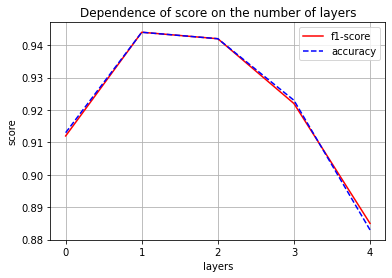

In [160]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(stats_df['num_layers'].values, stats_df['f1'].values, 'r', label='f1-score')
plt.plot(stats_df['num_layers'].values, stats_df['accuracy'].values, 'b--', label='accuracy')
plt.xticks(stats_df['num_layers'].values)
plt.grid()
plt.xlabel('layers')
plt.ylabel('score')
plt.title('Dependence of score on the number of layers')
plt.legend()
plt.show()